In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# VEST UT 2018

## VEST Documentation

## Election Results

### Sources

Election results from OpenElections (http://openelections.net/)  


### Processing

Several transcription errors were corrected from OpenElections using their raw results gathered from counties (https://github.com/openelections/openelections-sources-ut/tree/master/2018%20General%20Election). OE results in Rich and Morgan Counties were based on non-final reports, which were collected from county sources.

Emery County - 8 "canvas votes" were distributed to precincts.

Weber County - 6 precincts had their results suppressed, since all cast fewer than 15 votes, for a total of 42 votes. These were distributed based on the number of votes cast and the reported vote in 2016, which was not suppressed.

## Election Results Processing

#### Load in the VEST file

In [2]:
ut_vest = gp.read_file("raw-from-source/ut_2018/ut_2018.shp")

In [3]:
ut_vest.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.332603454538, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

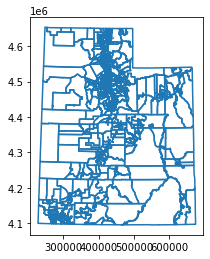

In [4]:
ut_vest.boundary.plot()

In [5]:
ut_vest.columns

Index(['CountyID', 'mergeid', 'uniqueid', 'G18USSRROM', 'G18USSDWIL',
       'G18USSIMCC', 'G18USSLBOW', 'G18USSCAAL', 'G18USSOWRI', 'geometry'],
      dtype='object')

In [6]:
ut_vest.head(5)

,CountyID,mergeid,uniqueid,G18USSRROM,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSCAAL,G18USSOWRI,geometry
0,1,BV01,1-BV01,402,46,8,9,19,1,"POLYGON ((358362.560 4238423.840, 358372.350 4..."
1,1,BV02,1-BV02,310,46,3,10,17,0,"POLYGON ((355866.750 4240506.080, 356860.230 4..."
2,1,BV03,1-BV03,244,30,0,2,12,2,"POLYGON ((358902.400 4261055.000, 358909.700 4..."
3,1,BV04,1-BV04,84,7,1,4,23,0,"POLYGON ((367866.500 4262536.100, 367842.500 4..."
4,1,GR01,1-GR01,56,9,6,1,1,1,"POLYGON ((348977.460 4223848.220, 348973.090 4..."


In [7]:
ut_vest.shape

(2337, 10)

#### make sure the uniqueid is a unique column

In [8]:
assert(len(ut_vest['uniqueid']) == len(ut_vest['uniqueid'].unique()))

## Election Results

### Load, Clean, Pivot Election Results

#### Load in the OpenElection general elections results for 2016

This file is used for creating name change dictionaries as well as for validating suppressed counties

In [9]:
ut_vest_2016 = gp.read_file("raw-from-source/ut_2016/ut_2016.shp")

#### Load in the OpenElection general elections results for 2018

In [10]:
ut_election_results = pd.read_csv('raw-from-source/20181106__ut__general__precinct.csv')

In [11]:
display(ut_election_results)

,county,precinct,office,district,candidate,party,votes
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3
...,...,...,...,...,...,...,...
41993,Morgan,Croydon 15.5,U S House,NaN,Rob Bishop,REP,64
41994,Morgan,Croydon 15.5,U S House,NaN,Eric Eliason,UUP,8
41995,Morgan,Croydon 15.5,U S House,NaN,Adam Davis,GRN,2
41996,Morgan,Croydon 15.5,Utah State House,53.0,Logan Wilde,REP,80


#### Filter down to needed races (U.S. Senate)

In [12]:
ut_senators = ut_election_results[(ut_election_results['office'] == 'U.S. Senate') | (ut_election_results['office'] == 'U S Senate')]
display(ut_senators)

,county,precinct,office,district,candidate,party,votes
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3
...,...,...,...,...,...,...,...
41987,Morgan,Croydon 15.5,U S Senate,NaN,Craig R. Bowden,LIB,4
41988,Morgan,Croydon 15.5,U S Senate,NaN,Reed C. McCandless,IAP,0
41989,Morgan,Croydon 15.5,U S Senate,NaN,Jenny Wilson,DEM,6
41990,Morgan,Croydon 15.5,U S Senate,NaN,Mitt Romney,REP,65


#### Create a name change dictionary for the candidates to match VEST

All candidates that are not representing the 5 major parties (who are: Tim Aalders, Craig Bowden, Reed McCandless, Jenny Wilson, Mitt Romney) are classified as write-in

In [13]:
senator_dict = {
    'Tim Aalders': 'G18USSCAAL',
    'TIM AALDERS': 'G18USSCAAL',
    
    'Craig Bowden': 'G18USSLBOW',
    'CRAIG R.  BOWDEN': 'G18USSLBOW',
    'CRAIG R BOWDEN': 'G18USSLBOW',
    'CRAIG R. BOWDEN': 'G18USSLBOW',
    'Craig R. Bowden': 'G18USSLBOW',
    
    'Reed McCandless': 'G18USSIMCC',
    'REED C. MCCANDLESS': 'G18USSIMCC',
    'REED C. McCANDLESS': 'G18USSIMCC', 
    'REED C MCCANDLESS': 'G18USSIMCC',
    'Reed C. McCandless': 'G18USSIMCC',
    
    'Jenny Wilson': 'G18USSDWIL',
    'JENNY WILSON': 'G18USSDWIL',
    
    'Mitt Romney': 'G18USSRROM',
    'MITT ROMNEY': 'G18USSRROM',
    
    'write-in': 'G18USSOWRI',
    'Write-ins': 'G18USSOWRI', 
    'Write-In': 'G18USSOWRI', 
    'Write-In Votes': 'G18USSOWRI',
    'Write In': 'G18USSOWRI', 
    'Write-In Totals': 'G18USSOWRI', 
    'write-ins': 'G18USSOWRI', 
    'Write-In Total': 'G18USSOWRI',
    'WRITE-IN': 'G18USSOWRI',
    
    'Tyrone Jensen (W)': 'G18USSOWRI',
    'TYRONE JENSEN': 'G18USSOWRI', 
    
    'GLADE G FITZGERALD': 'G18USSOWRI',
    'Glade G Fitzgerald (W)': 'G18USSOWRI',
    
    'HEKTOR REIKSTHEGN': 'G18USSOWRI',
    'Hektor Reiksthegn (W)': 'G18USSOWRI',
     
    'RYAN DANIEL JACKSON': 'G18USSOWRI',
    'Ryan Jackson': 'G18USSOWRI',
    'Ryan Daniel Jackson (W)': 'G18USSOWRI', 
    
    'ABE KORB': 'G18USSOWRI', 
    'Abe Korb (W)': 'G18USSOWRI',
     
    'Cody Judy (W)': 'G18USSOWRI',
    'CODY JUDY': 'G18USSOWRI',
    
    'Caleb Dan Reeve': 'G18USSOWRI',
    'CALEB DAN REEVE': 'G18USSOWRI',
    'Caleb Dan Reeve (W)': 'G18USSOWRI'
}

#### Apply candidate name change dictionary and confirm that all candidates are converted

In [14]:
ut_senators['candidateid'] = ut_senators['candidate'].map(senator_dict).fillna(ut_senators['candidate'])
print(ut_senators['candidateid'].unique()) 

['G18USSCAAL' 'G18USSLBOW' 'G18USSIMCC' 'G18USSDWIL' 'G18USSRROM'
 'G18USSOWRI']


<ipython-input-14-6adc37fe5ea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['candidateid'] = ut_senators['candidate'].map(senator_dict).fillna(ut_senators['candidate'])


#### Create county name & number dictionaries

All 29 counties in Utah are associated with a number between 1 and 29, in alphabetic order 

Here, we create two dictionaries - one that translates from county name to county num, and one that translates from county num to county name

In [15]:
counties = ut_vest_2016['county'].unique()
county_name_to_num = {}
for county in counties:
    if county not in county_name_to_num:
        county_name_to_num[county] = ut_vest_2016[ut_vest_2016['county'] == county].iloc[0]['CountyID']
        
    
county_num_to_name = {v: k for k, v in county_name_to_num.items()}
assert((len(county_num_to_name)) == (len(county_num_to_name)))

#### Create a countyid column - containing the numeric value of the county

In [16]:
ut_senators['countyid'] = ut_senators['county'].map(county_name_to_num)
county_names = ut_senators['county'].unique()
assert(len(county_names) == len(county_name_to_num))

<ipython-input-16-2eb9e816f63e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['countyid'] = ut_senators['county'].map(county_name_to_num)


#### Cast the vote column to integer type

Note: As mentioned above, the surpressed votes are marked as "*"

In [17]:
def cast_to_int(num):
    if num != '*':
        return int(num)
    else:
        return '*'

In [18]:
ut_senators['votes'] = ut_senators['votes'].apply(cast_to_int)

<ipython-input-18-930a8a1c1e2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['votes'] = ut_senators['votes'].apply(cast_to_int)


### Create a pivot column

In [19]:
ut_senators

,county,precinct,office,district,candidate,party,votes,candidateid,countyid
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7,G18USSCAAL,28
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6,G18USSCAAL,28
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6,G18USSCAAL,28
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8,G18USSCAAL,28
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3,G18USSCAAL,28
...,...,...,...,...,...,...,...,...,...
41987,Morgan,Croydon 15.5,U S Senate,NaN,Craig R. Bowden,LIB,4,G18USSLBOW,15
41988,Morgan,Croydon 15.5,U S Senate,NaN,Reed C. McCandless,IAP,0,G18USSIMCC,15
41989,Morgan,Croydon 15.5,U S Senate,NaN,Jenny Wilson,DEM,6,G18USSDWIL,15
41990,Morgan,Croydon 15.5,U S Senate,NaN,Mitt Romney,REP,65,G18USSRROM,15


The precinct column contains either an alphabetic name of the precinct or a numerical representation. Therefore, some repeats in numerical representation for a precinct occur across counties. Therefore, we combine countyid and precinct columns to create a mergeid column representing each precinct

In [20]:
ut_senators['mergeid'] = ut_senators['countyid'].astype(str)+'-'+ut_senators['precinct']

<ipython-input-20-9ada46d52f3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_senators['mergeid'] = ut_senators['countyid'].astype(str)+'-'+ut_senators['precinct']


#### Perform the pivot

In [21]:
pivoted_2018 = pd.pivot_table(ut_senators,values=["votes"],index=["mergeid"],columns=["candidateid"],aggfunc=sum)
pivoted_2018=pivoted_2018.fillna(0)
pivoted_2018.reset_index(drop=False,inplace=True)
#pivoted_2018.columns = pivoted_2018.columns.droplevel(0)

pivoted_2018.columns = ['joinid', 'G18USSCAAL', 'G18USSDWIL', 'G18USSIMCC', 'G18USSLBOW', 'G18USSOWRI', 'G18USSRROM']
display(pivoted_2018)
#pivoted_2018.to_csv('./pivoted_2018.csv')

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2266,9-Henrieville HE6:1,3,14,0,2,0,94
2267,9-Panguitch 1 PA7:1,18,37,3,12,0,374
2268,9-Panguitch 2 PA8:1,11,28,4,2,0,315
2269,9-Ticaboo TI9:1,0,4,0,1,0,10


#### Remove Total/Canvas votes

Counties that have totals row are: 11, 13, 21

In [22]:
totals_joinid = ['11-IRON UT', '13-TOTALS', '21-TOTALS']
list_of_candidates = ['G18USSCAAL','G18USSDWIL','G18USSIMCC','G18USSLBOW','G18USSOWRI','G18USSRROM']

#validate that each counties votes add up to totals

#County 11
df11 = pivoted_2018[pivoted_2018.joinid.str.startswith('11-')]
df11_total = df11[df11.joinid == '11-IRON UT']
df11_non_total = df11.drop(df11_total.index)
df11_non_total.loc["totals"] = df11_non_total.sum(axis = 0)
display(df11_non_total.loc['totals'])
display(df11_total)
for cand in list_of_candidates:
    print('For county 11 and race', cand)
    print('The totals provided by the totals row are:', int(df11_total[cand]))
    print('The totals as a result of the sum of the votes in each precinct are:', df11_non_total.loc['totals'][cand])
    print('And their difference is:', (int(df11_total[cand]) - df11_non_total.loc['totals'][cand]))
    print()
    
#County 13
df13 = pivoted_2018[pivoted_2018.joinid.str.startswith('13-')]
df13_total = df13[df13.joinid == '13-TOTALS']
df13_non_total = df13.drop(df13_total.index)
df13_non_total.loc["totals"] = df13_non_total.sum(axis = 0)
display(df13_non_total.loc['totals'])
display(df13_total)
for cand in list_of_candidates:
    print('For county 13 and race', cand)
    print('The totals provided by the totals row are:', int(df13_total[cand]))
    print('The totals as a result of the sum of the votes in each precinct are:', df13_non_total.loc['totals'][cand])
    print('And their difference is:', (int(df13_total[cand]) - df13_non_total.loc['totals'][cand]))
    print()
    
#County 21
df21 = pivoted_2018[pivoted_2018.joinid.str.startswith('21-')]
df21_total = df21[df21.joinid == '21-TOTALS']
df21_non_total = df21.drop(df21_total.index)
df21_non_total.loc["totals"] = df21_non_total.sum(axis = 0)
display(df21_non_total.loc['totals'])
display(df21_total)
for cand in list_of_candidates:
    print('For county 21 and race', cand)
    print('The totals provided by the totals row are:', int(df21_total[cand]))
    print('The totals as a result of the sum of the votes in each precinct are:', df21_non_total.loc['totals'][cand])
    print('And their difference is:', (int(df21_total[cand]) - df21_non_total.loc['totals'][cand]))
    print()

joinid        11-BH11-BRYL11-CC0111-CC0211-CC0311-CC0411-CC0...
G18USSCAAL                                                  866
G18USSDWIL                                                 2846
G18USSIMCC                                                  206
G18USSLBOW                                                  597
G18USSOWRI                                                   68
G18USSRROM                                                11286
Name: totals, dtype: object

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
59,11-IRON UT,866,2846,206,597,68,11286


For county 11 and race G18USSCAAL
The totals provided by the totals row are: 866
The totals as a result of the sum of the votes in each precinct are: 866
And their difference is: 0

For county 11 and race G18USSDWIL
The totals provided by the totals row are: 2846
The totals as a result of the sum of the votes in each precinct are: 2846
And their difference is: 0

For county 11 and race G18USSIMCC
The totals provided by the totals row are: 206
The totals as a result of the sum of the votes in each precinct are: 206
And their difference is: 0

For county 11 and race G18USSLBOW
The totals provided by the totals row are: 597
The totals as a result of the sum of the votes in each precinct are: 597
And their difference is: 0

For county 11 and race G18USSOWRI
The totals provided by the totals row are: 68
The totals as a result of the sum of the votes in each precinct are: 68
And their difference is: 0

For county 11 and race G18USSRROM
The totals provided by the totals row are: 11286
The tot

joinid        13-AL13-BU13-BW13-CM13-CW:B13-CW:C13-GL13-K113...
G18USSCAAL                                                  109
G18USSDWIL                                                  746
G18USSIMCC                                                   38
G18USSLBOW                                                   89
G18USSOWRI                                                    6
G18USSRROM                                                 2135
Name: totals, dtype: object

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
100,13-TOTALS,109,746,38,89,6,2135


For county 13 and race G18USSCAAL
The totals provided by the totals row are: 109
The totals as a result of the sum of the votes in each precinct are: 109
And their difference is: 0

For county 13 and race G18USSDWIL
The totals provided by the totals row are: 746
The totals as a result of the sum of the votes in each precinct are: 746
And their difference is: 0

For county 13 and race G18USSIMCC
The totals provided by the totals row are: 38
The totals as a result of the sum of the votes in each precinct are: 38
And their difference is: 0

For county 13 and race G18USSLBOW
The totals provided by the totals row are: 89
The totals as a result of the sum of the votes in each precinct are: 89
And their difference is: 0

For county 13 and race G18USSOWRI
The totals provided by the totals row are: 6
The totals as a result of the sum of the votes in each precinct are: 6
And their difference is: 0

For county 13 and race G18USSRROM
The totals provided by the totals row are: 2135
The totals as a 

joinid        21-Annabella 121-Aurora 221-Central Valley 421...
G18USSCAAL                                                  408
G18USSDWIL                                                  771
G18USSIMCC                                                  113
G18USSLBOW                                                  173
G18USSOWRI                                                   50
G18USSRROM                                                 5810
Name: totals, dtype: object

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
1047,21-TOTALS,408,771,113,173,50,5810


For county 21 and race G18USSCAAL
The totals provided by the totals row are: 408
The totals as a result of the sum of the votes in each precinct are: 408
And their difference is: 0

For county 21 and race G18USSDWIL
The totals provided by the totals row are: 771
The totals as a result of the sum of the votes in each precinct are: 771
And their difference is: 0

For county 21 and race G18USSIMCC
The totals provided by the totals row are: 113
The totals as a result of the sum of the votes in each precinct are: 113
And their difference is: 0

For county 21 and race G18USSLBOW
The totals provided by the totals row are: 173
The totals as a result of the sum of the votes in each precinct are: 173
And their difference is: 0

For county 21 and race G18USSOWRI
The totals provided by the totals row are: 50
The totals as a result of the sum of the votes in each precinct are: 50
And their difference is: 0

For county 21 and race G18USSRROM
The totals provided by the totals row are: 5810
The totals

Since all of the votes add up to their respective totals, we can remove the totals row before merging with the vest file

In [23]:
pivoted_2018 = pivoted_2018.drop(pivoted_2018[pivoted_2018.joinid == '11-IRON UT'].index)
pivoted_2018 = pivoted_2018.drop(pivoted_2018[pivoted_2018.joinid == '13-TOTALS'].index)
pivoted_2018 = pivoted_2018.drop(pivoted_2018[pivoted_2018.joinid == '21-TOTALS'].index)
pivoted_2018

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2266,9-Henrieville HE6:1,3,14,0,2,0,94
2267,9-Panguitch 1 PA7:1,18,37,3,12,0,374
2268,9-Panguitch 2 PA8:1,11,28,4,2,0,315
2269,9-Ticaboo TI9:1,0,4,0,1,0,10


#### Distribute Canvas votes 

In [24]:
canvas_votes = pivoted_2018[pivoted_2018["joinid"] ==  '8-Canvas']
office_rom = canvas_votes["G18USSRROM"].iloc[0]
office_wil = canvas_votes["G18USSDWIL"].iloc[0]
office_aal = canvas_votes["G18USSCAAL"].iloc[0]

display(canvas_votes)

ut_precinct_8 = pivoted_2018[pivoted_2018.joinid.str.startswith('8-')]

merged_distribute = pivoted_2018.drop(ut_precinct_8.index)


#distributing votes for race G18USSRROM
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSRROM', ascending=False)
for i in range(0, int(office_rom)):
    ut_precinct_8['G18USSRROM'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSRROM']) + 1)
    
    
#distributing votes for race G18USSDWIL
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSDWIL', ascending=False)
for i in range(0, int(office_wil)):
    ut_precinct_8['G18USSDWIL'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSDWIL']) + 1)

#distributing votes for race G18USSCAAL
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSCAAL', ascending=False)
for i in range(0, int(office_aal)):
    ut_precinct_8['G18USSCAAL'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSCAAL']) + 1)


merged_with_canvas = pd.concat([merged_distribute, ut_precinct_8])

pivoted = merged_with_canvas.drop(merged_with_canvas[merged_with_canvas.joinid == '8-Canvas'].index)
display(pivoted)


,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
2247,8-Canvas,1,1,0,0,0,6


,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2249,8-Castle Dale 7,6,45,6,8,1,269
2251,8-Cleveland 10,6,43,11,10,0,297
2248,8-Castle Dale 6,5,39,14,4,0,222
2253,8-Emery 1,5,16,7,2,0,109


### Attempt to distribute 42 suppressed votes in the 29th county (marked with an asterisk)


VEST claims to have used the distribution of votes from 2016, but those do not line up with expected results for 2018 (and do not have the same number of candidates running)  

The '42' number seems justified based on the state elections website totals: https://elections.utah.gov/Media/Default/2018%20Election/2018%20General%20Election%20Canvass.pdf

In [25]:
pre_suppress = pivoted
suppressed_precincts = pre_suppress.loc[(pre_suppress["G18USSCAAL"] == '*') |
                 (pre_suppress["G18USSDWIL"] == '*') |
                (pre_suppress["G18USSIMCC"] == '*') |
                (pre_suppress["G18USSLBOW"] == '*') |
                (pre_suppress["G18USSOWRI"] == '*') |
                (pre_suppress["G18USSRROM"] == '*')]

display(suppressed_precincts)

suppressed_ids = suppressed_precincts.joinid.unique()

supp_prec = []

for i in suppressed_ids:
    supp_prec.append(i[3:])

print('The following precincts have suppressed voted:', supp_prec)

vest_2016_weber = (ut_vest_2016[ut_vest_2016['CountyID'] == 29])
vest_2016_suppress = (vest_2016_weber[vest_2016_weber['PrecinctID'].isin(supp_prec)])

# races specified in VEST documentation for 2016 general election
vest_2016_senators = ['G16USSRLEE', 'G16USSDSNO', 'G16USSAFON', 'G16USSIBAR']
vest_2016_basic_columns = ['CountyID','PrecinctID','county','precinct']
vest_2016_columns = vest_2016_basic_columns + vest_2016_senators
vest_2016_suppress = vest_2016_suppress[vest_2016_columns]
display(vest_2016_suppress)



,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
1850,29-WCO001,*,*,*,*,*,*
1853,29-WCR002,*,*,*,*,*,*
1854,29-WCS001,*,*,*,*,*,*
1857,29-WCV001,*,*,*,*,*,*
1868,29-WNO001,*,8,*,*,*,*
1869,29-WNO002,*,*,*,*,*,*


The following precincts have suppressed voted: ['WCO001', 'WCR002', 'WCS001', 'WCV001', 'WNO001', 'WNO002']


,CountyID,PrecinctID,county,precinct,G16USSRLEE,G16USSDSNO,G16USSAFON,G16USSIBAR
2240,29,WCO001,Weber,WCO001,12,2,1,0
2243,29,WCR002,Weber,WCR002,9,11,0,0
2245,29,WCS001,Weber,WCS001,2,0,0,0
2248,29,WCV001,Weber,WCV001,2,0,0,0
2259,29,WNO001,Weber,WNO001,8,1,0,0
2260,29,WNO002,Weber,WNO002,18,0,0,0


Since the ratios for parties do not match up, we cannot use 2016 results to distribute suppressed votes in Weber county

#### Turn suppressed votes to 0 for validation purposes

Since the script will not operate on non-integer values (such as '*')

In [26]:
non_suppress = pivoted.drop(suppressed_precincts.index)
display(non_suppress)

for cand in list_of_candidates:
    suppressed_precincts[cand] = 0
display(suppressed_precincts)
ut_elec = pd.concat([non_suppress, suppressed_precincts])
display(ut_elec)


,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2249,8-Castle Dale 7,6,45,6,8,1,269
2251,8-Cleveland 10,6,43,11,10,0,297
2248,8-Castle Dale 6,5,39,14,4,0,222
2253,8-Emery 1,5,16,7,2,0,109


<ipython-input-26-20192e7a29a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suppressed_precincts[cand] = 0


,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
1850,29-WCO001,0,0,0,0,0,0
1853,29-WCR002,0,0,0,0,0,0
1854,29-WCS001,0,0,0,0,0,0
1857,29-WCV001,0,0,0,0,0,0
1868,29-WNO001,0,0,0,0,0,0
1869,29-WNO002,0,0,0,0,0,0


,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
1853,29-WCR002,0,0,0,0,0,0
1854,29-WCS001,0,0,0,0,0,0
1857,29-WCV001,0,0,0,0,0,0
1868,29-WNO001,0,0,0,0,0,0


#### Add WLRD county to the election data frame

This county is present both in the raw OpenElections files and VEST dataframe, but not in the OpenElections dataframe

In [27]:
# Load in Box Elder County vote files from OpenElections-sources-ut GitHub repo
ut_box_elder = pd.read_csv("raw-from-source/Box Elder UT 2018 General Precinct Results.csv")

The range for Willard county (WLRD) for senate elections was manually found to be located at indices 8095-8106

In [28]:
index_list = list(range(8095,8106)) #specific indeces correlating to Willard precinct votes displayed at index 8104
willard_df = (ut_box_elder.loc[index_list])
display(willard_df)
willard_cand_df = willard_df[:6]
willard_cand_df.columns = ['candidate', 'drop1', 'votes', 'drop2']
willard_cand_df = willard_cand_df[['candidate', 'votes']]
display(willard_cand_df)

display(ut_vest[ut_vest['uniqueid'] == '2-WLRD'])

,Summary Results Report,Unnamed: 1,Unnamed: 2,OFFICIAL RESULTS
8095,CON TIM AALDERS,NaN,26,NaN
8096,LIB CRAIG R. BOWDEN,NaN,11,NaN
8097,IAP REED C. McCANDLESS,NaN,13,NaN
8098,DEM JENNY WILSON,NaN,126,NaN
8099,REP MITT ROMNEY,NaN,609,NaN
8100,Write-In Totals,NaN,5,NaN
8101,Summary Results Report,NaN,OFFICIAL RESULTS,NaN
8102,GENERAL ELECTION,NaN,NaN,NaN
8103,"November 6, 2018",NaN,Box Elder,NaN
8104,Willard,NaN,NaN,NaN


,candidate,votes
8095,CON TIM AALDERS,26
8096,LIB CRAIG R. BOWDEN,11
8097,IAP REED C. McCANDLESS,13
8098,DEM JENNY WILSON,126
8099,REP MITT ROMNEY,609
8100,Write-In Totals,5


,CountyID,mergeid,uniqueid,G18USSRROM,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSCAAL,G18USSOWRI,geometry
60,2,WLRD,2-WLRD,609,126,13,11,26,5,"POLYGON ((387979.000 4593096.400, 388079.300 4..."


After confirming that the vote counts are equal for both OpenElections raw file and VEST final dataframe, we can add the raw file entry into the ut_elec dataframe

In [29]:
ut_elec

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
1853,29-WCR002,0,0,0,0,0,0
1854,29-WCS001,0,0,0,0,0,0
1857,29-WCV001,0,0,0,0,0,0
1868,29-WNO001,0,0,0,0,0,0


In [30]:
wlrd_df = {
    'joinid': '2-WLRD',
    'G18USSCAAL': (willard_cand_df.loc[willard_cand_df['candidate'] == 'CON TIM AALDERS', 'votes']).to_list()[0],
    'G18USSDWIL': (willard_cand_df.loc[willard_cand_df['candidate'] == 'DEM JENNY WILSON', 'votes']).to_list()[0],
    'G18USSIMCC': (willard_cand_df.loc[willard_cand_df['candidate'] == 'IAP REED C. McCANDLESS', 'votes']).to_list()[0],
    'G18USSLBOW': (willard_cand_df.loc[willard_cand_df['candidate'] == 'LIB CRAIG R. BOWDEN', 'votes']).to_list()[0],
    'G18USSOWRI': (willard_cand_df.loc[willard_cand_df['candidate'] == 'Write-In Totals', 'votes']).to_list()[0],
    'G18USSRROM': (willard_cand_df.loc[willard_cand_df['candidate'] == 'REP MITT ROMNEY', 'votes']).to_list()[0],
    'county': '2'
}
ut_elec = ut_elec.append(wlrd_df, ignore_index=True)
display(ut_elec)

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM,county
0,1-Beaver 1,19,46,8,9,1,402,NaN
1,1-Beaver 2,17,46,3,10,0,310,NaN
2,1-Beaver 3,12,30,0,2,2,244,NaN
3,1-Beaver 4,23,7,1,4,0,84,NaN
4,1-Greenville,1,9,6,1,1,56,NaN
...,...,...,...,...,...,...,...,...
2263,29-WCS001,0,0,0,0,0,0,NaN
2264,29-WCV001,0,0,0,0,0,0,NaN
2265,29-WNO001,0,0,0,0,0,0,NaN
2266,29-WNO002,0,0,0,0,0,0,NaN


### Check vote totals on race and county level between VEST and Source

#### Confirm equal votes per each race between VEST df and Source df

Cast both dataframes to int to prepare for addition

In [31]:
for race in list_of_candidates:
    ut_vest[race] = ut_vest[race].apply(cast_to_int)
    ut_elec[race] = ut_elec[race].apply(cast_to_int)

In [32]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [33]:
statewide_totals_check(ut_vest,ut_elec,list_of_candidates)

***Statewide Totals Check***
G18USSCAAL is equal 	VEST / RDH: 28774
G18USSDWIL has a difference of 20 votes
	VEST: 328541 votes
	SOURCES: 328521 votes
G18USSIMCC has a difference of -2 votes
	VEST: 12708 votes
	SOURCES: 12710 votes
G18USSLBOW has a difference of 7 votes
	VEST: 27607 votes
	SOURCES: 27600 votes
G18USSOWRI has a difference of -122 votes
	VEST: 1643 votes
	SOURCES: 1765 votes
G18USSRROM has a difference of 530 votes
	VEST: 665215 votes
	SOURCES: 664685 votes


In [34]:
ut_elec['county'] = ut_elec['joinid'].apply(lambda x: x.split('-')[0]).astype(int)
ut_vest['CountyID'] = ut_vest['CountyID'].astype(int)
ut_elec['CountyID'] = ut_elec['county']

In [35]:

data_columns = []

print("Counties with differences printed below:")
diff_counties=[]
for i in list_of_candidates:
    diff = ut_vest.groupby(["CountyID"]).sum()[i]-ut_elec.groupby(["county"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:
G18USSCAAL
12   -2
26   -2
29    4
G18USSDWIL
12     8
29    12
G18USSIMCC
4    -3
12    1
26   -2
29    2
G18USSLBOW
12   -1
26    4
29    4
G18USSOWRI
12   -120
29     -2
G18USSRROM
7      94
8     200
12    114
28      1
29    121

All other races in all counties are equal


In [36]:
for race in list_of_candidates:
    ut_elec[race]=ut_elec[race].astype(int)

In [37]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+str(val)+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [38]:
county_totals_check(ut_vest,ut_elec,list_of_candidates,"CountyID",full_print=False)

***Countywide Totals Check***

G18USSCAAL contains differences in these counties:
	12 has a difference of -2 votes
		VEST: 210 votes
		SOURCES: 212 votes
	26 has a difference of -2 votes
		VEST: 272 votes
		SOURCES: 274 votes
	29 has a difference of 4 votes
		VEST: 2443 votes
		SOURCES: 2439 votes
G18USSDWIL contains differences in these counties:
	12 has a difference of 8 votes
		VEST: 492 votes
		SOURCES: 484 votes
	29 has a difference of 12 votes
		VEST: 24513 votes
		SOURCES: 24501 votes
G18USSIMCC contains differences in these counties:
	4 has a difference of -3 votes
		VEST: 217 votes
		SOURCES: 220 votes
	12 has a difference of 1 votes
		VEST: 52 votes
		SOURCES: 51 votes
	26 has a difference of -2 votes
		VEST: 101 votes
		SOURCES: 103 votes
	29 has a difference of 2 votes
		VEST: 1080 votes
		SOURCES: 1078 votes
G18USSLBOW contains differences in these counties:
	12 has a difference of -1 votes
		VEST: 80 votes
		SOURCES: 81 votes
	26 has a difference of 4 votes
		VEST: 222 vo

## Joining election results to VEST

In [39]:
#create a joinid column for the ut_vest dataframe
ut_vest['joinid'] = ut_vest['CountyID'].astype(str)+'-'+ut_vest['mergeid']

#### Attempt to join

In [40]:
join_attempt_one = pd.merge(ut_vest, ut_elec, how="outer", on="joinid", indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
merged = join_attempt_one[join_attempt_one["_merge"]=="both"]


both          1694
left_only      643
right_only     574
Name: _merge, dtype: int64


#### Change names to increase matches

In [41]:
joinid_dict = {'1-Beaver 1': '1-BV01',
 '1-Beaver 2': '1-BV02',
 '1-Beaver 3': '1-BV03',
 '1-Beaver 4': '1-BV04',
 '1-Greenville': '1-GR01',
 '1-Milford 1': '1-ML01',
 '1-Milford 2': '1-ML02',
 '1-Milford 3': '1-ML03',
 '1-Minersville': '1-MV01',
 '2-Brigham City 01': '2-BC01',
 '2-Brigham City 02': '2-BC02',
 '2-Brigham City 03': '2-BC03',
 '2-Brigham City 04': '2-BC04',
 '2-Brigham City 05': '2-BC05',
 '2-Brigham City 06': '2-BC06',
 '2-Brigham City 07': '2-BC07',
 '2-Brigham City 08': '2-BC08',
 '2-Brigham City 09': '2-BC09',
 '2-Brigham City 10': '2-BC10',
 '2-Brigham City 11': '2-BC11',
 '2-Brigham City 12': '2-BC12',
 '2-Brigham City 13': '2-BC13',
 '2-Brigham City 14': '2-BC14',
 '2-Brigham City 15': '2-BC15',
 '2-Brigham City North': '2-BCN',
 '2-Beaver Dam/Collinston': '2-BD/C',
 '2-Bear River': '2-BEAR',
 '2-Bear River East': '2-BRE',
 '2-Clear Creek': '2-CC',
 '2-Corinne 1': '2-COR1',
 '2-Corinne 2': '2-COR2',
 '2-Deweyville': '2-DEWY',
 '2-Elwood': '2-ELWD',
 '2-Fielding 1': '2-FLDG1',
 '2-Fielding 2': '2-FLDG2',
 '2-Garland 1': '2-GAR1',
 '2-Garland 2': '2-GAR2',
 '2-Garland East': '2-GARE',
 '2-Grouse Creek': '2-GC',
 '2-Honeyville': '2-HONY',
 '2-Howell': '2-HOWL',
 '2-Mantua': '2-MANT',
 '2-Park Valley': '2-PARK',
 '2-Perry 1': '2-PER1',
 '2-Perry 2': '2-PER2',
 '2-Perry 3': '2-PER3',
 '2-Perry 4': '2-PER4',
 '2-Plymouth': '2-PLYM',
 '2-Portage': '2-PORT',
 '2-Promontory': '2-PROM',
 '2-Riverside': '2-RIV',
 '2-Snowville': '2-SNOW',
 '2-South Willard': '2-SWIL',
 '2-Tremonton 1': '2-TRE1',
 '2-Tremonton 2': '2-TRE2',
 '2-Tremonton 3': '2-TRE3',
 '2-Tremonton 4': '2-TRE4',
 '2-Tremonton 5': '2-TRE5',
 '2-Tremonton South': '2-TRES',
 '2-Tremonton West': '2-TREW',
 '2-Yost': '2-YOST',
 '3-LOG01-CSD': '3-LOG01:CSD',
 '3-LOG01-1': '3-LOG01:I',
 '3-LOG27-17C': '3-LOG27:17C',
 '3-LOG37-CSD': '3-LOG27:CSD',
 '3-LOG27-1': '3-LOG27:I',
 '3-LOG27-U': '3-LOG27:U',
 '3-LOG29-CSD': '3-LOG29:CSD',
 '3-LOG29-1': '3-LOG29:I',
 '3-LOG33-5': '3-LOG33:5',
 '3-LOG33-CSD': '3-LOG33:CSD',
 '3-LOG33-1': '3-LOG33:I',
 '4-02 Scofield': '4-2',
 '4-03 Pleasant Valley': '4-3',
 '4-07 East Helper': '4-7',
 '4-16 South Price': '4-16',
 '4-17 East Price': '4-17',
 '4-19 Wellington': '4-19',
 '4-20 East Carbon': '4-20',
 '4-21 West Helper': '4-21',
 '4-22 East County': '4-22',
 '4-27 Fairgrounds': '4-27',
 '4-30 Castle Hts North': '4-30',
 '4-31 Central Price': '4-31',
 '4-32 North East Pric': '4-32',
 '4-33 North Price': '4-33',
 '4-34 Castle Heights': '4-34',
 '4-36 South County': '4-36',
 '4-37 Spring Glen': '4-37',
 '4-38 Carbonville': '4-38',
 '4-39 Westwood': '4-39',
 '4-40 Miller Creek': '4-40',
 '5-1001:DS1, SD1': '5-1001:DS1,SD1',
 '5-1001:DS2, SD2': '5-1001:DS2,SD2',
 '6-BO01:I-S-': '6-BO01',
 '6-BO02:I-S-': '6-BO02',
 '6-BO03:I-S-': '6-BO03',
 '6-BO05:I-S-': '6-BO05',
 '6-BO06:I-S-': '6-BO06',
 '6-BO07:I-S-': '6-BO07',
 '6-BO08:I-S-': '6-BO08',
 '6-BO09:I-S-': '6-BO09',
 '6-BO11:I-S-': '6-BO11',
 '6-BO12:I-S-': '6-BO12',
 '6-BO13:I-S-': '6-BO13',
 '6-BO14:I-S-': '6-BO14',
 '6-BO15:I-S-': '6-BO15',
 '6-BO16:I-S-': '6-BO16',
 '6-BO19:I-S-': '6-BO19',
 '6-BO20:I-S-': '6-BO20',
 '6-BO21:I-S-': '6-BO21',
 '6-BO22:I-S-': '6-BO22',
 '6-BO24:I-S-': '6-BO24',
 '6-BO26:IDS-': '6-BO26',
 '6-BO27:I-S-': '6-BO27',
 '6-BO32:I-S-': '6-BO32',
 '6-BO33:I-S-': '6-BO33',
 '6-CE01:I-S-': '6-CE01',
 '6-CE03:I-S-': '6-CE03',
 '6-CE06:I-S-': '6-CE06',
 '6-CE07:I-S-': '6-CE07',
 '6-CE09:I-S-': '6-CE09',
 '6-CE10:I-S-': '6-CE10',
 '6-CE12:I-S-': '6-CE12',
 '6-CF01:I-N-': '6-CF01',
 '6-CF02:I-N-': '6-CF02',
 '6-CF03:I-N-': '6-CF03',
 '6-CF04:I-N-': '6-CF04',
 '6-CF05:I-N-': '6-CF05',
 '6-CF06:I-N-': '6-CF06',
 '6-CF07:I-N-': '6-CF07',
 '6-CF08:I-N-': '6-CF08',
 '6-CF09:I-N-': '6-CF09',
 '6-CF11:I-N-': '6-CF11',
 '6-CF12:I-N-': '6-CF12',
 '6-CF13:I-N-': '6-CF13',
 '6-CF14:I-N-': '6-CF14',
 '6-CF15:I-N-': '6-CF15',
 '6-CF16:I-N-': '6-CF16',
 '6-CF17:I-N-': '6-CF17',
 '6-CL01:I-N-': '6-CL01',
 '6-CL02:I-N-': '6-CL02',
 '6-CL04:I-N-': '6-CL04',
 '6-CL05:I-N-': '6-CL05',
 '6-CL06:I-N-': '6-CL06',
 '6-CL07:I-N-': '6-CL07',
 '6-CL08:I-N-': '6-CL08',
 '6-CL09:I-N-': '6-CL09',
 '6-CL10:I-N-': '6-CL10',
 '6-CL11:I-N-': '6-CL11',
 '6-CL12:I-N-': '6-CL12',
 '6-CL13:I-N-': '6-CL13',
 '6-FA03:I-C-': '6-FA03',
 '6-FA05:IBC-': '6-FA05',
 '6-FA07:IBC-': '6-FA07',
 '6-FA09:IBC-': '6-FA09',
 '6-FA11:IBC-': '6-FA11',
 '6-FA13:IBC-': '6-FA13',
 '6-FA14:I-C-': '6-FA14',
 '6-FA15:IBC-': '6-FA15',
 '6-FA16:IBC-': '6-FA16',
 '6-FH01:I-C-': '6-FH01',
 '6-FH05:I-C-': '6-FH05',
 '6-HA03:U-N-': '6-HA03',
 '6-KA01:I-C-': '6-KA01',
 '6-KA02:I-C-': '6-KA02',
 '6-KA03:I-C-': '6-KA03',
 '6-KA04:I-C-': '6-KA04',
 '6-KA07:I-C-': '6-KA07',
 '6-KA10:I-C-': '6-KA10',
 '6-KA13:IBC-': '6-KA13',
 '6-KA15:IBC-': '6-KA15',
 '6-KA16:IBC-': '6-KA16',
 '6-KA18:I-C-': '6-KA18',
 '6-KA22:I-C-': '6-KA22',
 '6-LA03:I-N-': '6-LA03',
 '6-LA05:I-N-': '6-LA05',
 '6-LA06:I-N-': '6-LA06',
 '6-LA07:I-N-': '6-LA07',
 '6-LA08:I-N-': '6-LA08',
 '6-LA10:I-N-': '6-LA10',
 '6-LA11:I-N-': '6-LA11',
 '6-LA12:I-N-': '6-LA12',
 '6-LA13:I-N-': '6-LA13',
 '6-LA14:I-N-': '6-LA14',
 '6-LA15:I-N-': '6-LA15',
 '6-LA16:I-N-': '6-LA16',
 '6-LA17:I-N-': '6-LA17',
 '6-LA18:I-N-': '6-LA18',
 '6-LA19:I-N-': '6-LA19',
 '6-LA20:I-N-': '6-LA20',
 '6-LA21:I-N-': '6-LA21',
 '6-LA22:I-N-': '6-LA22',
 '6-LA23:I-N-': '6-LA23',
 '6-LA25:I-N-': '6-LA25',
 '6-LA26:I-N-': '6-LA26',
 '6-LA27:I-N-': '6-LA27',
 '6-LA28:I-N-': '6-LA28',
 '6-LA29:I-N-': '6-LA29',
 '6-LA30:I-N-': '6-LA30',
 '6-LA31:I-N-': '6-LA31',
 '6-LA32:I-N-': '6-LA32',
 '6-LA40:I-N-': '6-LA40',
 '6-LA42:I-N-': '6-LA42',
 '6-LA43:I-N-': '6-LA43',
 '6-LA45:I-N-': '6-LA45',
 '6-LA46:I-N-': '6-LA46',
 '6-LA47:I-N-': '6-LA47',
 '6-NS01:I-S-': '6-NS01',
 '6-NS04:I-S-': '6-NS04',
 '6-NS07:UDS-': '6-NS07',
 '6-NS09:I-S-': '6-NS09',
 '6-NS10:I-S-': '6-NS10',
 '6-NS11:I-S-': '6-NS11',
 '6-SU01:I-N-': '6-SU01',
 '6-SU02:I-N-': '6-SU02',
 '6-SU03:I-N-': '6-SU03',
 '6-SW04:U---': '6-SW04',
 '6-SY01:I-N-': '6-SY01',
 '6-SY03:I-N-': '6-SY03',
 '6-SY04:I-N-': '6-SY04',
 '6-SY05:I-N-': '6-SY05',
 '6-SY06:I-N-': '6-SY06',
 '6-SY07:I-N-': '6-SY07',
 '6-SY08:I-N-': '6-SY08',
 '6-SY10:I-N-': '6-SY10',
 '6-SY12:I-N-': '6-SY12',
 '6-SY13:I-N-': '6-SY13',
 '6-SY14:I-N-': '6-SY14',
 '6-SY15:I-N-': '6-SY15',
 '6-SY16:I-N-': '6-SY16',
 '6-SY17:I-N-': '6-SY17',
 '6-SY18:I-N-': '6-SY18',
 '6-SY19:I-N-': '6-SY19',
 '6-WB01:I-S-': '6-WB01',
 '6-WB02:I-S-': '6-WB02',
 '6-WB03:I-S-': '6-WB03',
 '6-WP01:I-N-': '6-WP01',
 '6-WP03:I-N-': '6-WP03',
 '6-WP04:I-N-': '6-WP04',
 '6-WP06:I-N-': '6-WP06',
 '6-WP08:I-N-': '6-WP08',
 '6-WX02:I-S-': '6-WX02',
 '6-WX03:I-S-': '6-WX03',
 '6-WX05:I-S-': '6-WX05',
 '6-WX07:I-S-': '6-WX07',
 '7-RO92': '7-R092',
 '8-Emery 1': '8-1',
 '8-Cleveland 10': '8-10',
 '8-Elmo 11': '8-11',
 '8-Green River 12': '8-12',
 '8-Ferron 2': '8-2',
 '8-Ferron 3': '8-3',
 '8-Clawson 4': '8-4',
 '8-Orangeville 5': '8-5',
 '8-Castle Dale 6': '8-6',
 '8-Castle Dale 7': '8-7',
 '8-Huntington 8': '8-8',
 '8-Huntington 9': '8-9',
 '9-Antimony AN1:1': '9-AN1',
 '9-Boulder BO2:1': '9-BO2',
 '9-Bryce Canyon City BR11:1': '9-BR11',
 '9-Cannonville CA3:1': '9-CA3',
 '9-Escalante ES4:1': '9-ES4',
 '9-Hatch HA5:1': '9-HA5',
 '9-Henrieville HE6:1': '9-HE6',
 '9-Panguitch 1 PA7:1': '9-PA7',
 '9-Panguitch 2 PA8:1': '9-PA8',
 '9-Ticaboo TI9:1': '9-TI9',
 '9-Tropic TR10:1': '9-TR10',
 '10-01 Moab 1:70': '10-01:70',
 '10-02 Moab 2:69': '10-02:69',
 '10-03 Moab 2:70': '10-02:70',
 '10-04 Moab 3:70': '10-03:70',
 '10-05 Moab 4:69': '10-04:69',
 '10-06 Moab 4:70': '10-04:70',
 '10-07 Moab 5:69': '10-05:69',
 '10-08 Moab 5:70': '10-05:70',
 '10-09 Thompson 6:69': '10-06:69',
 '10-10 Thompson 6:70': '10-06:70',
 '10-11 Green River 7:69': '10-07:69',
 '10-12 Green River 7:70': '10-07:70',
 '10-13 Castle Valley 8:69': '10-08:69',
 '10-14 Moab 9:69': '10-09:69',
 '10-15 Moab 9:70': '10-09:70',
 '10-16 Moab 10:70': '10-10:70',
 '10-17 Moab 11:69': '10-11:69',
 '10-18 Moab 11:70': '10-11:70',
 '11-CC01': '11-CC 1',
 '11-CC02': '11-CC 2',
 '11-CC03': '11-CC 3',
 '11-CC04': '11-CC 4',
 '11-CC05': '11-CC 5',
 '11-CC06': '11-CC 6',
 '11-CC07': '11-CC 7',
 '11-CC08': '11-CC 8',
 '11-CC09': '11-CC 9',
 '11-CC10': '11-CC 10',
 '11-CC11': '11-CC 11',
 '11-CC12': '11-CC 12',
 '11-CC13': '11-CC 13',
 '11-CC14': '11-CC 14',
 '11-CC15': '11-CC 15',
 '11-CC16': '11-CC 16',
 '11-CC17': '11-CC 17',
 '11-CC18': '11-CC 18',
 '11-CC19': '11-CC 19',
 '11-CC20': '11-CC 20',
 '11-CC21': '11-CC 21',
 '11-CC22': '11-CC 22',
 '11-CC23': '11-CC 23',
 '11-CC24': '11-CC 24',
 '11-CC25': '11-CC 25',
 '11-CH1': '11-CH 1',
 '11-ENO1': '11-ENO 1',
 '11-ENO2': '11-ENO 2',
 '11-ENO3': '11-ENO 3',
 '11-ENO4': '11-ENO 4',
 '12-EU.1': '12-EU:1',
 '12-EU.2': '12-EU:2',
 '12-EU.3': '12-EU:3',
 '12-EU.4': '12-EU:4',
 '12-EU.5': '12-EU:5',
 '12-LE06.1': '12-LE06:1',
 '12-LE06.2': '12-LE06:2',
 '12-NE01.4': '12-NE01:4',
 '12-NE01.5': '12-NE01:5',
 '12-NE02.3': '12-NE02:3',
 '12-NE02.4': '12-NE02:4',
 '12-NE02.5': '12-NE02:5',
 '12-NE03.2': '12-NE03:2',
 '12-NE03.3': '12-NE03:3',
 '13-K1': '13-KA1',
 '13-K2': '13-KA2',
 '13-K3': '13-KA3',
 '13-K4': '13-KA4',
 '14-Abraham 14': '14-ABR14',
 '14-Delta 17': '14-DEL17',
 '14-Delta 18': '14-DEL18',
 '14-Deseret-Oasis 05': '14-DO5',
 '14-Fillmore 01': '14-FIL1',
 '14-Fillmore 02': '14-FIL2',
 '14-Flowell 25': '14-FLO25',
 '14-Garrison 16': '14-GAR16',
 '14-Hinckley 11': '14-HIN11',
 '14-Holden 08': '14-HOLD8',
 '14-Kanosh 04': '14-KAN4',
 '14-Leamington 07': '14-LEAM7',
 '14-Lynndyl 19': '14-LYN19',
 '14-Meadow 03': '14-MEA3',
 '14-Oak City 06': '14-OAK6',
 '14-Scipio 09': '14-SCIP9',
 '14-Sutherland 20': '14-SUTH20',
 '15-Mountain Green 1.1': '15-1:1',
 '15-City 10.4': '15-10:4',
 '15-City 11.4': '15-11:4',
 '15-City 12.4': '15-12:4',
 '15-No Mogan 13.5': '15-13:5',
 '15-No Mogan 14.5': '15-14:5',
 '15-Croydon 15.5': '15-15:5',
 '15-Mountain Green 2.1': '15-2:1',
 '15-Mountain Green 3.1': '15-3:1',
 '15-Peterson 4.2': '15-4:2',
 '15-Peterson 5.2': '15-5:2',
 '15-Peterson 6.2': '15-6:2',
 '15-Canyon Creek 7.3': '15-7:3',
 '15-Canyon Creek 8.3': '15-8:3',
 '15-Canyon Creek 9.3': '15-9:3',
 '16-Marysvale 1-1': '16-1:1',
 '16-Marysvale 1-2': '16-1:2',
 '16-Junction 2': '16-2:2',
 '16-Circleville 3-3': '16-3:3',
 '16-Circleville 3-5': '16-3:5',
 '16-Kingston 4': '16-4:4',
 '16-Greenwich 5': '16-5:4',
 '19-Precinct 1': '19-1',
 '19-Precinct 10': '19-10',
 '19-Precinct 11': '19-11',
 '19-Precinct 12': '19-12',
 '19-Precinct 2': '19-2',
 '19-Precinct 3': '19-3',
 '19-Precinct 4': '19-4',
 '19-Precinct 5': '19-5',
 '19-Precinct 6': '19-6',
 '19-Precinct 7': '19-7',
 '19-Precinct 8': '19-8',
 '19-Precinct 9': '19-9',
 '20-AXTSSD Axtell SSD': '20-AXTSSD',
 '20-AXTU Axtell': '20-AXTU',
 '20-CENM Centerfield City': '20-CENM',
 '20-EPH1M Ephraim City 1 (North)': '20-EPH1M',
 '20-EPH2M Ephraim City 2 (South W)': '20-EPH2M',
 '20-EPH3M Ephraim City (South E)': '20-EPH3M',
 '20-EPHU Ephraim Unincorporated': '20-EPHU',
 '20-FAYM Fayette Town': '20-FAYM',
 '20-FRVM Fairview City': '20-FRVM',
 '20-FRVU Fairview Unicorporated': '20-FRVU',
 '20-FTGM Fountain Green City': '20-FTGM',
 '20-GUNM Gunnison City': '20-GUNM',
 '20-MAN1M Manti City 1 (South)': '20-MAN1M',
 '20-MAN2M Manti City 2 (North)': '20-MAN2M',
 '20-MANU Manti Unicorporated': '20-MANU',
 '20-MAYM Mayfield Town': '20-MAYM',
 '20-MORM Moroni City': '20-MORM',
 '20-MORU Moroni Unicorporated': '20-MORU',
 '20-MTP1M Mt Pleasant City 1': '20-MTP1M',
 '20-MTP1U Mt Pleasant 1 Unicorp': '20-MTP1U',
 '20-MTP2M Mt Pleasant City 2': '20-MTP2M',
 '20-MTP2U Mt. Pleasant 2 Unicorp': '20-MTP2U',
 '20-MTP3U Mt. Pleasant 3 Unicorp': '20-MTP3U',
 '20-NSU Wales Chester Ftn Green Un': '20-NSU',
 '20-SPRM Spring City': '20-SPRM',
 '20-SPRU Spring City Unicorporated': '20-SPRU',
 '20-SSU Centerfield, Sterling, Fayette,Gunnison Un': '20-SSU',
 '20-STRM Sterling Town': '20-STRM',
 '20-WALM Wales Town': '20-WALM',
 '21-Annabella 1': '21-1',
 '21-Redmond 10': '21-10',
 '21-Richfield 11': '21-11',
 '21-Richfield 11.2': '21-11.2',
 '21-Richfield 12': '21-12',
 '21-Richfield 13': '21-13',
 '21-Salina 14': '21-14',
 '21-Salina 15': '21-15',
 '21-Sigurd 16': '21-16',
 '21-Koosharem 17': '21-17',
 '21-Venice 18': '21-18',
 '21-Aurora 2': '21-2',
 '21-Richfield 20': '21-20',
 '21-Richfield 20.2': '21-20.2',
 '21-Richfield 21': '21-21',
 '21-Richfield 22': '21-22',
 '21-Richfield 23': '21-23',
 '21-Richfield 23.2': '21-23.2',
 '21-Richfield 24': '21-24',
 '21-Richfield 24.2': '21-24.2',
 '21-Salina 25': '21-25',
 '21-Central Valley 4': '21-4',
 '21-Elsinore 5': '21-5',
 '21-Glenwood 6': '21-6',
 '21-Joseph 7.1.3': '21-7.1.3',
 '21-Joseph 7.2': '21-7.2',
 '21-Monroe 8': '21-8',
 '21-Monroe 9': '21-9',
 '22-Bitner': '22-BTN34',
 '22-Chalk Creek': '22-CCRK20',
 '22-Coalville': '22-COAL19',
 '22-Deer Valley North': '22-DVN1',
 '22-Deer Valley South': '22-DVS31',
 '22-Francis': '22-FRAN28',
 '22-Henefer': '22-HEN25',
 '22-Highland Estates East': '22-HEE38',
 '22-Highland Estates West': '22-HEW23',
 '22-Hoytsville': '22-HOYT18',
 '22-Hoytsville uninc': '22-HOYT18uninc',
 '22-Jeremy East': '22-JERE37',
 '22-Jeremy West': '22-JERW27',
 '22-Kamas': '22-KAM12',
 '22-Kimball Canyon': '22-KCYN43',
 '22-Lower Pinebrook': '22-LPIN9',
 '22-Moose Hollow': '22-MHW40',
 '22-North Summit North': '22-NSN24',
 '22-Oakley': '22-OAK14',
 '22-Old Town North': '22-OLDN32',
 '22-Old Town South': '22-OLDS2',
 '22-Park West': '22-PARW7',
 '22-Peoa 15:20': '22-PEOA15:20',
 '22-Peoa 15:25': '22-PEOA15:25',
 '22-Peoa 15:32': '22-PEOA15:32',
 '22-Pinebrook North': '22-PINN39',
 '22-Park Meadows North': '22-PKMN35',
 '22-Park Meadows South': '22-PKMS5',
 '22-Promontory Ridge': '22-PRDG45',
 '22-Prospector': '22-PROS3',
 '22-Quarry Mtn': '22-QUAR6',
 '22-Ranch Road South': '22-RANS36',
 '22-Ranch Place': '22-RPL26',
 '22-Lower Silver Creek': '22-SCRL44',
 '22-Upper Silver Creek': '22-SCRU8',
 '22-Sidewinder': '22-SIDE33',
 '22-Silver Springs': '22-SLVR16',
 '22-Snyders Mills': '22-SML42',
 '22-South Summit East': '22-SSE13',
 '22-South Summit South': '22-SSS11',
 '22-South Summit West': '22-SSW22',
 '22-Summit Park East': '22-SUME30',
 '22-Summit Park West': '22-SUMW10',
 '22-Thaynes Canyon': '22-THAY4',
 '22-Upper Pinebrook': '22-UPIN41',
 '22-Wagon Wheel': '22-WAGN29',
 '22-Wanship 17:10': '22-WAN17:10',
 '22-Wanship 17:2': '22-WAN17:2',
 '22-Wanship 17:32': '22-WAN17:32',
 '22-Weber Canyon 21:20': '22-WEBC21:20',
 '22-Weber Canyon 21:25': '22-WEBC21:25',
 '24-Ashley East #15': '24-AE15',
 '24-Avalon Willows #16': '24-AW16',
 '24-Ashley West #22': '24-AW22',
 '24-Ballard #19': '24-BL19',
 '24-Davis East #2': '24-DE02',
 '24-Davis North #24': '24-DN24',
 '24-Davis West #3': '24-DW03',
 '24-Ft. Duchesne #18': '24-FD18',
 '24-Glines North #23': '24-GN23',
 '24-Glines South #17': '24-GS17',
 '24-Jensen #1': '24-JN01',
 '24-Lapoint/Tridell #21': '24-LT21',
 '24-Maeser/Dry Fork #7': '24-MD07',
 '24-Maeser East #6': '24-ME06',
 '24-Maeser West #25': '24-MW25',
 '24-Naples #4': '24-NP04',
 '24-South #5': '24-SO05',
 '24-Southwest 26': '24-SW26',
 '24-Vernal City #8': '24-VC08',
 '24-Vernal City #9': '24-VC09',
 '24-Vernal City #10': '24-VC10',
 '24-Vernal City #11': '24-VC11',
 '24-Vernal City #12': '24-VC12',
 '24-Vernal City #13': '24-VC13',
 '24-Vernal City #14': '24-VC14',
 '24-Whiterocks #20': '24-WR20',
 '26-Wasatch 10': '26-10',
 '26-Wasatch 11': '26-11',
 '26-Wasatch 12': '26-12',
 '26-Wasatch 13': '26-13',
 '26-Wasatch 14': '26-14',
 '26-Wasatch 20': '26-20',
 '26-Wasatch 21': '26-21',
 '26-Wasatch 22': '26-22',
 '26-Wasatch 23': '26-23',
 '26-Wasatch 24': '26-24',
 '26-Wasatch 24:1': '26-24:1',
 '26-Wasatch 25': '26-25',
 '26-Wasatch 30': '26-30',
 '26-Wasatch 30:1': '26-30:1',
 '26-Wasatch 31': '26-31',
 '26-Wasatch 31:1': '26-31:1',
 '26-Wasatch 32': '26-32',
 '26-Wasatch 32:1': '26-32:1',
 '26-Wasatch 33': '26-33',
 '26-Wasatch 33:1': '26-33:1',
 '26-Wasatch 34': '26-34',
 '26-Wasatch 40': '26-40',
 '26-Wasatch 41': '26-41',
 '26-Wasatch 42': '26-42',
 '26-Wasatch 42:1': '26-42:1',
 '26-Wasatch 43': '26-43',
 '26-Wasatch 43:1': '26-43:1',
 '26-Wasatch 44': '26-44',
 '26-Wasatch 44:1': '26-44:1',
 '26-Wasatch 50': '26-50',
 '26-Wasatch 51': '26-51',
 '26-Wasatch 52': '26-52',
 '26-Wasatch 53': '26-53',
 '26-Wasatch 54': '26-54',
 '26-Wasatch 54:1': '26-54:1',
 '26-Wasatch 54:2': '26-54:2',
 '26-Wasatch 54:3': '26-54:3',
 '26-Wasatch 55': '26-55',
 '26-Wasatch 55:1': '26-55:1',
 '28-Bicknell in/out': '28-BI04',
 '28-Fremont': '28-FR01',
 '28-Hanksville in/out': '28-HA07',
 '28-Loa in/out': '28-LO02',
 '28-Lyman in/out': '28-LY03',
 '28-Teesdale': '28-TE05',
 '28-Torrey in/out': '28-TO06'}

#### Apply the names changes

In [42]:
ut_elec["joinid"] = ut_elec["joinid"].map(joinid_dict).fillna(ut_elec["joinid"])

#### Attempt to join second time

In [43]:
join_attempt_two = pd.merge(ut_vest,ut_elec,how="outer",on="joinid",indicator=True)
print(join_attempt_two["_merge"].value_counts())


merged = join_attempt_two[join_attempt_two["_merge"]=="both"]
right_only = join_attempt_two[join_attempt_two["_merge"]=="right_only"]
left_only = join_attempt_two[join_attempt_two["_merge"]=="left_only"]

both          2261
left_only       76
right_only       7
Name: _merge, dtype: int64


All non-merged precincts from VEST do not have votes

#### Assert that remaining precincts are zero vote precincts

In [44]:
data_columns = []
for race in list_of_candidates:
    data_columns.append(race + '_y')
    data_columns.append(race + '_x')
empty_precincts = []
for index, row in left_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["uniqueid"])
assert(len(empty_precincts) == len(left_only))

In [45]:
list_of_empty_precincts = left_only.uniqueid.tolist()
final_df = ut_elec.append(pd.DataFrame(list_of_empty_precincts, columns=['joinid']), ignore_index = True)
final_df.fillna(0, inplace=True)
display(final_df)

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM,county,CountyID
0,1-BV01,19.0,46.0,8.0,9.0,1.0,402.0,1.0,1.0
1,1-BV02,17.0,46.0,3.0,10.0,0.0,310.0,1.0,1.0
2,1-BV03,12.0,30.0,0.0,2.0,2.0,244.0,1.0,1.0
3,1-BV04,23.0,7.0,1.0,4.0,0.0,84.0,1.0,1.0
4,1-GR01,1.0,9.0,6.0,1.0,1.0,56.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2339,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2340,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2341,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2342,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Attempt the merge again, with zero-vote precincts appended

In [46]:
join_attempt_three = pd.merge(ut_vest, final_df, how="outer", on="joinid", indicator=True)
print(join_attempt_three["_merge"].value_counts())

right_only = join_attempt_three[join_attempt_three["_merge"]=="right_only"]
left_only = join_attempt_three[join_attempt_three["_merge"]=="left_only"]
election_merge = join_attempt_three[join_attempt_three["_merge"]=="both"]

both          2337
right_only       7
left_only        0
Name: _merge, dtype: int64


In [47]:
#### non merged precincts from source file have no votes
display(right_only)
data_columns = []
for race in list_of_candidates:
    data_columns.append(race + '_y')
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["joinid"])
print(len(empty_precincts))

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,county,CountyID_y,_merge
2337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-AF11:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only
2338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-CH02:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only
2339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-LE18:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only
2340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-MA05:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only
2341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-SP09:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only
2342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-SP14:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only
2343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-SR08:UN,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,right_only


7


### Run the election data validation checks

In [48]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["joinid"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["joinid"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["joinid"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [49]:
validater_row(merged.sort_values("joinid"),list_of_candidates)

G18USSCAAL ...............................................................12-NE02:5 (V) ....1  (S)....3 (D):    2
G18USSDWIL ...............................................................12-NE02:5 (V) ....9  (S)....1 (D):   -8
G18USSIMCC ...............................................................12-NE02:5 (V) ....1  (S)....0 (D):   -1
G18USSLBOW ...............................................................12-NE02:5 (V) ....0  (S)....1 (D):    1
G18USSOWRI ...............................................................12-NE02:5 (V) ....3  (S)..123 (D):  120
G18USSRROM ...............................................................12-NE02:5 (V) ..123  (S)....9 (D): -114
G18USSIMCC ...................................................................26-10 (V) ....4  (S)....6 (D):    2
G18USSLBOW ...................................................................26-10 (V) ....6  (S)....4 (D):   -2
G18USSCAAL ...................................................................26-21 (V) 

#### Explanation of vote differences

##### 12-NE02:5
The Source vote count for G18USSOWRI was shifted to G18USSRROM in the VEST file
The Source vote count for G18USSRROM was shifted to G18USSDWIL in the VEST file, etc. resulting in significant vote differences all around  

##### 26-10/26-21
Similar case of vote shifts between source and VEST

##### 29-WAT004
Off by 100, as seen in the raw files from OpenElections GitHub
https://github.com/openelections/openelections-sources-ut/blob/master/2018%20General%20Election/Weber%20UT%20Federal%20Race%20Precinct%20Report.pdf

##### 29th county - WCO001, WCR002, WCS001, WCV001, WNO001, WNO002
Votes obfuscated in these counties should total 42, which they do add up

##### 7-RO12
The last number of the vote count (4 in 104) got chopped off to create a typo and mistakenly reported as 10 in source
https://github.com/openelections/openelections-sources-ut/blob/master/2018%20General%20Election/Duchesne%20UT%202018%20November%20%20precnct%20by%20precinct.csv

##### 8-5
No raw source was found for this data, but clearly 462->262 typo possible in the leading digit value

Since in all verifiable cases, VEST correctly reported votes based off raw data, we're inclined to believe that VEST has correctly reported all votes in case of discrepancies, justifying it with fixing transcription errors

### Load and merge with shapefile

In [50]:
ut_geo = gp.read_file("raw-from-source/Utah_Vista_Ballot_Areas/VistaBallotAreas.shp")

In [51]:
ut_geo.shape

(3047, 14)

In [52]:
display(ut_geo)

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{F856988C-74CA-415D-AC4B-2A2020023EC9},0.195803,0.001577,"POLYGON ((-111.65149 37.09008, -111.65157 37.0..."
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{893A863C-A9DA-4214-8E4D-11FF587BCFBB},0.044090,0.000095,"POLYGON ((-111.70145 40.31183, -111.70274 40.3..."
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{30563DA7-3B62-427D-A0A5-1460FC75243B},0.039456,0.000041,"POLYGON ((-111.83496 40.74981, -111.83440 40.7..."
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{BF88FEB3-58B4-4952-AE30-9BAE88CFB519},2.571008,0.063659,"POLYGON ((-113.26559 37.19438, -113.26488 37.1..."
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3043,29,PLC002:B,PLC002,B,None,2021-02-22,None,None,2021-02-22,{D2A4DB59-F3AF-4B70-A6CB-D91C853A732F},0.234410,0.000769,"MULTIPOLYGON (((-112.05876 41.33589, -112.0589..."
3043,3044,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{C8BAAF11-5436-49CD-8A9F-2FBCF5CEBDED},0.036616,0.000062,"POLYGON ((-111.93201 40.64322, -111.93195 40.6..."
3044,3045,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{97F6DDC2-7C48-4874-88F2-A363691EF564},0.060945,0.000100,"POLYGON ((-111.81371 40.71131, -111.81371 40.7..."
3045,3046,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{CFB98657-4740-4B53-A6FF-BB69FE5CD0EB},0.045916,0.000078,"POLYGON ((-111.78793 40.58628, -111.78788 40.5..."


#### Create a unique joinid column in the shapefile

In [53]:
ut_geo["tempid"]=ut_geo["CountyID"].astype(str)+"-"+ut_geo["VistaID"]
ut_geo_dissolved = ut_geo.dissolve(by='tempid')
ut_geo_dissolved.reset_index(drop=False,inplace=True)

display(ut_geo_dissolved)

,tempid,geometry,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area
0,1-BV01:1,"POLYGON ((-112.61943 38.28272, -112.61932 38.2...",116,1,BV01:1,BV01,1,2013-1,2012-01-01,None,None,2013-10-16,{0FA59E15-AE99-4036-BAC2-9B52BD96C41E},0.078745,0.000202
1,1-BV02:1,"POLYGON ((-112.64838 38.30108, -112.63701 38.3...",1061,1,BV02:1,BV02,1,2013-1,2012-01-01,None,None,2013-10-16,{42E04D64-AB96-467C-8CA7-9C6CCB6BDC3C},0.226984,0.000838
2,1-BV03:1,"MULTIPOLYGON (((-112.65342 38.22070, -112.6533...",1017,1,BV03:1,BV03,1,2013-1,2013-10-16,None,None,2013-10-16,{1C4CBC52-7A01-4F50-AB5B-F3FC2BEB34A6},0.323054,0.000728
3,1-BV03:2,"MULTIPOLYGON (((-112.62208 38.31248, -112.6215...",420,1,BV03:2,BV03,2,2013-1,2013-10-16,None,None,2013-10-16,{D02BB6DB-1A3E-4369-BC75-7B0AE02820FE},2.428363,0.077798
4,1-BV04:1,"POLYGON ((-112.51533 38.50140, -112.51560 38.5...",2966,1,BV04:1,BV04,1,2013-1,2012-01-01,None,None,2013-10-16,{A9ECB9F0-C95B-497D-A358-C9CB6664DBE9},1.435445,0.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,9-PA8:1,"POLYGON ((-112.44624 37.81799, -112.45084 37.8...",855,9,PA8:1,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{636E5665-1302-47E1-939F-401CA0E16883},0.118368,0.000351
2922,9-PA8:2,"POLYGON ((-112.44624 37.81799, -112.44272 37.8...",913,9,PA8:2,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{D253077A-9D44-4537-B029-6246F8D8051D},1.826924,0.069706
2923,9-TI9:1,"POLYGON ((-110.20313 37.94548, -110.20329 37.9...",1059,9,TI9:1,TI9,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{D8704BC5-234B-4139-80C1-D03372242AE0},3.416384,0.407979
2924,9-TR10:1,"POLYGON ((-112.07416 37.65898, -112.07420 37.6...",549,9,TR10:1,TR10,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{AFF56C69-9659-4083-88A8-A032303C89EA},0.245783,0.002097


#### Create a name change dictionary for ut_geo

In [54]:
geo_id_change_dict = {
 '2-BRE': '2-BRE',
 '1-BV01:1': '1-BV01',
 '1-BV02:1': '1-BV02',
 '1-BV03:1': '1-BV03',
 '1-BV03:2': '1-BV03',
 '1-BV04:1': '1-BV04',
 '1-GR01:1': '1-GR01',
 '1-ML01:1': '1-ML01',
 '1-ML02:1': '1-ML02',
 '1-ML02:2': '1-ML02',
 '1-ML03:1': '1-ML03',
 '1-MV01:1': '1-MV01',
 '1-MV01:2': '1-MV01',
 '10-01:470': '10-01:70',
 '10-01:570': '10-01:70',
 '10-02:470': '10-02:70',
 '10-02:569': '10-02:69',
 '10-02:570': '10-02:70',
 '10-03:470': '10-03:70',
 '10-03:570': '10-03:70',
 '10-04:470': '10-04:70',
 '10-04:569': '10-04:69',
 '10-04:570': '10-04:70',
 '10-05:470': '10-05:70',
 '10-05:569': '10-05:69',
 '10-05:570': '10-05:70',
 '10-06:469': '10-06:69',
 '10-06:470': '10-06:70',
 '10-06:569': '10-06:69',
 '10-06:570': '10-06:70',
 '10-07:569': '10-07:69',
 '10-07:570': '10-07:70',
 '10-08:469': '10-08:69',
 '10-08:569': '10-08:69',
 '10-09:470': '10-09:70',
 '10-09:569': '10-09:69',
 '10-09:570': '10-09:70',
 '10-10:470': '10-10:70',
 '10-10:570': '10-10:70',
 '10-11:469': '10-11:69',
 '10-11:470': '10-11:70',
 '10-11:569': '10-11:69',
 '10-11:570': '10-11:70',
 '11-BH:1': '11-BH',
 '11-BH:2': '11-BH',
 '11-BRYL:2': '11-BRYL',
 '11-CC 10:1': '11-CC 10',
 '11-CC 11:1': '11-CC 11',
 '11-CC 12:1': '11-CC 12',
 '11-CC 13:1': '11-CC 13',
 '11-CC 14:1': '11-CC 14',
 '11-CC 15:1': '11-CC 15',
 '11-CC 16:1': '11-CC 16',
 '11-CC 16:2': '11-CC 16',
 '11-CC 17:1': '11-CC 17',
 '11-CC 18:1': '11-CC 18',
 '11-CC 18:2': '11-CC 18',
 '11-CC 19:1': '11-CC 19',
 '11-CC 1:1': '11-CC 1',
 '11-CC 20:1': '11-CC 20',
 '11-CC 20:2': '11-CC 20',
 '11-CC 21:1': '11-CC 21',
 '11-CC 22:1': '11-CC 22',
 '11-CC 23:1': '11-CC 23',
 '11-CC 23:2': '11-CC 23',
 '11-CC 24:1': '11-CC 24',
 '11-CC 25:1': '11-CC 25',
 '11-CC 25:2': '11-CC 25',
 '11-CC 2:1': '11-CC 2',
 '11-CC 3:1': '11-CC 3',
 '11-CC 4:1': '11-CC 4',
 '11-CC 5:1': '11-CC 5',
 '11-CC 5:2': '11-CC 5',
 '11-CC 6:1': '11-CC 6',
 '11-CC 7:1': '11-CC 7',
 '11-CC 8:1': '11-CC 8',
 '11-CC 9:1': '11-CC 9',
 '11-CH 1:1': '11-CH 1',
 '11-ENO 1:1': '11-ENO 1',
 '11-ENO 1:2': '11-ENO 1',
 '11-ENO 2:1': '11-ENO 2',
 '11-ENO 3:1': '11-ENO 3',
 '11-ENO 4:1': '11-ENO 4',
 '11-ENO 4:2': '11-ENO 4',
 '11-KANARR:1': '11-KANARR',
 '11-KANARR:2': '11-KANARR',
 '11-MIDV:2': '11-MIDV',
 '11-MODE:2': '11-MODE',
 '11-NEWCSL:2': '11-NEWCSL',
 '11-PARAGO:1': '11-PARAGO',
 '11-PARAGO:2': '11-PARAGO',
 '11-PARN:1': '11-PARN',
 '11-PARN:2': '11-PARN',
 '11-PARS:1': '11-PARS',
 '11-PARS:2': '11-PARS',
 '11-PARV:2': '11-PARV',
 '11-SUM:2': '11-SUM',
 '12-CA11': '12-CA11',
 '12-EU:1': '12-EU:1',
 '12-EU:2': '12-EU:2',
 '12-EU:3': '12-EU:3',
 '12-EU:4': '12-EU:4',
 '12-EU:5': '12-EU:5',
 '12-LE06:1': '12-LE06:1',
 '12-LE06:2': '12-LE06:2',
 '12-MO05': '12-MO05',
 '12-NE01:4': '12-NE01:4',
 '12-NE01:5': '12-NE01:5',
 '12-NE02:3': '12-NE02:3',
 '12-NE02:4': '12-NE02:4',
 '12-NE02:5': '12-NE02:5',
 '12-NE03:2': '12-NE03:2',
 '12-NE03:3': '12-NE03:3',
 '12-NE03:5': '12-NE03:5',
 '12-NE04': '12-NE04',
 '12-NE05': '12-NE05',
 '12-RR13': '12-RR13',
 '13-AL:A': '13-AL',
 '13-AL:B': '13-AL',
 '13-BU': '13-BU',
 '13-BW': '13-BW',
 '13-CM': '13-CM',
 '13-CW:B': '13-CW:B',
 '13-CW:C': '13-CW:C',
 '13-GL': '13-GL',
 '13-KA1:A': '13-KA1',
 '13-KA1:B': '13-KA1',
 '13-KA1:C': '13-KA1',
 '13-KA2:A': '13-KA2',
 '13-KA2:B': '13-KA2',
 '13-KA3:A': '13-KA3',
 '13-KA3:B': '13-KA3',
 '13-KA4': '13-KA4',
 '13-OR:A': '13-OR',
 '13-OR:B': '13-OR',
 '14-ABR14:1': '14-ABR14',
 '14-DEL17:1': '14-DEL17',
 '14-DEL17:2': '14-DEL17',
 '14-DEL18:1': '14-DEL18',
 '14-DEL18:2': '14-DEL18',
 '14-DO5:1': '14-DO5',
 '14-FIL1:1': '14-FIL1',
 '14-FIL1:2': '14-FIL1',
 '14-FIL2:1': '14-FIL2',
 '14-FIL2:2': '14-FIL2',
 '14-FLO25:1': '14-FLO25',
 '14-GAR16:1': '14-GAR16',
 '14-HIN11:1': '14-HIN11',
 '14-HIN11:2': '14-HIN11',
 '14-HOLD8:1': '14-HOLD8',
 '14-HOLD8:2': '14-HOLD8',
 '14-KAN4:1': '14-KAN4',
 '14-KAN4:2': '14-KAN4',
 '14-LEAM7:1': '14-LEAM7',
 '14-LEAM7:2': '14-LEAM7',
 '14-LYN19:1': '14-LYN19',
 '14-LYN19:2': '14-LYN19',
 '14-MEA3:1': '14-MEA3',
 '14-MEA3:2': '14-MEA3',
 '14-OAK6:1': '14-OAK6',
 '14-OAK6:2': '14-OAK6',
 '14-SCIP9:1': '14-SCIP9',
 '14-SCIP9:2': '14-SCIP9',
 '14-SUTH20:1': '14-SUTH20',
 '15-10:2': '15-10:4',
 '15-11:2': '15-11:4',
 '15-12:2': '15-12:4',
 '15-13:2': '15-13:5',
 '15-14:3': '15-14:5',
 '15-15:2': '15-15:5',
 '15-1:1': '15-1:1',
 '15-2:1': '15-2:1',
 '15-3:1': '15-3:1',
 '15-4:1': '15-4:2',
 '15-5:3': '15-5:2',
 '15-6:3': '15-6:2',
 '15-7:3': '15-7:3',
 '15-8:3': '15-8:3',
 '15-9:3': '15-9:3',
 '16-1:1': '16-1:1',
 '16-1:2': '16-1:2',
 '16-2:2': '16-2:2',
 '16-3:3': '16-3:3',
 '16-3:5': '16-3:5',
 '16-4:4': '16-4:4',
 '16-5:4': '16-5:4',
 '17-1': '17-1',
 '17-2': '17-2',
 '17-3': '17-3',
 '17-4': '17-4',
 '17-5': '17-5',
 '17-UNINH': '17-UNINH',
 '18-ALT001:01': '18-ALT001',
 '18-ALT001:02': '18-ALT001',
 '18-BLF001:00': '18-BLF001',
 '18-BLF002:00': 'None',
 '18-BLF003:00': '18-BLF003',
 '18-BLF004:00': '18-BLF004',
 '18-BLF005:00': '18-BLF005',
 '18-BLF006:00': '18-BLF006',
 '18-BLF007:01': '18-BLF007',
 '18-BLF007:02': '18-BLF007',
 '18-BRT901:01': '18-BRT901',
 '18-BRT901:02': '18-BRT901',
 '18-BRT902:01': '18-BRT902',
 '18-CBL001:00': '18-CBL001',
 '18-CBL002:01': '18-CBL002',
 '18-CBL002:02': '18-CBL002',
 '18-CCN001:00': '18-CCN001',
 '18-COP001:01': '18-COP001',
 '18-COP001:02': '18-COP001',
 '18-COP001:90': '18-COP001',
 '18-COP001:91': '18-COP001',
 '18-COP001:92': '18-COP001',
 '18-COT001:01': '18-COT001',
 '18-COT001:02': '18-COT001',
 '18-COT003:00': '18-COT003',
 '18-COT004:01': '18-COT004',
 '18-COT004:02': '18-COT004',
 '18-COT007:01': '18-COT007',
 '18-COT007:02': '18-COT007',
 '18-COT007:03': '18-COT007',
 '18-COT008:00': '18-COT008',
 '18-COT009:01': '18-COT009',
 '18-COT009:02': '18-COT009',
 '18-COT011:00': '18-COT011',
 '18-COT012:01': '18-COT012',
 '18-COT012:02': '18-COT012',
 '18-COT013:01': '18-COT013',
 '18-COT013:02': '18-COT013',
 '18-COT014:00': '18-COT014',
 '18-COT015:00': '18-COT015',
 '18-COT016:00': '18-COT016',
 '18-COT017:00': '18-COT017',
 '18-COT018:00': '18-COT018',
 '18-COT019:00': '18-COT019',
 '18-COT020:00': '18-COT020',
 '18-COT021:00': '18-COT021',
 '18-COT022:00': '18-COT022',
 '18-COT023:00': '18-COT023',
 '18-COT024:00': '18-COT024',
 '18-COT025:00': '18-COT025',
 '18-COT026:01': '18-COT026',
 '18-COT026:02': '18-COT026',
 '18-COT026:03': '18-COT026',
 '18-COT026:90': '18-COT026',
 '18-COT026:91': '18-COT026',
 '18-COT027:01': '18-COT027',
 '18-COT027:02': '18-COT027',
 '18-COT028:01': '18-COT028',
 '18-COT028:02': '18-COT028',
 '18-COT029:00': '18-COT029',
 '18-COT030:01': '18-COT030',
 '18-COT030:02': '18-COT030',
 '18-COT031:01': '18-COT031',
 '18-COT031:02': '18-COT031',
 '18-COT033:00': '18-COT033',
 '18-COT034:00': '18-COT034',
 '18-COT036:01': '18-COT036',
 '18-COT036:02': '18-COT036',
 '18-COT037:01': '18-COT037',
 '18-COT037:02': '18-COT037',
 '18-COT038:00': '18-COT038',
 '18-COT039:00': '18-COT039',
 '18-DRP001:00': 'None',
 '18-DRP002:00': '18-DRP002',
 '18-DRP003:00': '18-DRP003',
 '18-DRP004:00': '18-DRP004',
 '18-DRP005:90': '18-DRP005',
 '18-DRP006:00': '18-DRP006',
 '18-DRP007:00': '18-DRP007',
 '18-DRP008:00': '18-DRP008',
 '18-DRP009:00': '18-DRP009',
 '18-DRP010:00': '18-DRP010',
 '18-DRP011:00': '18-DRP011',
 '18-DRP013:00': '18-DRP013',
 '18-DRP015:00': '18-DRP015',
 '18-DRP017:00': '18-DRP017',
 '18-DRP019:00': '18-DRP019',
 '18-DRP020:00': '18-DRP020',
 '18-DRP024:00': '18-DRP024',
 '18-DRP025:00': '18-DRP025',
 '18-DRP027:01': '18-DRP027',
 '18-DRP027:02': '18-DRP027',
 '18-DRP028:00': '18-DRP028',
 '18-DRP029:00': '18-DRP029',
 '18-DRP030:01': '18-DRP030',
 '18-DRP030:02': '18-DRP030',
 '18-DRP030:03': '18-DRP030',
 '18-DRP030:90': '18-DRP030',
 '18-DRP031:00': '18-DRP031',
 '18-DRP032:01': '18-DRP032',
 '18-DRP032:02': '18-DRP032',
 '18-EMG001:00': '18-EMG001',
 '18-FUR001:00': '18-FUR001',
 '18-GNT001:00': '18-GNT001',
 '18-GNT004:00': '18-GNT004',
 '18-GNT006:01': '18-GNT006',
 '18-GNT006:02': '18-GNT006',
 '18-GSL001:00': '18-GSL001',
 '18-HER001:00': '18-HER001',
 '18-HER002:00': '18-HER002',
 '18-HER003:00': '18-HER003',
 '18-HER004:00': '18-HER004',
 '18-HER005:00': '18-HER005',
 '18-HER006:00': '18-HER006',
 '18-HER007:00': '18-HER007',
 '18-HER008:00': '18-HER008',
 '18-HER009:00': '18-HER009',
 '18-HER010:00': '18-HER010',
 '18-HER011:00': '18-HER011',
 '18-HER012:00': '18-HER012',
 '18-HER013:00': '18-HER013',
 '18-HER014:00': '18-HER014',
 '18-HER015:00': '18-HER015',
 '18-HER016:00': '18-HER016',
 '18-HER017:00': '18-HER017',
 '18-HER018:00': '18-HER018',
 '18-HER019:00': '18-HER019',
 '18-HER020:00': '18-HER020',
 '18-HER021:00': 'None',
 '18-HER022:00': '18-HER022',
 '18-HER023:00': 'None',
 '18-HER024:00': '18-HER024',
 '18-HER025:01': '18-HER025',
 '18-HER025:02': '18-HER025',
 '18-HER026:00': 'None',
 '18-HER027:00': 'None',
 '18-HOL001:00': '18-HOL001',
 '18-HOL003:00': '18-HOL003',
 '18-HOL004:00': '18-HOL004',
 '18-HOL005:00': '18-HOL005',
 '18-HOL006:00': '18-HOL006',
 '18-HOL007:00': '18-HOL007',
 '18-HOL008:00': '18-HOL008',
 '18-HOL009:00': '18-HOL009',
 '18-HOL010:00': '18-HOL010',
 '18-HOL011:00': '18-HOL011',
 '18-HOL012:00': '18-HOL012',
 '18-HOL013:00': '18-HOL013',
 '18-HOL015:00': '18-HOL015',
 '18-HOL016:01': '18-HOL016',
 '18-HOL016:02': '18-HOL016',
 '18-HOL017:01': '18-HOL017',
 '18-HOL017:02': '18-HOL017',
 '18-HOL018:01': '18-HOL018',
 '18-HOL018:02': '18-HOL018',
 '18-HOL019:00': '18-HOL019',
 '18-HOL021:00': '18-HOL021',
 '18-HOL022:00': '18-HOL022',
 '18-HOL023:00': '18-HOL023',
 '18-HOL024:00': '18-HOL024',
 '18-HOL025:00': '18-HOL025',
 '18-HOL026:00': '18-HOL026',
 '18-HOL027:00': '18-HOL027',
 '18-HOL028:01': '18-HOL028',
 '18-HOL028:02': '18-HOL028',
 '18-HOL028:03': '18-HOL028',
 '18-HOL030:01': '18-HOL030',
 '18-HOL030:02': '18-HOL030',
 '18-HOL031:00': '18-HOL031',
 '18-HOL032:00': '18-HOL032',
 '18-HOL033:00': '18-HOL033',
 '18-HOL034:00': '18-HOL034',
 '18-HOL035:00': '18-HOL035',
 '18-KRN001:00': '18-KRN001',
 '18-KRN002:00': '18-KRN002',
 '18-KRN003:00': '18-KRN003',
 '18-KRN004:00': '18-KRN004',
 '18-KRN005:00': '18-KRN005',
 '18-KRN006:01': '18-KRN006',
 '18-KRN006:90': '18-KRN006',
 '18-KRN007:00': '18-KRN007',
 '18-KRN008:00': '18-KRN008',
 '18-KRN009:00': '18-KRN009',
 '18-KRN010:00': '18-KRN010',
 '18-KRN011:00': '18-KRN011',
 '18-KRN012:00': '18-KRN012',
 '18-KRN013:00': '18-KRN013',
 '18-KRN014:00': '18-KRN014',
 '18-KRN015:00': '18-KRN015',
 '18-KRN016:01': '18-KRN016',
 '18-KRN016:02': '18-KRN016',
 '18-KRN017:01': '18-KRN017',
 '18-KRN017:02': '18-KRN017',
 '18-KRN018:00': '18-KRN018',
 '18-KRN019:01': '18-KRN019',
 '18-KRN019:02': '18-KRN019',
 '18-KRN020:00': '18-KRN020',
 '18-KRN021:00': '18-KRN021',
 '18-LTC001:00': '18-LTC001',
 '18-LTC003:00': '18-LTC003',
 '18-MAG001:01': '18-MAG001',
 '18-MAG001:90': '18-MAG001',
 '18-MAG003:00': '18-MAG003',
 '18-MAG004:01': '18-MAG004',
 '18-MAG004:90': '18-MAG004',
 '18-MAG005:00': '18-MAG005',
 '18-MAG006:00': '18-MAG006',
 '18-MAG007:00': '18-MAG007',
 '18-MAG009:00': '18-MAG009',
 '18-MAG010:00': '18-MAG010',
 '18-MAG011:00': '18-MAG011',
 '18-MAG012:00': '18-MAG012',
 '18-MAG013:00': '18-MAG013',
 '18-MAG014:00': '18-MAG014',
 '18-MAG015:00': '18-MAG015',
 '18-MAG016:00': '18-MAG016',
 '18-MAG901:00': '18-MAG901',
 '18-MID001:00': '18-MID001',
 '18-MID002:01': '18-MID002',
 '18-MID002:02': '18-MID002',
 '18-MID003:00': '18-MID003',
 '18-MID005:00': '18-MID005',
 '18-MID006:00': '18-MID006',
 '18-MID009:00': '18-MID009',
 '18-MID010:01': '18-MID010',
 '18-MID010:02': '18-MID010',
 '18-MID011:00': '18-MID011',
 '18-MID013:00': '18-MID013',
 '18-MID014:00': '18-MID014',
 '18-MID015:01': '18-MID015',
 '18-MID015:02': '18-MID015',
 '18-MID015:03': '18-MID015',
 '18-MID016:01': '18-MID016',
 '18-MID016:02': '18-MID016',
 '18-MID017:01': '18-MID017',
 '18-MID017:02': '18-MID017',
 '18-MID019:00': '18-MID019',
 '18-MID022:01': '18-MID022',
 '18-MID022:02': '18-MID022',
 '18-MID024:01': '18-MID024',
 '18-MID024:02': '18-MID024',
 '18-MID025:01': '18-MID025',
 '18-MID025:02': '18-MID025',
 '18-MID027:00': '18-MID027',
 '18-MID028:00': '18-MID028',
 '18-MID029:00': '18-MID029',
 '18-MID030:01': '18-MID030',
 '18-MID030:02': '18-MID030',
 '18-MID030:03': '18-MID030',
 '18-MID032:00': '18-MID032',
 '18-MIL001:00': '18-MIL001',
 '18-MIL002:00': '18-MIL002',
 '18-MIL003:00': '18-MIL003',
 '18-MIL004:00': '18-MIL004',
 '18-MIL005:00': '18-MIL005',
 '18-MIL006:00': '18-MIL006',
 '18-MIL007:01': '18-MIL007',
 '18-MIL007:02': '18-MIL007',
 '18-MIL008:01': '18-MIL008',
 '18-MIL008:02': '18-MIL008',
 '18-MIL009:01': '18-MIL009',
 '18-MIL009:02': '18-MIL009',
 '18-MIL010:01': '18-MIL010',
 '18-MIL010:02': '18-MIL010',
 '18-MIL010:03': '18-MIL010',
 '18-MIL011:00': '18-MIL011',
 '18-MIL012:00': '18-MIL012',
 '18-MIL013:00': '18-MIL013',
 '18-MIL014:00': '18-MIL014',
 '18-MIL015:00': '18-MIL015',
 '18-MIL016:00': '18-MIL016',
 '18-MIL017:00': '18-MIL017',
 '18-MIL018:00': '18-MIL018',
 '18-MIL019:00': '18-MIL019',
 '18-MIL020:00': '18-MIL020',
 '18-MIL021:00': '18-MIL021',
 '18-MIL022:00': '18-MIL022',
 '18-MIL023:00': '18-MIL023',
 '18-MIL024:00': '18-MIL024',
 '18-MIL025:00': '18-MIL025',
 '18-MIL026:00': '18-MIL026',
 '18-MIL027:00': '18-MIL027',
 '18-MIL028:00': '18-MIL028',
 '18-MIL029:00': '18-MIL029',
 '18-MIL030:00': '18-MIL030',
 '18-MIL031:00': '18-MIL031',
 '18-MIL032:01': '18-MIL032',
 '18-MIL032:02': '18-MIL032',
 '18-MIL032:03': '18-MIL032',
 '18-MIL033:00': '18-MIL033',
 '18-MIL034:00': '18-MIL034',
 '18-MIL035:00': '18-MIL035',
 '18-MIL036:00': '18-MIL036',
 '18-MIL037:00': '18-MIL037',
 '18-MIL038:00': '18-MIL038',
 '18-MIL039:00': '18-MIL039',
 '18-MIL040:00': '18-MIL040',
 '18-MIL041:00': '18-MIL041',
 '18-MIL042:00': '18-MIL042',
 '18-MIL043:00': '18-MIL043',
 '18-MIL044:00': '18-MIL044',
 '18-MIL045:00': '18-MIL045',
 '18-MIL046:01': 'None',
 '18-MIL046:02': 'None',
 '18-MOL009:01': '18-MOL009',
 '18-MOL009:90': '18-MOL009',
 '18-MUR001:01': '18-MUR001',
 '18-MUR001:02': '18-MUR001',
 '18-MUR002:01': '18-MUR002',
 '18-MUR002:02': '18-MUR002',
 '18-MUR003:01': '18-MUR003',
 '18-MUR003:02': '18-MUR003',
 '18-MUR004:00': '18-MUR004',
 '18-MUR005:01': '18-MUR005',
 '18-MUR005:02': '18-MUR005',
 '18-MUR005:03': '18-MUR005',
 '18-MUR005:04': '18-MUR005',
 '18-MUR006:00': '18-MUR006',
 '18-MUR007:01': '18-MUR007',
 '18-MUR007:02': '18-MUR007',
 '18-MUR008:01': '18-MUR008',
 '18-MUR008:02': '18-MUR008',
 '18-MUR009:00': '18-MUR009',
 '18-MUR010:00': '18-MUR010',
 '18-MUR011:00': '18-MUR011',
 '18-MUR012:00': '18-MUR012',
 '18-MUR013:00': '18-MUR013',
 '18-MUR014:00': '18-MUR014',
 '18-MUR015:01': '18-MUR015',
 '18-MUR015:02': '18-MUR015',
 '18-MUR016:00': '18-MUR016',
 '18-MUR017:00': '18-MUR017',
 '18-MUR018:01': '18-MUR018',
 '18-MUR018:02': '18-MUR018',
 '18-MUR019:00': '18-MUR019',
 '18-MUR020:00': '18-MUR020',
 '18-MUR021:00': '18-MUR021',
 '18-MUR022:00': '18-MUR022',
 '18-MUR023:01': '18-MUR023',
 '18-MUR023:90': '18-MUR023',
 '18-MUR024:00': '18-MUR024',
 '18-MUR025:00': '18-MUR025',
 '18-MUR027:01': '18-MUR027',
 '18-MUR027:02': '18-MUR027',
 '18-MUR029:01': '18-MUR029',
 '18-MUR029:02': '18-MUR029',
 '18-MUR030:01': '18-MUR030',
 '18-MUR030:02': '18-MUR030',
 '18-MUR031:01': '18-MUR031',
 '18-MUR031:02': '18-MUR031',
 '18-MUR031:03': '18-MUR031',
 '18-MUR032:00': '18-MUR032',
 '18-MUR033:00': '18-MUR033',
 '18-MUR034:00': '18-MUR034',
 '18-MUR035:01': '18-MUR035',
 '18-MUR035:02': '18-MUR035',
 '18-MUR036:01': '18-MUR036',
 '18-MUR036:02': '18-MUR036',
 '18-MUR036:90': '18-MUR036',
 '18-MUR036:91': '18-MUR036',
 '18-MUR037:00': '18-MUR037',
 '18-MUR038:00': '18-MUR038',
 '18-MUR039:01': '18-MUR039',
 '18-MUR039:02': '18-MUR039',
 '18-MUR040:00': '18-MUR040',
 '18-MUR041:00': '18-MUR041',
 '18-MUR042:00': '18-MUR042',
 '18-MUR043:01': '18-MUR043',
 '18-MUR043:02': '18-MUR043',
 '18-MUR044:00': '18-MUR044',
 '18-MUR045:00': '18-MUR045',
 '18-MUR046:00': '18-MUR046',
 '18-MUR047:00': '18-MUR047',
 '18-MUR048:00': '18-MUR048',
 '18-MUR049:01': '18-MUR049',
 '18-MUR049:02': '18-MUR049',
 '18-MUR050:01': '18-MUR050',
 '18-MUR050:02': '18-MUR050',
 '18-MUR050:90': '18-MUR050',
 '18-MUR051:00': '18-MUR051',
 '18-MUR052:00': '18-MUR052',
 '18-MUR053:01': '18-MUR053',
 '18-MUR053:02': '18-MUR053',
 '18-NJC001:00': '18-NJC001',
 '18-NLC001:90': '18-NLC001',
 '18-NRV001:00': '18-NRV001',
 '18-NRV002:00': '18-NRV002',
 '18-NRV003:00': '18-NRV003',
 '18-NRV004:00': '18-NRV004',
 '18-NRV005:00': '18-NRV005',
 '18-NRV006:00': '18-NRV006',
 '18-NRV007:00': '18-NRV007',
 '18-NRV008:00': '18-NRV008',
 '18-NRV009:00': '18-NRV009',
 '18-NRV010:00': '18-NRV010',
 '18-NRV011:00': '18-NRV011',
 '18-NRV013:00': '18-NRV013',
 '18-NRV014:01': '18-NRV014',
 '18-NRV014:02': '18-NRV014',
 '18-NRV015:00': '18-NRV015',
 '18-NRV016:00': '18-NRV016',
 '18-NRV017:00': '18-NRV017',
 '18-NRV018:00': '18-NRV018',
 '18-NRV019:00': '18-NRV019',
 '18-NRV020:00': '18-NRV020',
 '18-NRV022:00': '18-NRV022',
 '18-NRV024:00': '18-NRV024',
 '18-NRV025:00': '18-NRV025',
 '18-NRV026:00': '18-NRV026',
 '18-NRV028:00': '18-NRV028',
 '18-NRV029:00': '18-NRV029',
 '18-NRV030:00': '18-NRV030',
 '18-NRV031:00': '18-NRV031',
 '18-NRV033:00': '18-NRV033',
 '18-NRV034:00': '18-NRV034',
 '18-NRV035:00': '18-NRV035',
 '18-NRV037:00': '18-NRV037',
 '18-NRV040:00': '18-NRV040',
 '18-NRV045:00': '18-NRV045',
 '18-NRV046:00': '18-NRV046',
 '18-NRV047:00': '18-NRV047',
 '18-NRV050:00': '18-NRV050',
 '18-NRV051:00': '18-NRV051',
 '18-NRV052:00': '18-NRV052',
 '18-NRV053:00': '18-NRV053',
 '18-NRV054:00': '18-NRV054',
 '18-NRV055:00': '18-NRV055',
 '18-NRV056:00': '18-NRV056',
 '18-NRV057:00': '18-NRV057',
 '18-NRV060:00': '18-NRV060',
 '18-NRV061:00': '18-NRV061',
 '18-NRV062:00': '18-NRV062',
 '18-NRV063:00': '18-NRV063',
 '18-NRV067:00': '18-NRV067',
 '18-NRV069:00': '18-NRV069',
 '18-NRV071:00': '18-NRV071',
 '18-PCN001:01': '18-PCN001',
 '18-PCN001:90': '18-PCN001',
 '18-RIV001:00': '18-RIV001',
 '18-RIV002:01': '18-RIV002',
 '18-RIV002:02': '18-RIV002',
 '18-RIV003:00': '18-RIV003',
 '18-RIV004:00': '18-RIV004',
 '18-RIV005:00': '18-RIV005',
 '18-RIV006:00': '18-RIV006',
 '18-RIV007:00': '18-RIV007',
 '18-RIV008:00': '18-RIV008',
 '18-RIV009:00': '18-RIV009',
 '18-RIV010:00': '18-RIV010',
 '18-RIV011:00': '18-RIV011',
 '18-RIV012:00': '18-RIV012',
 '18-RIV013:00': '18-RIV013',
 '18-RIV015:00': '18-RIV015',
 '18-RIV016:00': '18-RIV016',
 '18-RIV017:00': '18-RIV017',
 '18-RIV018:00': '18-RIV018',
 '18-RIV019:00': '18-RIV019',
 '18-RIV020:00': '18-RIV020',
 '18-RIV021:00': '18-RIV021',
 '18-RIV022:00': '18-RIV022',
 '18-RIV023:00': '18-RIV023',
 '18-RIV024:00': '18-RIV024',
 '18-RIV025:00': '18-RIV025',
 '18-RIV026:00': '18-RIV026',
 '18-RIV027:00': '18-RIV027',
 '18-RIV028:00': '18-RIV028',
 '18-RIV029:00': '18-RIV029',
 '18-RIV030:00': '18-RIV030',
 '18-RIV031:01': '18-RIV031',
 '18-RIV031:02': '18-RIV031',
 '18-SAN001:01': '18-SAN001',
 '18-SAN001:02': '18-SAN001',
 '18-SAN001:03': '18-SAN001',
 '18-SAN002:00': '18-SAN002',
 '18-SAN003:01': '18-SAN003',
 '18-SAN003:02': '18-SAN003',
 '18-SAN004:01': '18-SAN004',
 '18-SAN004:02': '18-SAN004',
 '18-SAN005:00': '18-SAN005',
 '18-SAN006:00': '18-SAN006',
 '18-SAN007:00': '18-SAN007',
 '18-SAN009:00': '18-SAN009',
 '18-SAN010:00': '18-SAN010',
 '18-SAN011:00': '18-SAN011',
 '18-SAN012:00': '18-SAN012',
 '18-SAN013:01': '18-SAN013',
 '18-SAN013:02': '18-SAN013',
 '18-SAN014:00': '18-SAN014',
 '18-SAN015:01': '18-SAN015',
 '18-SAN015:02': '18-SAN015',
 '18-SAN016:00': '18-SAN016',
 '18-SAN018:01': '18-SAN018',
 '18-SAN018:02': '18-SAN018',
 '18-SAN018:90': '18-SAN018',
 '18-SAN019:01': '18-SAN019',
 '18-SAN019:02': '18-SAN019',
 '18-SAN019:03': '18-SAN019',
 '18-SAN019:04': '18-SAN019',
 '18-SAN019:05': '18-SAN019',
 '18-SAN020:01': '18-SAN020',
 '18-SAN020:02': '18-SAN020',
 '18-SAN021:00': '18-SAN021',
 '18-SAN022:01': '18-SAN022',
 '18-SAN022:02': '18-SAN022',
 '18-SAN022:03': '18-SAN022',
 '18-SAN022:04': '18-SAN022',
 '18-SAN022:90': '18-SAN022',
 '18-SAN024:01': '18-SAN024',
 '18-SAN024:02': '18-SAN024',
 '18-SAN026:01': '18-SAN026',
 '18-SAN026:90': '18-SAN026',
 '18-SAN027:00': '18-SAN027',
 '18-SAN029:00': '18-SAN029',
 '18-SAN030:00': '18-SAN030',
 '18-SAN031:00': '18-SAN031',
 '18-SAN032:01': '18-SAN032',
 '18-SAN032:02': '18-SAN032',
 '18-SAN033:01': '18-SAN033',
 '18-SAN033:02': '18-SAN033',
 '18-SAN034:00': '18-SAN034',
 '18-SAN035:00': '18-SAN035',
 '18-SAN036:00': '18-SAN036',
 '18-SAN038:01': '18-SAN038',
 '18-SAN038:02': '18-SAN038',
 '18-SAN039:00': '18-SAN039',
 '18-SAN040:00': '18-SAN040',
 '18-SAN041:01': '18-SAN041',
 '18-SAN041:02': '18-SAN041',
 '18-SAN042:00': '18-SAN042',
 '18-SAN043:00': '18-SAN043',
 '18-SAN044:00': '18-SAN044',
 '18-SAN045:01': '18-SAN045',
 '18-SAN045:02': '18-SAN045',
 '18-SAN048:00': '18-SAN048',
 '18-SAN049:01': '18-SAN049',
 '18-SAN049:02': '18-SAN049',
 '18-SAN049:03': '18-SAN049',
 '18-SAN049:90': '18-SAN049',
 '18-SAN049:91': '18-SAN049',
 '18-SAN050:00': '18-SAN050',
 '18-SAN051:01': '18-SAN051',
 '18-SAN051:02': '18-SAN051',
 '18-SAN051:03': '18-SAN051',
 '18-SAN052:01': '18-SAN052',
 '18-SAN052:02': '18-SAN052',
 '18-SAN053:01': '18-SAN053',
 '18-SAN053:02': '18-SAN053',
 '18-SAN054:00': '18-SAN054',
 '18-SAN055:01': '18-SAN055',
 '18-SAN055:02': '18-SAN055',
 '18-SAN056:01': '18-SAN056',
 '18-SAN056:02': '18-SAN056',
 '18-SAN057:01': '18-SAN057',
 '18-SAN057:02': '18-SAN057',
 '18-SAN058:01': '18-SAN058',
 '18-SAN058:02': '18-SAN058',
 '18-SAN059:00': '18-SAN059',
 '18-SAN060:01': '18-SAN060',
 '18-SAN060:02': '18-SAN060',
 '18-SAN061:00': '18-SAN061',
 '18-SAN062:00': '18-SAN062',
 '18-SAN063:01': '18-SAN063',
 '18-SAN063:02': '18-SAN063',
 '18-SAN064:00': '18-SAN064',
 '18-SAN065:01': '18-SAN065',
 '18-SAN065:02': '18-SAN065',
 '18-SAN065:03': '18-SAN065',
 '18-SAN066:01': '18-SAN066',
 '18-SAN066:02': '18-SAN066',
 '18-SAN067:00': '18-SAN067',
 '18-SAN068:00': '18-SAN068',
 '18-SAN069:00': '18-SAN069',
 '18-SAN071:01': '18-SAN071',
 '18-SAN071:02': '18-SAN071',
 '18-SAN071:90': '18-SAN071',
 '18-SAN072:01': '18-SAN072',
 '18-SAN072:02': '18-SAN072',
 '18-SAN073:00': '18-SAN073',
 '18-SAN074:00': '18-SAN074',
 '18-SAN075:01': '18-SAN075',
 '18-SAN075:02': '18-SAN075',
 '18-SAN076:01': '18-SAN076',
 '18-SAN076:02': '18-SAN076',
 '18-SAN076:03': '18-SAN076',
 '18-SAN077:01': '18-SAN077',
 '18-SAN077:02': '18-SAN077',
 '18-SAN077:03': '18-SAN077',
 '18-SAN078:00': '18-SAN078',
 '18-SAN079:00': '18-SAN079',
 '18-SAN080:00': '18-SAN080',
 '18-SAN081:01': '18-SAN081',
 '18-SAN081:02': '18-SAN081',
 '18-SAN082:00': '18-SAN082',
 '18-SAN084:01': '18-SAN084',
 '18-SAN084:02': '18-SAN084',
 '18-SAN086:01': '18-SAN086',
 '18-SAN086:02': '18-SAN086',
 '18-SAN087:00': '18-SAN087',
 '18-SAN088:90': '18-SAN088',
 '18-SAN088:91': '18-SAN088',
 '18-SHL001:00': '18-SHL001',
 '18-SHL002:00': '18-SHL002',
 '18-SHL004:00': '18-SHL004',
 '18-SHL005:00': '18-SHL005',
 '18-SHL006:00': '18-SHL006',
 '18-SIL001:00': '18-SIL001',
 '18-SIL003:00': '18-SIL003',
 '18-SIL009:00': '18-SIL009',
 '18-SIL013:01': '18-SIL013',
 '18-SIL013:02': '18-SIL013',
 '18-SJD001:00': '18-SJD001',
 '18-SJD002:00': '18-SJD002',
 '18-SJD003:00': '18-SJD003',
 '18-SJD004:00': '18-SJD004',
 '18-SJD005:00': '18-SJD005',
 '18-SJD006:01': '18-SJD006',
 '18-SJD006:02': '18-SJD006',
 '18-SJD007:00': '18-SJD007',
 '18-SJD008:00': '18-SJD008',
 '18-SJD009:00': '18-SJD009',
 '18-SJD010:00': '18-SJD010',
 '18-SJD011:00': '18-SJD011',
 '18-SJD012:00': '18-SJD012',
 '18-SJD013:00': '18-SJD013',
 '18-SJD014:00': '18-SJD014',
 '18-SJD015:00': '18-SJD015',
 '18-SJD016:00': '18-SJD016',
 '18-SJD017:00': '18-SJD017',
 '18-SJD018:00': '18-SJD018',
 '18-SJD019:00': '18-SJD019',
 '18-SJD020:00': '18-SJD020',
 '18-SJD021:01': '18-SJD021',
 '18-SJD021:02': '18-SJD021',
 '18-SJD022:00': '18-SJD022',
 '18-SJD023:00': '18-SJD023',
 '18-SJD024:00': '18-SJD024',
 '18-SJD025:00': '18-SJD025',
 '18-SJD026:00': '18-SJD026',
 '18-SJD027:00': '18-SJD027',
 '18-SJD028:00': '18-SJD028',
 '18-SJD029:00': '18-SJD029',
 '18-SJD030:00': '18-SJD030',
 '18-SJD031:00': '18-SJD031',
 '18-SJD032:00': '18-SJD032',
 '18-SJD033:00': '18-SJD033',
 '18-SJD034:00': '18-SJD034',
 '18-SJD035:00': '18-SJD035',
 '18-SJD036:00': '18-SJD036',
 '18-SJD037:00': '18-SJD037',
 '18-SJD038:00': '18-SJD038',
 '18-SJD039:00': '18-SJD039',
 '18-SJD040:00': '18-SJD040',
 '18-SJD041:00': '18-SJD041',
 '18-SJD042:00': '18-SJD042',
 '18-SJD043:00': 'None',
 '18-SJD045:00': '18-SJD045',
 '18-SJD046:00': '18-SJD046',
 '18-SJD047:00': '18-SJD047',
 '18-SJD049:00': '18-SJD049',
 '18-SJD050:00': '18-SJD050',
 '18-SJD051:00': 'None',
 '18-SLC001:00': '18-SLC001',
 '18-SLC002:00': '18-SLC002',
 '18-SLC003:01': '18-SLC003',
 '18-SLC003:02': '18-SLC003',
 '18-SLC004:00': '18-SLC004',
 '18-SLC005:00': '18-SLC005',
 '18-SLC006:00': '18-SLC006',
 '18-SLC007:00': '18-SLC007',
 '18-SLC008:00': '18-SLC008',
 '18-SLC009:00': '18-SLC009',
 '18-SLC010:00': '18-SLC010',
 '18-SLC011:00': '18-SLC011',
 '18-SLC012:00': '18-SLC012',
 '18-SLC013:00': '18-SLC013',
 '18-SLC014:00': '18-SLC014',
 '18-SLC015:00': '18-SLC015',
 '18-SLC017:00': '18-SLC017',
 '18-SLC018:00': '18-SLC018',
 '18-SLC019:00': '18-SLC019',
 '18-SLC020:00': '18-SLC020',
 '18-SLC021:00': '18-SLC021',
 '18-SLC023:00': '18-SLC023',
 '18-SLC025:00': '18-SLC025',
 '18-SLC026:00': '18-SLC026',
 '18-SLC027:00': '18-SLC027',
 '18-SLC028:00': '18-SLC028',
 '18-SLC029:00': '18-SLC029',
 '18-SLC030:00': '18-SLC030',
 '18-SLC031:00': '18-SLC031',
 '18-SLC032:00': '18-SLC032',
 '18-SLC033:00': '18-SLC033',
 '18-SLC034:00': '18-SLC034',
 '18-SLC035:00': '18-SLC035',
 '18-SLC039:00': '18-SLC039',
 '18-SLC040:00': '18-SLC040',
 '18-SLC041:00': '18-SLC041',
 '18-SLC042:00': '18-SLC042',
 '18-SLC043:00': '18-SLC043',
 '18-SLC045:00': '18-SLC045',
 '18-SLC048:00': '18-SLC048',
 '18-SLC049:00': '18-SLC049',
 '18-SLC050:00': '18-SLC050',
 '18-SLC051:00': '18-SLC051',
 '18-SLC052:00': '18-SLC052',
 '18-SLC054:00': '18-SLC054',
 '18-SLC055:01': '18-SLC055',
 '18-SLC055:02': '18-SLC055',
 '18-SLC057:00': '18-SLC057',
 '18-SLC058:00': 'None',
 '18-SLC059:00': '18-SLC059',
 '18-SLC060:00': '18-SLC060',
 '18-SLC062:01': '18-SLC062',
 '18-SLC062:02': '18-SLC062',
 '18-SLC064:00': '18-SLC064',
 '18-SLC065:00': '18-SLC065',
 '18-SLC068:00': '18-SLC068',
 '18-SLC069:00': '18-SLC069',
 '18-SLC070:00': '18-SLC070',
 '18-SLC071:00': '18-SLC071',
 '18-SLC072:00': '18-SLC072',
 '18-SLC073:00': '18-SLC073',
 '18-SLC074:00': '18-SLC074',
 '18-SLC076:00': '18-SLC076',
 '18-SLC078:00': '18-SLC078',
 '18-SLC080:00': '18-SLC080',
 '18-SLC083:00': '18-SLC083',
 '18-SLC085:00': '18-SLC085',
 '18-SLC086:00': '18-SLC086',
 '18-SLC090:00': '18-SLC090',
 '18-SLC091:00': '18-SLC091',
 '18-SLC092:00': '18-SLC092',
 '18-SLC093:00': '18-SLC093',
 '18-SLC094:00': '18-SLC094',
 '18-SLC097:00': '18-SLC097',
 '18-SLC098:00': '18-SLC098',
 '18-SLC099:00': '18-SLC099',
 '18-SLC100:00': '18-SLC100',
 '18-SLC101:00': '18-SLC101',
 '18-SLC102:00': '18-SLC102',
 '18-SLC103:00': '18-SLC103',
 '18-SLC105:00': '18-SLC105',
 '18-SLC106:00': '18-SLC106',
 '18-SLC107:00': '18-SLC107',
 '18-SLC108:00': '18-SLC108',
 '18-SLC109:00': '18-SLC109',
 '18-SLC110:00': '18-SLC110',
 '18-SLC112:00': '18-SLC112',
 '18-SLC114:00': '18-SLC114',
 '18-SLC115:00': '18-SLC115',
 '18-SLC116:00': '18-SLC116',
 '18-SLC117:00': '18-SLC117',
 '18-SLC118:00': '18-SLC118',
 '18-SLC119:00': '18-SLC119',
 '18-SLC121:00': '18-SLC121',
 '18-SLC123:00': '18-SLC123',
 '18-SLC125:00': '18-SLC125',
 '18-SLC128:00': '18-SLC128',
 '18-SLC129:00': '18-SLC129',
 '18-SLC130:00': '18-SLC130',
 '18-SLC131:00': '18-SLC131',
 '18-SLC132:00': '18-SLC132',
 '18-SLC134:00': '18-SLC134',
 '18-SLC135:00': '18-SLC135',
 '18-SLC136:00': '18-SLC136',
 '18-SLC137:00': '18-SLC137',
 '18-SLC138:00': '18-SLC138',
 '18-SLC140:00': '18-SLC140',
 '18-SLC141:00': '18-SLC141',
 '18-SLC142:00': '18-SLC142',
 '18-SLC143:00': '18-SLC143',
 '18-SLC144:00': '18-SLC144',
 '18-SLC146:00': '18-SLC146',
 '18-SLC147:00': '18-SLC147',
 '18-SLC148:00': '18-SLC148',
 '18-SLC149:00': '18-SLC149',
 '18-SLC150:00': '18-SLC150',
 '18-SLC151:01': '18-SLC151',
 '18-SLC151:02': '18-SLC151',
 '18-SLC152:00': '18-SLC152',
 '18-SLC154:90': '18-SLC154',
 '18-SLC155:00': '18-SLC155',
 '18-SLC156:00': '18-SLC156',
 '18-SLC158:00': '18-SLC158',
 '18-SLC159:01': '18-SLC159',
 '18-SLC159:02': '18-SLC159',
 '18-SLC160:00': '18-SLC160',
 '18-SLC163:00': '18-SLC163',
 '18-SLC164:00': '18-SLC164',
 '18-SLC166:00': '18-SLC166',
 '18-SLC167:01': '18-SLC167',
 '18-SLC167:02': '18-SLC167',
 '18-SNB001:01': '18-SNB001',
 '18-SNB001:02': '18-SNB001',
 '18-SNB002:90': '18-SNB002',
 '18-SSL001:01': '18-SSL001',
 '18-SSL001:02': '18-SSL001',
 '18-SSL002:00': '18-SSL002',
 '18-SSL003:01': '18-SSL003',
 '18-SSL003:02': '18-SSL003',
 '18-SSL004:00': '18-SSL004',
 '18-SSL005:00': '18-SSL005',
 '18-SSL006:01': '18-SSL006',
 '18-SSL006:02': '18-SSL006',
 '18-SSL006:03': '18-SSL006',
 '18-SSL007:01': '18-SSL007',
 '18-SSL007:02': '18-SSL007',
 '18-SSL007:03': '18-SSL007',
 '18-SSL008:01': '18-SSL008',
 '18-SSL008:02': '18-SSL008',
 '18-SSL009:00': '18-SSL009',
 '18-SSL010:00': '18-SSL010',
 '18-SSL011:00': '18-SSL011',
 '18-SSL012:00': '18-SSL012',
 '18-SSL014:00': '18-SSL014',
 '18-SWT001:01': '18-SWT001',
 '18-SWT001:02': '18-SWT001',
 '18-SWT002:00': '18-SWT002',
 '18-TAY001:01': '18-TAY001',
 '18-TAY001:90': '18-TAY001',
 '18-TAY002:00': '18-TAY002',
 '18-TAY004:01': '18-TAY004',
 '18-TAY004:02': '18-TAY004',
 '18-TAY004:03': '18-TAY004',
 '18-TAY007:00': '18-TAY007',
 '18-TAY008:00': '18-TAY008',
 '18-TAY010:00': '18-TAY010',
 '18-TAY011:00': '18-TAY011',
 '18-TAY012:00': '18-TAY012',
 '18-TAY013:01': '18-TAY013',
 '18-TAY013:02': '18-TAY013',
 '18-TAY013:03': '18-TAY013',
 '18-TAY013:90': '18-TAY013',
 '18-TAY014:00': '18-TAY014',
 '18-TAY015:00': '18-TAY015',
 '18-TAY016:01': '18-TAY016',
 '18-TAY016:02': '18-TAY016',
 '18-TAY017:00': '18-TAY017',
 '18-TAY020:00': '18-TAY020',
 '18-TAY021:00': '18-TAY021',
 '18-TAY022:01': '18-TAY022',
 '18-TAY022:90': '18-TAY022',
 '18-TAY023:00': '18-TAY023',
 '18-TAY024:00': '18-TAY024',
 '18-TAY025:00': '18-TAY025',
 '18-TAY026:01': '18-TAY026',
 '18-TAY026:02': '18-TAY026',
 '18-TAY026:03': '18-TAY026',
 '18-TAY027:00': '18-TAY027',
 '18-TAY028:00': '18-TAY028',
 '18-TAY029:00': '18-TAY029',
 '18-TAY030:00': '18-TAY030',
 '18-TAY031:00': '18-TAY031',
 '18-TAY032:00': '18-TAY032',
 '18-TAY033:00': '18-TAY033',
 '18-TAY034:00': '18-TAY034',
 '18-TAY035:00': '18-TAY035',
 '18-TAY036:00': '18-TAY036',
 '18-TAY037:01': '18-TAY037',
 '18-TAY037:02': '18-TAY037',
 '18-TAY038:01': '18-TAY038',
 '18-TAY038:90': '18-TAY038',
 '18-TAY039:00': '18-TAY039',
 '18-TAY040:00': '18-TAY040',
 '18-TAY041:00': '18-TAY041',
 '18-TAY042:00': '18-TAY042',
 '18-TAY043:01': '18-TAY043',
 '18-TAY043:02': '18-TAY043',
 '18-TAY043:03': '18-TAY043',
 '18-TAY044:00': '18-TAY044',
 '18-TAY045:00': '18-TAY045',
 '18-WBN001:00': '18-WBN001',
 '18-WBN002:00': '18-WBN002',
 '18-WBN003:00': '18-WBN003',
 '18-WBN004:01': '18-WBN004',
 '18-WBN004:02': '18-WBN004',
 '18-WBN005:00': '18-WBN005',
 '18-WCN001:00': '18-WCN001',
 '18-WCR002:00': '18-WCR002',
 '18-WCR003:00': '18-WCR003',
 '18-WCR005:00': '18-WCR005',
 '18-WHT001:01': '18-WHT001',
 '18-WHT001:02': '18-WHT001',
 '18-WHT002:00': '18-WHT002',
 '18-WHT003:01': '18-WHT003',
 '18-WHT003:02': '18-WHT003',
 '18-WHT004:00': '18-WHT004',
 '18-WJD001:00': '18-WJD001',
 '18-WJD002:00': '18-WJD002',
 '18-WJD003:00': '18-WJD003',
 '18-WJD004:01': '18-WJD004',
 '18-WJD004:90': '18-WJD004',
 '18-WJD005:00': '18-WJD005',
 '18-WJD006:00': '18-WJD006',
 '18-WJD007:00': '18-WJD007',
 '18-WJD008:00': '18-WJD008',
 '18-WJD009:01': '18-WJD009',
 '18-WJD009:02': '18-WJD009',
 '18-WJD011:00': '18-WJD011',
 '18-WJD012:00': '18-WJD012',
 '18-WJD013:01': '18-WJD013',
 '18-WJD013:02': '18-WJD013',
 '18-WJD014:00': '18-WJD014',
 '18-WJD015:00': '18-WJD015',
 '18-WJD016:01': 'None',
 '18-WJD016:02': 'None',
 '18-WJD017:00': '18-WJD017',
 '18-WJD018:00': '18-WJD018',
 '18-WJD019:00': '18-WJD019',
 '18-WJD020:00': '18-WJD020',
 '18-WJD021:01': '18-WJD021',
 '18-WJD021:02': '18-WJD021',
 '18-WJD022:00': '18-WJD022',
 '18-WJD023:00': '18-WJD023',
 '18-WJD024:00': '18-WJD024',
 '18-WJD025:00': '18-WJD025',
 '18-WJD027:00': '18-WJD027',
 '18-WJD028:00': '18-WJD028',
 '18-WJD030:00': '18-WJD030',
 '18-WJD031:00': '18-WJD031',
 '18-WJD032:00': '18-WJD032',
 '18-WJD033:00': '18-WJD033',
 '18-WJD034:00': '18-WJD034',
 '18-WJD035:01': '18-WJD035',
 '18-WJD035:02': '18-WJD035',
 '18-WJD035:90': '18-WJD035',
 '18-WJD036:00': '18-WJD036',
 '18-WJD037:00': '18-WJD037',
 '18-WJD038:00': '18-WJD038',
 '18-WJD039:00': '18-WJD039',
 '18-WJD040:00': '18-WJD040',
 '18-WJD042:00': '18-WJD042',
 '18-WJD043:00': '18-WJD043',
 '18-WJD044:00': '18-WJD044',
 '18-WJD045:00': '18-WJD045',
 '18-WJD046:00': '18-WJD046',
 '18-WJD047:00': '18-WJD047',
 '18-WJD048:00': '18-WJD048',
 '18-WJD049:00': '18-WJD049',
 '18-WJD050:00': '18-WJD050',
 '18-WJD051:00': '18-WJD051',
 '18-WJD052:00': '18-WJD052',
 '18-WJD053:00': '18-WJD053',
 '18-WJD054:00': '18-WJD054',
 '18-WJD055:01': '18-WJD055',
 '18-WJD055:02': '18-WJD055',
 '18-WJD056:00': '18-WJD056',
 '18-WJD057:00': '18-WJD057',
 '18-WJD059:00': '18-WJD059',
 '18-WJD060:00': '18-WJD060',
 '18-WJD061:00': '18-WJD061',
 '18-WJD063:00': '18-WJD063',
 '18-WJD064:00': '18-WJD064',
 '18-WJD065:00': '18-WJD065',
 '18-WJD066:00': '18-WJD066',
 '18-WJD067:00': '18-WJD067',
 '18-WJD068:00': '18-WJD068',
 '18-WJD069:00': '18-WJD069',
 '18-WJD070:01': '18-WJD070',
 '18-WJD070:02': '18-WJD070',
 '18-WJD071:00': '18-WJD071',
 '18-WJD074:00': '18-WJD074',
 '18-WJD075:00': '18-WJD075',
 '18-WJD080:00': '18-WJD080',
 '18-WVC001:01': '18-WVC001',
 '18-WVC001:02': '18-WVC001',
 '18-WVC001:03': '18-WVC001',
 '18-WVC002:01': '18-WVC002',
 '18-WVC002:02': '18-WVC002',
 '18-WVC003:00': '18-WVC003',
 '18-WVC004:00': '18-WVC004',
 '18-WVC005:00': '18-WVC005',
 '18-WVC006:00': '18-WVC006',
 '18-WVC007:00': '18-WVC007',
 '18-WVC008:00': '18-WVC008',
 '18-WVC009:00': '18-WVC009',
 '18-WVC010:00': '18-WVC010',
 '18-WVC011:00': '18-WVC011',
 '18-WVC012:00': '18-WVC012',
 '18-WVC013:00': '18-WVC013',
 '18-WVC014:00': '18-WVC014',
 '18-WVC015:00': '18-WVC015',
 '18-WVC016:00': '18-WVC016',
 '18-WVC017:01': '18-WVC017',
 '18-WVC017:02': '18-WVC017',
 '18-WVC018:00': '18-WVC018',
 '18-WVC019:00': '18-WVC019',
 '18-WVC020:00': '18-WVC020',
 '18-WVC021:00': '18-WVC021',
 '18-WVC022:00': '18-WVC022',
 '18-WVC023:00': '18-WVC023',
 '18-WVC024:00': '18-WVC024',
 '18-WVC025:00': '18-WVC025',
 '18-WVC026:00': '18-WVC026',
 '18-WVC027:00': '18-WVC027',
 '18-WVC028:00': '18-WVC028',
 '18-WVC029:00': '18-WVC029',
 '18-WVC030:00': '18-WVC030',
 '18-WVC031:00': '18-WVC031',
 '18-WVC032:00': '18-WVC032',
 '18-WVC033:00': '18-WVC033',
 '18-WVC034:00': '18-WVC034',
 '18-WVC035:00': '18-WVC035',
 '18-WVC036:00': '18-WVC036',
 '18-WVC037:00': '18-WVC037',
 '18-WVC038:01': '18-WVC038',
 '18-WVC038:02': '18-WVC038',
 '18-WVC038:03': '18-WVC038',
 '18-WVC039:00': '18-WVC039',
 '18-WVC040:00': '18-WVC040',
 '18-WVC041:00': '18-WVC041',
 '18-WVC042:00': '18-WVC042',
 '18-WVC043:00': '18-WVC043',
 '18-WVC044:00': '18-WVC044',
 '18-WVC045:00': '18-WVC045',
 '18-WVC046:00': '18-WVC046',
 '18-WVC047:00': '18-WVC047',
 '18-WVC049:00': '18-WVC049',
 '18-WVC051:01': '18-WVC051',
 '18-WVC051:02': '18-WVC051',
 '18-WVC052:00': '18-WVC052',
 '18-WVC053:00': '18-WVC053',
 '18-WVC054:01': '18-WVC054',
 '18-WVC054:02': '18-WVC054',
 '18-WVC054:03': '18-WVC054',
 '18-WVC055:00': '18-WVC055',
 '18-WVC056:00': '18-WVC056',
 '18-WVC057:00': '18-WVC057',
 '18-WVC058:00': '18-WVC058',
 '18-WVC059:00': '18-WVC059',
 '18-WVC060:00': '18-WVC060',
 '18-WVC061:00': '18-WVC061',
 '18-WVC062:00': '18-WVC062',
 '18-WVC063:00': '18-WVC063',
 '18-WVC065:00': '18-WVC065',
 '18-WVC066:00': '18-WVC066',
 '18-WVC067:00': '18-WVC067',
 '18-WVC068:00': '18-WVC068',
 '18-WVC070:00': '18-WVC070',
 '18-WVC071:01': '18-WVC071',
 '18-WVC071:02': '18-WVC071',
 '18-WVC072:01': '18-WVC072',
 '18-WVC072:02': '18-WVC072',
 '18-WVC073:00': '18-WVC073',
 '18-WVC074:00': '18-WVC074',
 '18-WVC076:00': '18-WVC076',
 '18-WVC077:00': '18-WVC077',
 '18-WVC078:00': '18-WVC078',
 '18-WVC079:00': '18-WVC079',
 '19-1': '19-1',
 '19-10': '19-10',
 '19-10 BF:BSA': '19-10',
 '19-10:BF': '19-10',
 '19-11': '19-11',
 '19-11:BF': '19-11',
 '19-12': '19-12',
 '19-12:BD': '19-12',
 '19-2': '19-2',
 '19-2:GD': '19-2',
 '19-2:MC': '19-2',
 '19-3': '19-3',
 '19-4': '19-4',
 '19-4:BD': '19-4',
 '19-5': '19-5',
 '19-5:BD': '19-5',
 '19-6': '19-6',
 '19-6:BD': '19-6',
 '19-7:BD': '19-7',
 '19-7:BD2': '19-7',
 '19-8': '19-8',
 '19-8:BD': '19-8',
 '19-8:BF': '19-8',
 '19-9': '19-9',
 '2-BC01': '2-BC01',
 '2-BC02': '2-BC02',
 '2-BC03': '2-BC03',
 '2-BC04': '2-BC04',
 '2-BC05': '2-BC05',
 '2-BC06': '2-BC06',
 '2-BC07': '2-BC07',
 '2-BC08': '2-BC08',
 '2-BC09': '2-BC09',
 '2-BC10': '2-BC10',
 '2-BC11': '2-BC11',
 '2-BC12': '2-BC12',
 '2-BC13': '2-BC13',
 '2-BC14': '2-BC14',
 '2-BC15': '2-BC15',
 '2-BCN': '2-BCN',
 '2-BD/C': '2-BD/C',
 '2-BEAR': '2-BEAR',
 '2-BEAR:M': '2-BEAR',
 '2-CC': '2-CC',
 '2-COR1': '2-COR1',
 '2-COR1:M': '2-COR1',
 '2-COR2': '2-COR2',
 '2-DEWY': '2-DEWY',
 '2-DEWY:M': '2-DEWY',
 '2-ELWD': '2-ELWD',
 '2-ELWD:M': '2-ELWD',
 '2-FLDG1': '2-FLDG1',
 '2-FLDG2': '2-FLDG2',
 '2-GAR1': '2-GAR1',
 '2-GAR1:M': '2-GAR1',
 '2-GAR2': '2-GAR2',
 '2-GAR2:M': '2-GAR2',
 '2-GARE': '2-GARE',
 '2-GC': '2-GC',
 '2-HONY': '2-HONY',
 '2-HONY:M': '2-HONY',
 '2-HOWL': '2-HOWL',
 '2-HOWL:M': '2-HOWL',
 '2-MANT': '2-MANT',
 '2-MANT:M': '2-MANT',
 '2-PARK': '2-PARK',
 '2-PER1': '2-PER1',
 '2-PER1:M': '2-PER1',
 '2-PER2': '2-PER2',
 '2-PER3': '2-PER3',
 '2-PER4': '2-PER4',
 '2-PER4:M': '2-PER4',
 '2-PLYM': '2-PLYM',
 '2-PLYM:M': '2-PLYM',
 '2-PORT': '2-PORT',
 '2-PORT:M': '2-PORT',
 '2-PROM': '2-PROM',
 '2-RIV': '2-RIV',
 '2-SNOW': '2-SNOW',
 '2-SNOW:M': '2-SNOW',
 '2-SWIL': '2-SWIL',
 '2-TRE1': '2-TRE1',
 '2-TRE2': '2-TRE2',
 '2-TRE3': '2-TRE3',
 '2-TRE4': '2-TRE4',
 '2-TRE5': '2-TRE5',
 '2-TRES': '2-TRES',
 '2-TREW': '2-TREW',
 '2-WLRD': '2-WLRD',
 '2-WLRD:M': '2-WLRD',
 '2-YOST': '2-YOST',
 '20-AXCSSD': 'None',
 '20-AXTSSD': '20-AXTSSD',
 '20-AXTU': '20-AXTU',
 '20-CENM': '20-CENM',
 '20-EPH1M': '20-EPH1M',
 '20-EPH2M': '20-EPH2M',
 '20-EPH3M': '20-EPH3M',
 '20-EPHU': '20-EPHU',
 '20-FAYM': '20-FAYM',
 '20-FRVM': '20-FRVM',
 '20-FRVU': '20-FRVU',
 '20-FTGM': '20-FTGM',
 '20-GUNM': '20-GUNM',
 '20-MAN1M': '20-MAN1M',
 '20-MAN2M': '20-MAN2M',
 '20-MANU': '20-MANU',
 '20-MAYM': '20-MAYM',
 '20-MORM': '20-MORM',
 '20-MORU': '20-MORU',
 '20-MTP1M': '20-MTP1M',
 '20-MTP1U': '20-MTP1U',
 '20-MTP2M': '20-MTP2M',
 '20-MTP2U': '20-MTP2U',
 '20-MTP3U': '20-MTP3U',
 '20-NSU': '20-NSU',
 '20-SPRM': '20-SPRM',
 '20-SPRU': '20-SPRU',
 '20-SSU': '20-SSU',
 '20-STRM': '20-STRM',
 '20-WALM': '20-WALM',
 '21-10:1': '21-10',
 '21-10:2': '21-10',
 '21-11:1': '21-11',
 '21-11:2': '21-11.2',
 '21-12:1': '21-12',
 '21-13:1': '21-13',
 '21-14:1': '21-14',
 '21-14:2': '21-14',
 '21-15:1': '21-15',
 '21-15:2': '21-15',
 '21-16:1': '21-16',
 '21-16:2': '21-16',
 '21-17:1': '21-17',
 '21-17:2': '21-17',
 '21-18:1': '21-18',
 '21-1:1': '21-1',
 '21-1:2': '21-1',
 '21-20:1': '21-20',
 '21-20:2': '21-20.2',
 '21-21:1': '21-21',
 '21-22:1': '21-22',
 '21-22:2': '21-22',
 '21-23:1': '21-23',
 '21-23:2': '21-23.2',
 '21-24:1': '21-24',
 '21-24:2': '21-24.2',
 '21-25:1': '21-25',
 '21-25:2': '21-25',
 '21-2:1': '21-2',
 '21-2:2': '21-2',
 '21-4:1': '21-4',
 '21-4:2': '21-4',
 '21-5:1': '21-5',
 '21-5:2': '21-5',
 '21-6:1': '21-6',
 '21-6:2': '21-6',
 '21-7:1': '21-7.1.3',
 '21-7:2': '21-7.2',
 '21-7:3': '21-7.1.3',
 '21-8:1': '21-8',
 '21-8:2': '21-8',
 '21-9:1': '21-9',
 '21-9:2': '21-9',
 '22-BTN34:32': '22-BTN34',
 '22-CCRK20:10': '22-CCRK20',
 '22-COAL19:1': '22-COAL19',
 '22-DVN1:1': '22-DVN1',
 '22-DVS31:1': '22-DVS31',
 '22-DVS31:54': '22-DVS31',
 '22-FRAN28:1': '22-FRAN28',
 '22-HEE38:32': '22-HEE38',
 '22-HEN25:1': '22-HEN25',
 '22-HEW23:32': '22-HEW23',
 '22-HOYT18:10': '22-HOYT18',
 '22-JERE37:32': '22-JERE37',
 '22-JERW27:32': '22-JERW27',
 '22-KAM12:1': '22-KAM12',
 '22-KCYN43:32': '22-KCYN43',
 '22-LPIN9:32': '22-LPIN9',
 '22-MHW40:32': '22-MHW40',
 '22-NSN24:10': '22-NSN24',
 '22-OAK14:1': '22-OAK14',
 '22-OLDN32:1': '22-OLDN32',
 '22-OLDS2:1': '22-OLDS2',
 '22-PARW7:32': '22-PARW7',
 '22-PEOA15:20': '22-PEOA15:20',
 '22-PEOA15:25': '22-PEOA15:25',
 '22-PEOA15:32': '22-PEOA15:32',
 '22-PINN39:32': '22-PINN39',
 '22-PKMN35:1': '22-PKMN35',
 '22-PKMS5:1': '22-PKMS5',
 '22-PKMS5:54': '22-PKMS5',
 '22-PRDG45:32': '22-PRDG45',
 '22-PROS3:1': '22-PROS3',
 '22-QUAR6:1': '22-QUAR6',
 '22-RANS36:32': '22-RANS36',
 '22-RPL26:32': '22-RPL26',
 '22-SCRL44:31': '22-SCRL44',
 '22-SCRU8:31': '22-SCRU8',
 '22-SIDE33:1': '22-SIDE33',
 '22-SLVR16:32': '22-SLVR16',
 '22-SML42:32': '22-SML42',
 '22-SSE13:20': '22-SSE13',
 '22-SSS11:20': '22-SSS11',
 '22-SSW22:20': '22-SSW22',
 '22-SUME30:32': '22-SUME30',
 '22-SUMW10:32': '22-SUMW10',
 '22-THAY4:1': '22-THAY4',
 '22-UPIN41:32': '22-UPIN41',
 '22-WAGN29:32': '22-WAGN29',
 '22-WAN17:10': '22-WAN17:10',
 '22-WAN17:2': '22-WAN17:2',
 '22-WAN17:32': '22-WAN17:32',
 '22-WEBC21:20': '22-WEBC21:20',
 '22-WEBC21:25': '22-WEBC21:25',
 '23-DUG-01': '23-DUG-01',
 '23-DUG-02': '23-DUG-02',
 '23-ERD-01:1': '23-ERD-01:1',
 '23-ERD-01:2': '23-ERD-01:2',
 '23-ERD-02:4': '23-ERD-02:4',
 '23-G-01:1': '23-G-01:1',
 '23-G-01:2': '23-G-01:2',
 '23-G-01:3': '23-G-01:3',
 '23-G-02:1': '23-G-02:1',
 '23-G-02:2': '23-G-02:2',
 '23-G-03:1': '23-G-03:1',
 '23-G-03:2': '23-G-03:2',
 '23-G-04:1': '23-G-04:1',
 '23-G-04:2': '23-G-04:2',
 '23-G-05': '23-G-05',
 '23-G-06': '23-G-06',
 '23-IBA': '23-IBA',
 '23-LINC:1': '23-LINC:1',
 '23-LP-01:1': '23-LP-01:1',
 '23-LP-02:1': '23-LP-02:1',
 '23-OPHIR': '23-OPHIR',
 '23-RV-01:1': '23-RV-01:1-01:2',
 '23-RV-01:2': '23-RV-01:1-01:2',
 '23-SP-01': '23-SP-01',
 '23-SP-02': '23-SP-02',
 '23-SP-03': '23-SP-03',
 '23-SP-04': '23-SP-04',
 '23-SP-05': '23-SP-05',
 '23-SP-06': '23-SP-06',
 '23-SP-07': '23-SP-07',
 '23-STK-01:1': '23-STK-01:1-01:2',
 '23-STK-01:2': '23-STK-01:1-01:2',
 '23-STK-02:1': '23-STK-02:1-02:2',
 '23-STK-02:2': '23-STK-02:1-02:2',
 '23-T-01': '23-T-01',
 '23-T-02': '23-T-02',
 '23-T-03:1': '23-T-03:1-03:2',
 '23-T-03:2': '23-T-03:1-03:2',
 '23-T-04:1': '23-T-04:1-04:2',
 '23-T-04:2': '23-T-04:1-04:2',
 '23-T-05': '23-T-05',
 '23-T-06': '23-T-06',
 '23-T-07': '23-T-07',
 '23-T-08': '23-T-08',
 '23-T-09': '23-T-09',
 '23-T-10': '23-T-10',
 '23-T-11': '23-T-11',
 '23-T-12': '23-T-12',
 '23-T-13': '23-T-13',
 '23-T-14': '23-T-14',
 '23-T-15': '23-T-15',
 '23-T-16': '23-T-16',
 '23-T-17': '23-T-17',
 '23-T-18': '23-T-18',
 '23-T-19': '23-T-19',
 '23-T-20': '23-T-20',
 '23-T-21': '23-T-21',
 '23-TERRA': '23-TERRA',
 '23-VRN-01:1': '23-VRN-01:1-01:2',
 '23-VRN-01:2': '23-VRN-01:1-01:2',
 '23-WEND': '23-WEND',
 '24-AE15:10': '24-AE15',
 '24-AE15:40': '24-AE15',
 '24-AE15:90': '24-AE15',
 '24-AW16:30': '24-AW16',
 '24-AW16:60': '24-AW16',
 '24-AW16:90': '24-AW16',
 '24-AW22:10': '24-AW22',
 '24-AW22:90': '24-AW22',
 '24-BL19:01': '24-BL19',
 '24-BL19:20': '24-BL19',
 '24-BL19:21': '24-BL19',
 '24-BL19:30': '24-BL19',
 '24-BL19:90': '24-BL19',
 '24-DE02:10': '24-DE02',
 '24-DE02:40': '24-DE02',
 '24-DE02:90': '24-DE02',
 '24-DN24:10': '24-DN24',
 '24-DN24:40': '24-DN24',
 '24-DW03:10': '24-DW03',
 '24-DW03:90': '24-DW03',
 '24-FD18:30': '24-FD18',
 '24-FD18:60': '24-FD18',
 '24-FD18:70': '24-FD18',
 '24-FD18:90': '24-FD18',
 '24-GN23:10': '24-GN23',
 '24-GS17:10': '24-GS17',
 '24-JN01:40': '24-JN01',
 '24-JN01:90': '24-JN01',
 '24-LT21:70': '24-LT21',
 '24-LT21:90': '24-LT21',
 '24-MD07:50': '24-MD07',
 '24-MD07:90': '24-MD07',
 '24-ME06:50': '24-ME06',
 '24-MW25:50': '24-MW25',
 '24-NP04:12': '24-NP04',
 '24-SO05:10': '24-SO05',
 '24-SW26:10': '24-SW26',
 '24-VC08:03': '24-VC08',
 '24-VC08:13': '24-VC08',
 '24-VC09:03': '24-VC09',
 '24-VC09:13': '24-VC09',
 '24-VC10:03': '24-VC10',
 '24-VC10:13': '24-VC10',
 '24-VC11:03': '24-VC11',
 '24-VC11:13': '24-VC11',
 '24-VC12:03': '24-VC12',
 '24-VC12:13': '24-VC12',
 '24-VC13:03': '24-VC13',
 '24-VC13:13': '24-VC13',
 '24-VC14:03': '24-VC14',
 '24-VC14:13': '24-VC14',
 '24-WR20:90': '24-WR20',
 '25-AF01': '25-AF01',
 '25-AF01:UN': '25-AF01:UN',
 '25-AF01S': '25-AF01S',
 '25-AF02': '25-AF02',
 '25-AF03': '25-AF03',
 '25-AF03:UN': '25-AF03:UN',
 '25-AF04': '25-AF04',
 '25-AF05': '25-AF05',
 '25-AF06': '25-AF06',
 '25-AF06:UN': '25-AF06:UN',
 '25-AF06S': '25-AF06S',
 '25-AF07': '25-AF07',
 '25-AF08': '25-AF08',
 '25-AF08:UN': '25-AF08:UN',
 '25-AF09': '25-AF09',
 '25-AF10': '25-AF10',
 '25-AF10:UN': '25-AF10:UN',
 '25-AF10S': '25-AF10S',
 '25-AF10S:UN': '25-AF10S:UN',
 '25-AF11': '25-AF11',
 '25-AF12': '25-AF12',
 '25-AF12:UN': '25-AF12:UN',
 '25-AF13': '25-AF13',
 '25-AF13:UN': '25-AF13:UN',
 '25-AF14': '25-AF14',
 '25-AF14:UN': '25-AF14:UN',
 '25-AL01': '25-AL01',
 '25-AL01:UN': '25-AL01:UN',
 '25-AL02': '25-AL02',
 '25-AL02:UN': '25-AL02:UN',
 '25-AL03': '25-AL03',
 '25-AL04': '25-AL04',
 '25-AL05': '25-AL05',
 '25-AL06': '25-AL06',
 '25-CF01': '25-CF01',
 '25-CH01': '25-CH01',
 '25-CH02': '25-CH02',
 '25-CH03': '25-CH03',
 '25-CH04': '25-CH04',
 '25-CH05': '25-CH05',
 '25-DR01': '25-DR01',
 '25-EM01': '25-EM01',
 '25-EM02': '25-EM02',
 '25-EM03': '25-EM03',
 '25-EM04': '25-EM04',
 '25-EM05': '25-EM05',
 '25-EM06': '25-EM06',
 '25-EM07': '25-EM07',
 '25-EM08': '25-EM08',
 '25-EM09': '25-EM09',
 '25-ER01': '25-ER01',
 '25-ER01S': '25-ER01S',
 '25-ER02': '25-ER02',
 '25-ER02:UN': '25-ER02:UN',
 '25-FF01': '25-FF01',
 '25-GE01': '25-GE01',
 '25-GE01:UN': '25-GE01',
 '25-GO01': '25-GO01',
 '25-GO02': '25-GO02',
 '25-HI01': '25-HI01',
 '25-HI02': '25-HI02',
 '25-HI03': '25-HI03',
 '25-HI03:UN': '25-HI03:UN',
 '25-HI04': '25-HI04',
 '25-HI05': '25-HI05',
 '25-HI05:UN': '25-HI05:UN',
 '25-HI06': '25-HI06',
 '25-HI06:UN': '25-HI06:UN',
 '25-HI07': '25-HI07',
 '25-HI08': '25-HI08',
 '25-HI08:UN': '25-HI08:UN',
 '25-HI09': '25-HI09',
 '25-HI09:UN': '25-HI09:UN',
 '25-HI10': '25-HI10',
 '25-LE01': '25-LE01',
 '25-LE01:UN': '25-LE01:UN',
 '25-LE01S': '25-LE01S',
 '25-LE01S:UN': '25-LE01S:UN',
 '25-LE02': '25-LE02',
 '25-LE03': '25-LE03',
 '25-LE03:UN': '25-LE03:UN',
 '25-LE04': '25-LE04',
 '25-LE04:UN': '25-LE04:UN',
 '25-LE05': '25-LE05',
 '25-LE05:UN': '25-LE05:UN',
 '25-LE06': '25-LE06',
 '25-LE06:UN': '25-LE06:UN',
 '25-LE06S': '25-LE06S',
 '25-LE07': '25-LE07',
 '25-LE07:UN': '25-LE07:UN',
 '25-LE08': '25-LE08',
 '25-LE08:UN': '25-LE08:UN',
 '25-LE09': '25-LE09',
 '25-LE09:UN': '25-LE09:UN',
 '25-LE10': '25-LE10',
 '25-LE10:UN': '25-LE10:UN',
 '25-LE11': '25-LE11',
 '25-LE11:UN': '25-LE11:UN',
 '25-LE12': '25-LE12',
 '25-LE13': '25-LE13',
 '25-LE13:UN': '25-LE13:UN',
 '25-LE13S': '25-LE13',
 '25-LE14': '25-LE14',
 '25-LE15': '25-LE15',
 '25-LE16': '25-LE16',
 '25-LE16:UN': '25-LE16:UN',
 '25-LE17': '25-LE17',
 '25-LE17:UN': '25-LE17:UN',
 '25-LE18': '25-LE18',
 '25-LE19': '25-LE19',
 '25-LE19:UN': '25-LE19:UN',
 '25-LE20': '25-LE20',
 '25-LE20:UN': '25-LE20:UN',
 '25-LE21': '25-LE21',
 '25-LE22': '25-LE22',
 '25-LE22:UN': '25-LE22:UN',
 '25-LE23': '25-LE23',
 '25-LE23:UN': '25-LE23:UN',
 '25-LE24': '25-LE24',
 '25-LE25': '25-LE25',
 '25-LE26': '25-LE26',
 '25-LE26:UN': '25-LE26:UN',
 '25-LI01': '25-LI01',
 '25-LI02': '25-LI02',
 '25-LI03': '25-LI03',
 '25-LI04': '25-LI04',
 '25-LI05': '25-LI05',
 '25-LI06': '25-LI06',
 '25-MA01': '25-MA01',
 '25-MA02': '25-MA02',
 '25-MA02:UN': '25-MA02:UN',
 '25-MA03': '25-MA03',
 '25-MA04': '25-MA04',
 '25-MA05': '25-MA05',
 '25-OR01': '25-OR01',
 '25-OR02': '25-OR02',
 '25-OR03': '25-OR03',
 '25-OR04': '25-OR04',
 '25-OR05': '25-OR05',
 '25-OR06': '25-OR06',
 '25-OR07': '25-OR07',
 '25-OR08': '25-OR08',
 '25-OR09': '25-OR09',
 '25-OR10': '25-OR10',
 '25-OR11': '25-OR11',
 '25-OR12': '25-OR12',
 '25-OR13': '25-OR13',
 '25-OR14': '25-OR14',
 '25-OR15': '25-OR15',
 '25-OR16': '25-OR16',
 '25-OR17': '25-OR17',
 '25-OR18': '25-OR18',
 '25-OR19': '25-OR19',
 '25-OR20': '25-OR20',
 '25-OR21': '25-OR21',
 '25-OR22': '25-OR22',
 '25-OR23': '25-OR23',
 '25-OR24': '25-OR24',
 '25-OR25': '25-OR25',
 '25-OR26': '25-OR26',
 '25-OR27': '25-OR27',
 '25-OR28': '25-OR28',
 '25-OR29': '25-OR29',
 '25-OR30': '25-OR30',
 '25-OR31': '25-OR31',
 '25-OR32': '25-OR32',
 '25-OR33': '25-OR33',
 '25-OR34': '25-OR34',
 '25-OR35': '25-OR35',
 '25-OR36': '25-OR36',
 '25-OR36:UN': '25-OR36:UN',
 '25-OR37': '25-OR37',
 '25-OR38': '25-OR38',
 '25-OR39': '25-OR39',
 '25-OR40': '25-OR40',
 '25-OR41': '25-OR41',
 '25-OR42': '25-OR42',
 '25-OR42S': '25-OR42S',
 '25-OR43': '25-OR43',
 '25-OR44': '25-OR44',
 '25-OR45': '25-OR45',
 '25-OR46': '25-OR46',
 '25-OR47': '25-OR47',
 '25-OR47:UN': '25-OR47:UN',
 '25-OR47S': '25-OR47S',
 '25-OR48': '25-OR48',
 '25-OR49': '25-OR49',
 '25-OR50': '25-OR50',
 '25-PA01': '25-PA01',
 '25-PA01:UN': '25-PA01:UN',
 '25-PA01S:UN': '25-PA01:UN',
 '25-PA02': '25-PA02',
 '25-PA03': '25-PA03',
 '25-PA03:UN': '25-PA03:UN',
 '25-PA04': '25-PA04',
 '25-PA04:UN': '25-PA04:UN',
 '25-PA05': '25-PA05',
 '25-PA06': '25-PA06',
 '25-PA06:UN': '25-PA06:UN',
 '25-PA07': '25-PA07',
 '25-PA08': '25-PA08',
 '25-PG01': '25-PG01',
 '25-PG01S': '25-PG01S',
 '25-PG02': '25-PG02',
 '25-PG03': '25-PG03',
 '25-PG04': '25-PG04',
 '25-PG05': '25-PG05',
 '25-PG05S': '25-PG05S',
 '25-PG06': '25-PG06',
 '25-PG07': '25-PG07',
 '25-PG08': '25-PG08',
 '25-PG08:UN': '25-PG08:UN',
 '25-PG09': '25-PG09',
 '25-PG10': '25-PG10',
 '25-PG10:UN': '25-PG10:UN',
 '25-PG11': '25-PG11',
 '25-PG12': '25-PG12',
 '25-PG13': '25-PG13',
 '25-PG14': '25-PG14',
 '25-PR01': '25-PR01',
 '25-PR01:UN': '25-PR01:UN',
 '25-PR02': '25-PR02',
 '25-PR02:UN': '25-PR02',
 '25-PR03': '25-PR03',
 '25-PR04': '25-PR04',
 '25-PR05': '25-PR05',
 '25-PR06': '25-PR06',
 '25-PR07': '25-PR07',
 '25-PR08': '25-PR08',
 '25-PR09': '25-PR09',
 '25-PR10': '25-PR10',
 '25-PR11': '25-PR11',
 '25-PR12': '25-PR12',
 '25-PR13': '25-PR13',
 '25-PR14': '25-PR14',
 '25-PR15': '25-PR15',
 '25-PR15:UN': '25-PR15:UN',
 '25-PR16': '25-PR16',
 '25-PR17': '25-PR17',
 '25-PR18': '25-PR18',
 '25-PR19': '25-PR19',
 '25-PR20': '25-PR20',
 '25-PR21': '25-PR21',
 '25-PR22': '25-PR22',
 '25-PR23': '25-PR23',
 '25-PR24': '25-PR24',
 '25-PR25': '25-PR25',
 '25-PR26': '25-PR26',
 '25-PR27': '25-PR27',
 '25-PR28': '25-PR28',
 '25-PR29': '25-PR29',
 '25-PR30': '25-PR30',
 '25-PR31': '25-PR31',
 '25-PR31S': '25-PR31',
 '25-PR32': '25-PR32',
 '25-PR33': '25-PR33',
 '25-PR34': '25-PR34',
 '25-PR35': '25-PR35',
 '25-PR36': '25-PR36',
 '25-PR37': '25-PR37',
 '25-PR38': '25-PR38',
 '25-PR39': '25-PR39',
 '25-PR40': '25-PR40',
 '25-PR41': '25-PR41',
 '25-PR42': '25-PR42',
 '25-PR43': '25-PR43',
 '25-PR44': '25-PR44',
 '25-PR45': '25-PR45',
 '25-SA01': '25-SA01',
 '25-SA02': '25-SA02',
 '25-SA02:UN': '25-SA02:UN',
 '25-SA03': '25-SA03',
 '25-SA03:UN': '25-SA03:UN',
 '25-SA04': '25-SA04',
 '25-SA04:UN': '25-SA04:UN',
 '25-SA05': '25-SA05',
 '25-SF01': '25-SF01',
 '25-SF02': '25-SF02',
 '25-SF02:UN': '25-SF02:UN',
 '25-SF03': '25-SF03',
 '25-SF04': '25-SF04',
 '25-SF04:UN': '25-SF04:UN',
 '25-SF05': '25-SF05',
 '25-SF06': '25-SF06',
 '25-SF07': '25-SF07',
 '25-SF07:UN': '25-SF07:UN',
 '25-SF07S': '25-SF07S',
 '25-SF08': '25-SF08',
 '25-SF08:UN': '25-SF08:UN',
 '25-SF09': '25-SF09',
 '25-SF09:UN': '25-SF09:UN',
 '25-SF10': '25-SF10',
 '25-SF11': '25-SF11',
 '25-SF12': '25-SF12',
 '25-SF12:UN': '25-SF12:UN',
 '25-SF13': '25-SF13',
 '25-SF13:UN': '25-SF13:UN',
 '25-SF14': '25-SF14',
 '25-SF15': '25-SF15',
 '25-SF16': '25-SF16',
 '25-SF17': '25-SF17',
 '25-SF17:UN': '25-SF17:UN',
 '25-SP01': '25-SP01',
 '25-SP02': '25-SP02',
 '25-SP02:UN': '25-SP02:UN',
 '25-SP03': '25-SP03',
 '25-SP03:UN': '25-SP03:UN',
 '25-SP04': '25-SP04',
 '25-SP04:UN': '25-SP04:UN',
 '25-SP05': '25-SP05',
 '25-SP06': '25-SP06',
 '25-SP07': '25-SP07',
 '25-SP07:UN': '25-SP07:UN',
 '25-SP08': '25-SP08',
 '25-SP09': '25-SP09',
 '25-SP10': '25-SP10',
 '25-SP11': '25-SP11',
 '25-SP12': '25-SP12',
 '25-SP13': '25-SP13',
 '25-SP14': '25-SP14',
 '25-SP15': '25-SP15',
 '25-SP16': '25-SP16',
 '25-SP17': '25-SP17',
 '25-SP18': '25-SP18',
 '25-SQ01': '25-SQ01',
 '25-SQ01:UN': '25-SQ01:UN',
 '25-SQ02': '25-SQ02',
 '25-SQ02:UN': '25-SQ02:UN',
 '25-SQ03': '25-SQ03',
 '25-SQ03:UN': '25-SQ03:UN',
 '25-SQ04': '25-SQ04',
 '25-SQ04:UN': '25-SQ04:UN',
 '25-SR01': '25-SR01',
 '25-SR02': '25-SR02',
 '25-SR02:UN': '25-SR02:UN',
 '25-SR03': '25-SR03',
 '25-SR03:UN': '25-SR03:UN',
 '25-SR04': '25-SR04',
 '25-SR05': '25-SR05',
 '25-SR06': '25-SR06',
 '25-SR07': '25-SR07',
 '25-SR08': '25-SR08',
 '25-SR09': '25-SR09',
 '25-SR09:UN': '25-SR09:UN',
 '25-SR10': '25-SR10',
 '25-SR10:UN': '25-SR10:UN',
 '25-UCBE1': '25-UCBE1',
 '25-UCBE2': '25-UCBE2',
 '25-UCCB1': '25-UCCB1',
 '25-UCCF1': '25-UCCF1',
 '25-UCCF2': '25-UCCF2',
 '25-UCEL1': '25-UCEL1',
 '25-UCEL2': '25-UCEL2',
 '25-UCFF': '25-UCFF',
 '25-UCLS1': '25-UCLS1',
 '25-UCLS2': '25-UCLS2',
 '25-UCLV': '25-UCLV',
 '25-UCPC1': '25-UCPC1',
 '25-UCPC2': '25-UCPC2',
 '25-UCSL': '25-UCSL',
 '25-UCUL1': '25-UCUL1',
 '25-UCUL2': '25-UCUL2',
 '25-VI01': '25-VI01',
 '25-VI01S': '25-VI01S',
 '25-VI01S2': '25-VI01S2',
 '25-VI01UL': '25-VI01UL',
 '25-VI02': '25-VI02',
 '25-WH01': '25-WH01',
 '26-10': '26-10',
 '26-11': '26-11',
 '26-12': '26-12',
 '26-13': '26-13',
 '26-14': '26-14',
 '26-20': '26-20',
 '26-21': '26-21',
 '26-22': '26-22',
 '26-23': '26-23',
 '26-24': '26-24',
 '26-24:1': '26-24:1',
 '26-25': '26-25',
 '26-30': '26-30',
 '26-30:1': '26-30:1',
 '26-31': '26-31',
 '26-31:1': '26-31:1',
 '26-31:2': 'None',
 '26-32': '26-32',
 '26-32:1': '26-32:1',
 '26-33': '26-33',
 '26-33:1': '26-33:1',
 '26-34': '26-34',
 '26-40': '26-40',
 '26-41': '26-41',
 '26-42': '26-42',
 '26-42:1': '26-42:1',
 '26-43': '26-43',
 '26-43:1': '26-43:1',
 '26-44': '26-44',
 '26-44:1': '26-44:1',
 '26-50': '26-50',
 '26-51': '26-51',
 '26-52': '26-52',
 '26-53': '26-53',
 '26-54': '26-54',
 '26-54:1': '26-54:1',
 '26-54:2': '26-54:2',
 '26-54:3': '26-54:3',
 '26-55': '26-55',
 '26-55:1': '26-55:1',
 '27-AV51': '27-AV51',
 '27-COAND': '27-COAND',
 '27-COCDSR': '27-COCDSR',
 '27-COCNBR': '27-COCNBR',
 '27-CODAV': '27-CODAV',
 '27-CODIV': '27-CODIV',
 '27-CODXDR': '27-CODXDR',
 '27-COGL': '27-COGL',
 '27-COGUBL': '27-COGUBL',
 '27-COHS74': '27-COHS74',
 '27-COHV28': '27-COHV28',
 '27-COHV29': '27-COHV29',
 '27-COLEED': '27-COLEED',
 '27-CONCF': '27-CONCF',
 '27-CONH': '27-CONH',
 '27-COPINE': '27-COPINE',
 '27-COSN28': '27-COSN28',
 '27-COUN01': '27-COUN01',
 '27-COUN02': '27-COUN02',
 '27-COUN03': '27-COUN03',
 '27-COUN04': '27-COUN04',
 '27-COUN05': '27-COUN05',
 '27-COUN06': '27-COUN06',
 '27-COUN07': '27-COUN07',
 '27-COVE': '27-COVE',
 '27-COWH': '27-COWH',
 '27-EN82': '27-EN82',
 '27-HIL97': '27-HIL97',
 '27-HU52': '27-HU52',
 '27-HU53': '27-HU53',
 '27-HU54': '27-HU54',
 '27-HU55': '27-HU55',
 '27-HU56': '27-HU56',
 '27-HU57': '27-HU57',
 '27-HU58': '27-HU58',
 '27-HU59': '27-HU59',
 '27-HU60': '27-HU60',
 '27-HU61': 'None',
 '27-IV76': '27-IV76',
 '27-IV77': '27-IV77',
 '27-IV78': '27-IV78',
 '27-IV79': '27-IV79',
 '27-IV80': '27-IV80',
 '27-LA85': '27-LA85',
 '27-LA86': '27-LA86',
 '27-LA87': '27-LA87',
 '27-LE90': '27-LE90',
 '27-NH93': '27-NH93',
 '27-RC94': '27-RC94',
 '27-SC71': '27-SC71',
 '27-SC72': '27-SC72',
 '27-SC73': '27-SC73',
 '27-SC74': '27-SC74',
 '27-SG01': '27-SG01',
 '27-SG02': '27-SG02',
 '27-SG03': '27-SG03',
 '27-SG04': '27-SG04',
 '27-SG05': '27-SG05',
 '27-SG06': '27-SG06',
 '27-SG07': '27-SG07',
 '27-SG08': '27-SG08',
 '27-SG09': '27-SG09',
 '27-SG10': '27-SG10',
 '27-SG11': '27-SG11',
 '27-SG12': '27-SG12',
 '27-SG13': '27-SG13',
 '27-SG14': '27-SG14',
 '27-SG15': '27-SG15',
 '27-SG16': '27-SG16',
 '27-SG17': '27-SG17',
 '27-SG18': '27-SG18',
 '27-SG19': '27-SG19',
 '27-SG20': '27-SG20',
 '27-SG21': '27-SG21',
 '27-SG22': '27-SG22',
 '27-SG23': '27-SG23',
 '27-SG24': '27-SG24',
 '27-SG25': '27-SG25',
 '27-SG26': '27-SG26',
 '27-SG27': '27-SG27',
 '27-SG28': '27-SG28',
 '27-SG29': '27-SG29',
 '27-SG30': '27-SG30',
 '27-SG31': '27-SG31',
 '27-SG32': '27-SG32',
 '27-SG33': '27-SG33',
 '27-SG34': '27-SG34',
 '27-SG35': '27-SG35',
 '27-SG36': '27-SG36',
 '27-SG37': '27-SG37',
 '27-SG38': '27-SG38',
 '27-SG39': '27-SG39',
 '27-SG40': '27-SG40',
 '27-SG41': '27-SG41',
 '27-SG42': '27-SG42',
 '27-SG43': '27-SG43',
 '27-SG44': '27-SG44',
 '27-SG45': '27-SG45',
 '27-SG46': '27-SG46',
 '27-SG47': '27-SG47',
 '27-SG48': '27-SG48',
 '27-SG49': '27-SG49',
 '27-SG50': 'None',
 '27-SG51': 'None',
 '27-SGAIR': '27-SGAIR',
 '27-SP95': '27-SP95',
 '27-TQ96': '27-TQ96',
 '27-VI89': '27-VI89',
 '27-WA60': '27-WA60',
 '27-WA61': '27-WA61',
 '27-WA62': '27-WA62',
 '27-WA63': '27-WA63',
 '27-WA64': '27-WA64',
 '27-WA65': '27-WA65',
 '27-WA66': '27-WA66',
 '27-WA67': '27-WA67',
 '27-WA68': '27-WA68',
 '27-WA69': '27-WA69',
 '27-WA70': '27-WA70',
 '27-WA71': '27-WA71',
 '27-WA72': '27-WA72',
 '27-WA73': '27-WA73',
 '28-BI04:1': '28-BI04',
 '28-BI04:2': '28-BI04',
 '28-FR01:1': '28-FR01',
 '28-HA07:1': '28-HA07',
 '28-HA07:2': '28-HA07',
 '28-LO02:1': '28-LO02',
 '28-LO02:2': '28-LO02',
 '28-LY03:1': '28-LY03',
 '28-LY03:2': '28-LY03',
 '28-TE05:1': '28-TE05',
 '28-TO06:1': '28-TO06',
 '28-TO06:2': '28-TO06',
 '29-FRW001:BR': '29-FRW001',
 '29-FRW002:BR': '29-FRW002',
 '29-FRW003:BR': '29-FRW003',
 '29-FRW004:BR': '29-FRW004',
 '29-HPR001:HR': '29-HPR001',
 '29-HPR001:R': '29-HPR001',
 '29-HPR001:RT': '29-HPR001',
 '29-HPR002:HR': '29-HPR002',
 '29-HPR003:HR': '29-HPR003',
 '29-HPR004:HR': '29-HPR004',
 '29-HPR005:HR': '29-HPR005',
 '29-HPR005:R': '29-HPR005',
 '29-HPR006:HR': '29-HPR006',
 '29-HSV001:BV': '29-HSV001',
 '29-HSV002:BV': '29-HSV002',
 '29-HSV003:BV': '29-HSV003',
 '29-HSV004:BV': '29-HSV004',
 '29-HTV001:R': '29-HTV001',
 '29-MSC001:BR': '29-MSC001',
 '29-MSC002:BR': '29-MSC002',
 '29-MSC003:BR': '29-MSC003',
 '29-MSC004:BR': '29-MSC004',
 '29-NOG001:V': '29-NOG001',
 '29-NOG002:V': '29-NOG002',
 '29-NOG003:V': '29-NOG003',
 '29-NOG004:V': '29-NOG004',
 '29-NOG005:V': '29-NOG005',
 '29-NOG006:V': '29-NOG006',
 '29-NOG007:V': '29-NOG007',
 '29-NOG008:V': '29-NOG008',
 '29-NOG009:V': '29-NOG009',
 '29-NOG010:V': '29-NOG010',
 '29-NOG011:V': '29-NOG011',
 '29-NOG012:V': '29-NOG012',
 '29-NOG013:V': '29-NOG013',
 '29-OGD001:M2': '29-OGD001',
 '29-OGD002:M2': '29-OGD002',
 '29-OGD003:M2': '29-OGD003',
 '29-OGD004:M2': '29-OGD004',
 '29-OGD005:M2': '29-OGD005',
 '29-OGD006:M2': '29-OGD006',
 '29-OGD007:M2': '29-OGD007',
 '29-OGD008:M2': '29-OGD008',
 '29-OGD009:M2': '29-OGD009',
 '29-OGD010:M3': '29-OGD010',
 '29-OGD011:M3': '29-OGD011',
 '29-OGD012:M3': '29-OGD012',
 '29-OGD013:M3': '29-OGD013',
 '29-OGD014:M3': '29-OGD014',
 '29-OGD015:M1': '29-OGD015',
 '29-OGD016:M3': '29-OGD016',
 '29-OGD017:M3': '29-OGD017',
 '29-OGD018:M2': '29-OGD018',
 '29-OGD019:M2': '29-OGD019',
 '29-OGD020:M1': '29-OGD020',
 '29-OGD021:M1': '29-OGD021',
 '29-OGD022:M3': '29-OGD022',
 '29-OGD023:M3': '29-OGD023',
 '29-OGD024:M3': '29-OGD024',
 '29-OGD025:M4': '29-OGD025',
 '29-OGD026:M3': '29-OGD026',
 '29-OGD027:M1': '29-OGD027',
 '29-OGD028:M4': '29-OGD028',
 '29-OGD029:M4': '29-OGD029',
 '29-OGD030:M1': '29-OGD030',
 '29-OGD031:M1': '29-OGD031',
 '29-OGD032:M1': '29-OGD032',
 '29-OGD033:M4': '29-OGD033',
 '29-OGD034:M1': '29-OGD034',
 '29-OGD035:M4': '29-OGD035',
 '29-OGD036:M4': '29-OGD036',
 '29-OGD037:M4': '29-OGD037',
 '29-OGD038:M4': '29-OGD038',
 '29-OGD039:M4': '29-OGD039',
 '29-OGD040:M4': '29-OGD040',
 '29-OGD041:M4': '29-OGD041',
 '29-OGD042:M4': '29-OGD042',
 '29-OGD043:M4': '29-OGD043',
 '29-OGD044:M4': '29-OGD044',
 '29-OGD044:M4U': '29-OGD044',
 '29-OGD045:M4': '29-OGD045',
 '29-PLC001:B': '29-PLC001',
 '29-PLC002:B': '29-PLC002',
 '29-PLC003:B': '29-PLC003',
 '29-PLC004:B': '29-PLC004',
 '29-PLV001:V': '29-PLV001',
 '29-PLV002:V': '29-PLV002',
 '29-PLV003:V': '29-PLV003',
 '29-PLV004:V': '29-PLV004',
 '29-PLV005:V': '29-PLV005',
 '29-PLV006:BV': '29-PLV006',
 '29-RIV001': '29-RIV001',
 '29-RIV002': '29-RIV002',
 '29-RIV003': '29-RIV003',
 '29-RIV004': '29-RIV004',
 '29-RIV005': '29-RIV005',
 '29-ROY001:H': '29-ROY001',
 '29-ROY001:X': '29-ROY001',
 '29-ROY002': '29-ROY002',
 '29-ROY003': '29-ROY003',
 '29-ROY004': '29-ROY004',
 '29-ROY005:H': '29-ROY005',
 '29-ROY005:X': '29-ROY005',
 '29-ROY006:H': '29-ROY006',
 '29-ROY006:X': '29-ROY006',
 '29-ROY007:H': '29-ROY007',
 '29-ROY007:X': '29-ROY007',
 '29-ROY008:H': '29-ROY008',
 '29-ROY008:X': '29-ROY008',
 '29-ROY009:H': '29-ROY009',
 '29-ROY009:X': '29-ROY009',
 '29-ROY010:H': '29-ROY010',
 '29-ROY010:X': '29-ROY010',
 '29-ROY011': '29-ROY011',
 '29-ROY012': '29-ROY012',
 '29-ROY013': '29-ROY013',
 '29-ROY014': '29-ROY014',
 '29-ROY015': '29-ROY015',
 '29-ROY016': '29-ROY016',
 '29-ROY017': '29-ROY017',
 '29-ROY018': '29-ROY018',
 '29-ROY019': '29-ROY019',
 '29-SOG001': '29-SOG001',
 '29-SOG002': '29-SOG002',
 '29-SOG003': '29-SOG003',
 '29-SOG004': '29-SOG004',
 '29-SOG005': '29-SOG005',
 '29-SOG006': '29-SOG006',
 '29-SOG007': '29-SOG007',
 '29-SOG008:U': '29-SOG008',
 '29-SOG008:X': '29-SOG008',
 '29-SOG009:U': '29-SOG009',
 '29-SOG009:X': '29-SOG009',
 '29-SOG010': '29-SOG010',
 '29-SOG011': '29-SOG011',
 '29-SOG012:U': '29-SOG012',
 '29-SOG012:X': '29-SOG012',
 '29-TAY001:PRT': '29-TAY001',
 '29-TAY002:BPR': '29-TAY002',
 '29-TAY002:PRT': '29-TAY002',
 '29-UIN001:U': '29-UIN001',
 '29-UIN001:X': '29-UIN001',
 '29-VLY001:R': '29-VLY001',
 '29-VLY002:KR': '29-VLY002',
 '29-VLY002:R': '29-VLY002',
 '29-VLY003:KR': '29-VLY003',
 '29-VLY003:R': '29-VLY003',
 '29-VLY004:R': 'None',
 '29-WAT001': '29-WAT001',
 '29-WAT002': '29-WAT002',
 '29-WAT003': '29-WAT003',
 '29-WAT004': '29-WAT004',
 '29-WAT005': '29-WAT005',
 '29-WAT006': '29-WAT006',
 '29-WCO001:BR': '29-WCO001',
 '29-WCP001:BR': '29-WCP001',
 '29-WCU001:RU': '29-WCU001',
 '29-WCU002:RU': '29-WCU002',
 '29-WCV001:BR': '29-WCV001',
 '29-WCW001:PR': '29-WCW001',
 '29-WCW001:PRT': '29-WCW001',
 '29-WCW001:RW': '29-WCW001',
 '29-WCW002:BPR': '29-WCW002',
 '29-WCW002:PR': '29-WCW002',
 '29-WCW002:PRT': '29-WCW002',
 '29-WCW002:RW': '29-WCW002',
 '29-WHV001:HR': '29-WHV001',
 '29-WHV001:RT': '29-WHV001',
 '29-WHV002:HR': '29-WHV002',
 '29-WHV002:R': '29-WHV002',
 '29-WHV002:RT': '29-WHV002',
 '29-WHV003:HR': '29-WHV003',
 '29-WHV004:BR': '29-WHV004',
 '29-WHV004:HR': '29-WHV004',
 '29-WHV004:R': '29-WHV004',
 '29-WHV004:RT': '29-WHV004',
 '29-WHV005:BR': '29-WHV005',
 '29-WHV005:RT': '29-WHV005',
 '29-WHV006:BR': '29-WHV006',
 '29-WHV006:RT': '29-WHV006',
 '29-WHV007:BR': '29-WHV007',
 '29-WHV008:BR': '29-WHV008',
 '29-WNO001:BR': '29-WNO001',
 '29-WNO001:R': '29-WNO001',
 '29-WNO002:R': '29-WNO002',
 '29-WNO003:R': '29-WNO003',
 '3-AMA:I': '3-AMA',
 '3-AMA:LG1': '3-AMA',
 '3-AMA:U': '3-AMA',
 '3-BEN:U': '3-BEN',
 '3-CLK:I': '3-CLK',
 '3-CLK:U': '3-CLK',
 '3-COR:I': '3-COR',
 '3-COR:U': '3-COR',
 '3-COV:U': '3-COV',
 '3-CY:U': '3-CY',
 '3-HYD01:I': '3-HYD01',
 '3-HYD01:U': '3-HYD01',
 '3-HYD02:I': '3-HYD02',
 '3-HYD02:U': '3-HYD02',
 '3-HYR01:I': '3-HYR01',
 '3-HYR01:U': '3-HYR01',
 '3-HYR02:I': '3-HYR02',
 '3-HYR02:U': '3-HYR02',
 '3-HYR03:I': '3-HYR03',
 '3-HYR03:U': '3-HYR03',
 '3-HYR04:I': '3-HYR04',
 '3-HYR04:U': '3-HYR04',
 '3-HYR05:I': '3-HYR05',
 '3-HYR05:U': '3-HYR05',
 '3-LEW01:I': '3-LEW01',
 '3-LEW02:I': '3-LEW02',
 '3-LEW02:U': '3-LEW02',
 '3-LOG01:CSD': '3-LOG01:CSD',
 '3-LOG01:I': '3-LOG01:I',
 '3-LOG02:I': '3-LOG02',
 '3-LOG03:I': '3-LOG03',
 '3-LOG04:I': '3-LOG04',
 '3-LOG05:I': '3-LOG05',
 '3-LOG06:I': '3-LOG06',
 '3-LOG07:I': '3-LOG07',
 '3-LOG08:I': '3-LOG08',
 '3-LOG09:I': '3-LOG09',
 '3-LOG10:I': '3-LOG10',
 '3-LOG11:I': '3-LOG11',
 '3-LOG12:I': '3-LOG12',
 '3-LOG13:I': '3-LOG13',
 '3-LOG13:U': '3-LOG13',
 '3-LOG14:I': '3-LOG14',
 '3-LOG14:U': '3-LOG14',
 '3-LOG15:I': '3-LOG15',
 '3-LOG16:I': '3-LOG16',
 '3-LOG17:I': '3-LOG17',
 '3-LOG18:I': '3-LOG18',
 '3-LOG19:I': '3-LOG19',
 '3-LOG20:I': '3-LOG20',
 '3-LOG21:I': '3-LOG21',
 '3-LOG22:I': '3-LOG22',
 '3-LOG23:I': '3-LOG23',
 '3-LOG24:I': '3-LOG24',
 '3-LOG25:I': '3-LOG25',
 '3-LOG26:I': '3-LOG26',
 '3-LOG27:17C': '3-LOG27:17C',
 '3-LOG27:CSD': '3-LOG27:CSD',
 '3-LOG27:I': '3-LOG27:I',
 '3-LOG27:U': '3-LOG27:U',
 '3-LOG28:I': '3-LOG28',
 '3-LOG29:CSD': '3-LOG29:CSD',
 '3-LOG29:I': '3-LOG29:I',
 '3-LOG30:I': '3-LOG30',
 '3-LOG31:I': '3-LOG31',
 '3-LOG32:I': '3-LOG32',
 '3-LOG33:5': '3-LOG33:5',
 '3-LOG33:CSD': '3-LOG33:CSD',
 '3-LOG33:I': '3-LOG33:I',
 '3-MEN01:U': '3-MEN01',
 '3-MEN02:I': '3-MEN02',
 '3-MEN02:U': '3-MEN02',
 '3-MIL17:I': '3-MIL17',
 '3-MIL17:U': '3-MIL17',
 '3-MIL25:I': '3-MIL25',
 '3-MIL25:U': '3-MIL25',
 '3-NEW:I': '3-NEW',
 '3-NEW:U': '3-NEW',
 '3-NIB01:I': '3-NIB01',
 '3-NIB01:U': '3-NIB01',
 '3-NIB03:I': '3-NIB03',
 '3-NIB03:U': '3-NIB03',
 '3-NIB17:I': '3-NIB17',
 '3-NIB25:I': '3-NIB25',
 '3-NIB25:U': '3-NIB25',
 '3-NLG01:I': '3-NLG01',
 '3-NLG02:I': '3-NLG02',
 '3-NLG03:I': '3-NLG03',
 '3-NLG03:U': '3-NLG03',
 '3-NLG04:I': '3-NLG04',
 '3-NLG04:U': '3-NLG04',
 '3-NLG05:I': '3-NLG05',
 '3-NLG06:I': '3-NLG06',
 '3-PAR:I': '3-PAR',
 '3-PAR:U': '3-PAR',
 '3-PRO01:I': '3-PRO01',
 '3-PRO01:U': '3-PRO01',
 '3-PRO02:I': '3-PRO02',
 '3-PRO02:U': '3-PRO02',
 '3-PRO03:I': '3-PRO03',
 '3-PRO03:U': '3-PRO03',
 '3-PRO04:I': '3-PRO04',
 '3-PRO04:U': '3-PRO04',
 '3-PRO05:I': '3-PRO05',
 '3-RCH01:I': '3-RCH01',
 '3-RCH01:U': '3-RCH01',
 '3-RCH02:I': '3-RCH02',
 '3-RCH02:U': '3-RCH02',
 '3-RVH01:I': '3-RVH01',
 '3-RVH01:U': '3-RVH01',
 '3-RVH02:I': '3-RVH02',
 '3-RVH02:U': '3-RVH02',
 '3-SMI01:I': '3-SMI01',
 '3-SMI01:U': '3-SMI01',
 '3-SMI02:I': '3-SMI02',
 '3-SMI02:U': '3-SMI02',
 '3-SMI03:I': '3-SMI03',
 '3-SMI03:U': '3-SMI03',
 '3-SMI04:I': '3-SMI04',
 '3-SMI04:U': '3-SMI04',
 '3-SMI05:I': '3-SMI05',
 '3-SMI05:U': '3-SMI05',
 '3-SMI06:I': '3-SMI06',
 '3-SMI06:U': '3-SMI06',
 '3-SMI07:I': '3-SMI07',
 '3-SMI07:U': '3-SMI07',
 '3-TRE:I': '3-TRE',
 '3-TRE:LG1': '3-TRE',
 '3-UNINH': '3-UNINH',
 '3-UNINHC': '3-UNINHC',
 '3-WEL01:I': '3-WEL01',
 '3-WEL01:U': '3-WEL01',
 '3-WEL02:I': '3-WEL02',
 '3-WEL02:U': '3-WEL02',
 '3-WEL03:I': '3-WEL03',
 '3-WEL03:U': '3-WEL03',
 '3-WEL04:I': '3-WEL04',
 '3-WEL04:U': '3-WEL04',
 '4-16': '4-16',
 '4-17': '4-17',
 '4-19': '4-19',
 '4-2': '4-2',
 '4-20': '4-20',
 '4-21': '4-21',
 '4-22': '4-22',
 '4-27': '4-27',
 '4-3': '4-3',
 '4-30': '4-30',
 '4-31': '4-31',
 '4-32': '4-32',
 '4-33': '4-33',
 '4-34': '4-34',
 '4-36': '4-36',
 '4-37': '4-37',
 '4-38': '4-38',
 '4-39': '4-39',
 '4-40': '4-40',
 '4-7': '4-7',
 '5-1001:DS1': '5-1001:DS1,SD1',
 '5-1001:DS2': '5-1001:DS2,SD2',
 '5-1001:SD1': '5-1001:DS1,SD1',
 '5-1001:SD2': '5-1001:DS2,SD2',
 '5-1002:MS2': '5-1002',
 '5-1002:MS3': '5-1002:MS3,SD3',
 '5-1002:MS4': '5-1002',
 '5-1002:MS5': '5-1002',
 '5-1002:SD2': '5-1002:SD2',
 '5-1002:SD3': '5-1002:MS3,SD3',
 '5-1002:SD4': '5-1002',
 '5-1002:SD5': '5-1002',
 '5-1003:SD1': '5-1003:SD1',
 '6-BO01:I-S-': '6-BO01',
 '6-BO02:I-S-': '6-BO02',
 '6-BO03:I-S-': '6-BO03',
 '6-BO03:U-S-': '6-BO03',
 '6-BO04:I---': '6-BO04',
 '6-BO04:I-S-': '6-BO04',
 '6-BO04:U---': '6-BO04',
 '6-BO05:I-S-': '6-BO05',
 '6-BO06:I-S-': '6-BO06',
 '6-BO07:I-S-': '6-BO07',
 '6-BO08:I-S-': '6-BO08',
 '6-BO09:I-S-': '6-BO09',
 '6-BO10:I-S-': '6-BO10',
 '6-BO10:U-S-': '6-BO10',
 '6-BO11:I-S-': '6-BO11',
 '6-BO12:I-S-': '6-BO12',
 '6-BO13:I-S-': '6-BO13',
 '6-BO14:I-S-': '6-BO14',
 '6-BO15:I-S-': '6-BO15',
 '6-BO16:I-S-': '6-BO16',
 '6-BO17:I---': '6-BO17',
 '6-BO17:I-S-': '6-BO17',
 '6-BO18:I-S-': '6-BO18',
 '6-BO18:U-S-': '6-BO18',
 '6-BO19:I-S-': '6-BO19',
 '6-BO20:I-S-': '6-BO20',
 '6-BO21:I-S-': '6-BO21',
 '6-BO22:I-S-': '6-BO22',
 '6-BO23:I-S-': '6-BO23',
 '6-BO23:IDS-': '6-BO23',
 '6-BO24:I-S-': '6-BO24',
 '6-BO25:I-S-': '6-BO25',
 '6-BO25:IDS-': '6-BO25',
 '6-BO25:UDS-': '6-BO25',
 '6-BO26:IDS-': '6-BO26',
 '6-BO27:I-S-': '6-BO27',
 '6-BO28:I---': '6-BO28',
 '6-BO28:I-S-': '6-BO28',
 '6-BO29:I-S-': '6-BO29',
 '6-BO29:IDS-': '6-BO29',
 '6-BO30:I---': '6-BO30',
 '6-BO30:I-S-': '6-BO30',
 '6-BO30:U---': '6-BO30',
 '6-BO31:I-S-': '6-BO31',
 '6-BO31:IDS-': '6-BO31',
 '6-BO32:I-S-': '6-BO32',
 '6-BO33:I-S-': '6-BO33',
 '6-CE01:I-S-': '6-CE01',
 '6-CE02:I-S-': '6-CE02',
 '6-CE02:U-S-': '6-CE02',
 '6-CE03:I-S-': '6-CE03',
 '6-CE04:I-S-': '6-CE04',
 '6-CE04:U-S-': '6-CE04',
 '6-CE05:I-S-': '6-CE05',
 '6-CE05:U---': '6-CE05',
 '6-CE05:U-S-': '6-CE05',
 '6-CE06:I-S-': '6-CE06',
 '6-CE07:I-S-': '6-CE07',
 '6-CE08:I-S-': '6-CE08',
 '6-CE08:U-C-': '6-CE08',
 '6-CE08:U-S-': '6-CE08',
 '6-CE09:I-S-': '6-CE09',
 '6-CE10:I-S-': '6-CE10',
 '6-CE11:I-C-': '6-CE11',
 '6-CE11:I-S-': '6-CE11',
 '6-CE11:U---': '6-CE11',
 '6-CE11:U-S-': '6-CE11',
 '6-CE12:I-S-': '6-CE12',
 '6-CF01:I-N-': '6-CF01',
 '6-CF02:I-N-': '6-CF02',
 '6-CF03:I-N-': '6-CF03',
 '6-CF04:I-N-': '6-CF04',
 '6-CF05:I-N-': '6-CF05',
 '6-CF06:I-N-': '6-CF06',
 '6-CF07:I-N-': '6-CF07',
 '6-CF08:I-N-': '6-CF08',
 '6-CF09:I-N-': '6-CF09',
 '6-CF10:I-N-': '6-CF10',
 '6-CF10:U-N-': '6-CF10',
 '6-CF11:I-N-': '6-CF11',
 '6-CF12:I-N-': '6-CF12',
 '6-CF13:I-N-': '6-CF13',
 '6-CF14:I-N-': '6-CF14',
 '6-CF15:I-N-': '6-CF15',
 '6-CF16:I-N-': '6-CF16',
 '6-CF17:I-N-': '6-CF17',
 '6-CL01:I-N-': '6-CL01',
 '6-CL02:I-N-': '6-CL02',
 '6-CL03:I-N-': '6-CL03',
 '6-CL03:IHN-': '6-CL03',
 '6-CL03:U-N-': '6-CL03',
 '6-CL04:I-N-': '6-CL04',
 '6-CL05:I-N-': '6-CL05',
 '6-CL06:I-N-': '6-CL06',
 '6-CL07:I-N-': '6-CL07',
 '6-CL08:I-N-': '6-CL08',
 '6-CL09:I-N-': '6-CL09',
 '6-CL10:I-N-': '6-CL10',
 '6-CL11:I-N-': '6-CL11',
 '6-CL12:I-N-': '6-CL12',
 '6-CL13:I-N-': '6-CL13',
 '6-DC01:U---': '6-DC01',
 '6-DC02:U---': '6-DC02',
 '6-DC03:I-C-': '6-DC03',
 '6-DC04:I-C-': '6-DC04',
 '6-DC04:U---': '6-DC04',
 '6-FA01:I-C-': '6-FA01',
 '6-FA01:U-C-': '6-FA01',
 '6-FA02:I-C-': '6-FA02',
 '6-FA02:IBC-': '6-FA02',
 '6-FA03:I-C-': '6-FA03',
 '6-FA04:IBC-': '6-FA04',
 '6-FA04:UBC-': '6-FA04',
 '6-FA05:IBC-': '6-FA05',
 '6-FA06:I-C-': '6-FA06',
 '6-FA06:IBC-': '6-FA06',
 '6-FA06:U-C-': '6-FA06',
 '6-FA06:UBC-': '6-FA06',
 '6-FA07:IBC-': '6-FA07',
 '6-FA08:I-C-': '6-FA08',
 '6-FA08:IBC-': '6-FA08',
 '6-FA08:U-C-': '6-FA08',
 '6-FA08:UBC-': '6-FA08',
 '6-FA09:IBC-': '6-FA09',
 '6-FA10:IBC-': '6-FA10',
 '6-FA10:U---': '6-FA10',
 '6-FA10:U-C-': '6-FA10',
 '6-FA10:UBC-': '6-FA10',
 '6-FA11:IBC-': '6-FA11',
 '6-FA12:I-C-': '6-FA12',
 '6-FA12:U---': '6-FA12',
 '6-FA12:U-C-': '6-FA12',
 '6-FA13:IBC-': '6-FA13',
 '6-FA14:I-C-': '6-FA14',
 '6-FA15:IBC-': '6-FA15',
 '6-FA16:IBC-': '6-FA16',
 '6-FH01:I-C-': '6-FH01',
 '6-FH02:I-C-': '6-FH02',
 '6-FH02:I-N-': '6-FH02',
 '6-FH02:U---': '6-FH02',
 '6-FH02:U-C-': '6-FH02',
 '6-FH02:U-N-': '6-FH02',
 '6-FH03:I-C-': '6-FH03',
 '6-FH03:IBC-': '6-FH03',
 '6-FH03:U-C-': '6-FH03',
 '6-FH03:UBC-': '6-FH03',
 '6-FH04:I-C-': '6-FH04',
 '6-FH04:U-C-': '6-FH04',
 '6-FH05:I-C-': '6-FH05',
 '6-HA01:I-N-': '6-HA01',
 '6-HA01:U-N-': '6-HA01',
 '6-HA02:U---': '6-HA02',
 '6-HA02:U-N-': '6-HA02',
 '6-HA03:U-N-': '6-HA03',
 '6-KA01:I-C-': '6-KA01',
 '6-KA02:I-C-': '6-KA02',
 '6-KA03:I-C-': '6-KA03',
 '6-KA04:I-C-': '6-KA04',
 '6-KA05:I-C-': '6-KA05',
 '6-KA05:I-N-': '6-KA05',
 '6-KA06:I-C-': '6-KA06',
 '6-KA06:I-N-': '6-KA06',
 '6-KA07:I-C-': '6-KA07',
 '6-KA08:I-C-': '6-KA08',
 '6-KA08:I-N-': '6-KA08',
 '6-KA08:U-N-': '6-KA08',
 '6-KA08:U-NT': '6-KA08',
 '6-KA09:I---': '6-KA09',
 '6-KA09:I-C-': '6-KA09',
 '6-KA09:I-N-': '6-KA09',
 '6-KA09:U-N-': '6-KA09',
 '6-KA10:I-C-': '6-KA10',
 '6-KA11:I-C-': '6-KA11',
 '6-KA11:I-N-': '6-KA11',
 '6-KA12:I-C-': '6-KA12',
 '6-KA12:I-N-': '6-KA12',
 '6-KA13:IBC-': '6-KA13',
 '6-KA14:I-C-': '6-KA14',
 '6-KA14:IBC-': '6-KA14',
 '6-KA15:IBC-': '6-KA15',
 '6-KA16:IBC-': '6-KA16',
 '6-KA17:I-C-': '6-KA17',
 '6-KA17:U-C-': '6-KA17',
 '6-KA18:I-C-': '6-KA18',
 '6-KA19:I-C-': '6-KA19',
 '6-KA19:U---': '6-KA19',
 '6-KA19:U-C-': '6-KA19',
 '6-KA20:I-C-': '6-KA20',
 '6-KA20:U---': '6-KA20',
 '6-KA20:U-C-': '6-KA20',
 '6-KA21:I-C-': '6-KA21',
 '6-KA21:I-N-': '6-KA21',
 '6-KA21:U-C-': '6-KA21',
 '6-KA22:I-C-': '6-KA22',
 '6-LA01:I-N-': '6-LA01',
 '6-LA01:U---': '6-LA01',
 '6-LA01:U-N-': '6-LA01',
 '6-LA02:I-N-': '6-LA02',
 '6-LA02:U-N-': '6-LA02',
 '6-LA03:I-N-': '6-LA03',
 '6-LA04:I-N-': '6-LA04',
 '6-LA04:U-N-': '6-LA04',
 '6-LA05:I-N-': '6-LA05',
 '6-LA06:I-N-': '6-LA06',
 '6-LA07:I-N-': '6-LA07',
 '6-LA08:I-N-': '6-LA08',
 '6-LA09:I-N-': '6-LA09',
 '6-LA09:U-N-': '6-LA09',
 '6-LA10:I-N-': '6-LA10',
 '6-LA11:I-N-': '6-LA11',
 '6-LA12:I-N-': '6-LA12',
 '6-LA13:I-N-': '6-LA13',
 '6-LA14:I-N-': '6-LA14',
 '6-LA15:I-N-': '6-LA15',
 '6-LA16:I-N-': '6-LA16',
 '6-LA17:I-N-': '6-LA17',
 '6-LA18:I-N-': '6-LA18',
 '6-LA19:I-N-': '6-LA19',
 '6-LA20:I-N-': '6-LA20',
 '6-LA21:I-N-': '6-LA21',
 '6-LA22:I-N-': '6-LA22',
 '6-LA23:I-N-': '6-LA23',
 '6-LA24:I-N-': '6-LA24',
 '6-LA24:U---': '6-LA24',
 '6-LA24:U-N-': '6-LA24',
 '6-LA25:I-N-': '6-LA25',
 '6-LA26:I-N-': '6-LA26',
 '6-LA27:I-N-': '6-LA27',
 '6-LA28:I-N-': '6-LA28',
 '6-LA29:I-N-': '6-LA29',
 '6-LA30:I-N-': '6-LA30',
 '6-LA31:I-N-': '6-LA31',
 '6-LA32:I-N-': '6-LA32',
 '6-LA33:I-N-': '6-LA33',
 '6-LA33:U-N-': '6-LA33',
 '6-LA34:I-N-': '6-LA34',
 '6-LA34:U---': '6-LA34',
 '6-LA34:U-N-': '6-LA34',
 '6-LA35:I-C-': '6-LA35',
 '6-LA35:I-N-': '6-LA35',
 '6-LA35:U-N-': '6-LA35',
 '6-LA36:I-C-': '6-LA36',
 '6-LA36:I-N-': '6-LA36',
 '6-LA36:U-C-': '6-LA36',
 '6-LA36:U-N-': '6-LA36',
 '6-LA37:I-C-': '6-LA37',
 '6-LA37:I-N-': '6-LA37',
 '6-LA38:I-N-': '6-LA38',
 '6-LA38:U-C-': '6-LA38',
 '6-LA38:U-N-': '6-LA38',
 '6-LA39:I-C-': '6-LA39',
 '6-LA39:I-N-': '6-LA39',
 '6-LA39:U-N-': '6-LA39',
 '6-LA40:I-N-': '6-LA40',
 '6-LA41:I-N-': '6-LA41',
 '6-LA41:U-N-': '6-LA41',
 '6-LA41:U-NT': '6-LA41',
 '6-LA42:I-N-': '6-LA42',
 '6-LA43:I-N-': '6-LA43',
 '6-LA44:I-N-': '6-LA44',
 '6-LA44:U-N-': '6-LA44',
 '6-LA45:I-N-': '6-LA45',
 '6-LA46:I-N-': '6-LA46',
 '6-LA47:I-N-': '6-LA47',
 '6-LA48:I-N-': 'None',
 '6-NS01:I-S-': '6-NS01',
 '6-NS02:I-S-': '6-NS02',
 '6-NS02:IDS-': '6-NS02',
 '6-NS02:U-S-': '6-NS02',
 '6-NS03:I-S-': '6-NS03',
 '6-NS03:IDS-': '6-NS03',
 '6-NS04:I-S-': '6-NS04',
 '6-NS05:I-S-': '6-NS05',
 '6-NS05:U-S-': '6-NS05',
 '6-NS06:I-S-': '6-NS06',
 '6-NS06:IDS-': '6-NS06',
 '6-NS07:UDS-': '6-NS07',
 '6-NS08:I-S-': '6-NS08',
 '6-NS08:IDS-': '6-NS08',
 '6-NS09:I-S-': '6-NS09',
 '6-NS10:I-S-': '6-NS10',
 '6-NS11:I-S-': '6-NS11',
 '6-SU01:I-N-': '6-SU01',
 '6-SU02:I-N-': '6-SU02',
 '6-SU03:I-N-': '6-SU03',
 '6-SW01:I---': '6-SW01',
 '6-SW01:IW--': '6-SW01',
 '6-SW02:I---': '6-SW02',
 '6-SW02:I-N-': '6-SW02',
 '6-SW02:IW--': '6-SW02',
 '6-SW03:I---': '6-SW03',
 '6-SW03:IW--': '6-SW03',
 '6-SW04:U---': '6-SW04',
 '6-SY01:I-N-': '6-SY01',
 '6-SY02:I-N-': '6-SY02',
 '6-SY02:U---': '6-SY02',
 '6-SY02:U-N-': '6-SY02',
 '6-SY03:I-N-': '6-SY03',
 '6-SY04:I-N-': '6-SY04',
 '6-SY05:I-N-': '6-SY05',
 '6-SY06:I-N-': '6-SY06',
 '6-SY07:I-N-': '6-SY07',
 '6-SY08:I-N-': '6-SY08',
 '6-SY09:I---': '6-SY09',
 '6-SY09:I-N-': '6-SY09',
 '6-SY10:I-N-': '6-SY10',
 '6-SY11:I-N-': '6-SY11',
 '6-SY11:U---': '6-SY11',
 '6-SY11:U-N-': '6-SY11',
 '6-SY12:I-N-': '6-SY12',
 '6-SY13:I-N-': '6-SY13',
 '6-SY14:I-N-': '6-SY14',
 '6-SY15:I-N-': '6-SY15',
 '6-SY16:I-N-': '6-SY16',
 '6-SY17:I-N-': '6-SY17',
 '6-SY18:I-N-': '6-SY18',
 '6-SY19:I-N-': '6-SY19',
 '6-WB01:I-S-': '6-WB01',
 '6-WB02:I-S-': '6-WB02',
 '6-WB03:I-S-': '6-WB03',
 '6-WB04:I-S-': '6-WB04',
 '6-WB04:U---': '6-WB04',
 '6-WB04:U-S-': '6-WB04',
 '6-WP01:I-N-': '6-WP01',
 '6-WP02:I-N-': '6-WP02',
 '6-WP02:IHN-': '6-WP02',
 '6-WP02:U---': '6-WP02',
 '6-WP02:U-N-': '6-WP02',
 '6-WP02:UH--': '6-WP02',
 '6-WP03:I-N-': '6-WP03',
 '6-WP04:I-N-': '6-WP04',
 '6-WP05:I-N-': '6-WP05',
 '6-WP05:IHN-': '6-WP05',
 '6-WP05:U-N-': '6-WP05',
 '6-WP06:I-N-': '6-WP06',
 '6-WP07:I-N-': '6-WP07',
 '6-WP07:IHN-': '6-WP07',
 '6-WP07:U---': '6-WP07',
 '6-WP07:UH--': '6-WP07',
 '6-WP07:UHN-': '6-WP07',
 '6-WP08:I-N-': '6-WP08',
 '6-WX01:I-S-': '6-WX01',
 '6-WX01:U---': '6-WX01',
 '6-WX01:U-S-': '6-WX01',
 '6-WX02:I-S-': '6-WX02',
 '6-WX03:I-S-': '6-WX03',
 '6-WX04:I-S-': '6-WX04',
 '6-WX04:IDS-': '6-WX04',
 '6-WX05:I-S-': '6-WX05',
 '6-WX06:I-S-': '6-WX06',
 '6-WX06:U-S-': '6-WX06',
 '6-WX07:I-S-': '6-WX07',
 '7-AL11': '7-AL11',
 '7-AL11:GW': '7-AL11',
 '7-AL11:UC': '7-AL11',
 '7-AL12': '7-AL12',
 '7-AR11': '7-AR11',
 '7-AR11:GW': '7-AR11',
 '7-BB11': '7-BB11',
 '7-BB11:UC': '7-BB11',
 '7-BB21': '7-BB21',
 '7-BB21:UC': '7-BB21',
 '7-CE11': '7-CE11',
 '7-DU11': '7-DU11',
 '7-DU11:GW': '7-DU11',
 '7-DU12': '7-DU12',
 '7-DU21': '7-DU21',
 '7-DU21:GW': '7-DU21',
 '7-DU22': '7-DU22',
 '7-FR11': '7-FR11',
 '7-FR11:GW': '7-FR11',
 '7-FR21': '7-FR21',
 '7-FR21:GW': '7-FR21',
 '7-MH11': '7-MH11',
 '7-MH11:GW': '7-MH11',
 '7-MH11:UC': '7-MH11',
 '7-MY11': '7-MY11',
 '7-MY11:GW': '7-MY11',
 '7-MY12': '7-MY12',
 '7-NE11': '7-NE11',
 '7-NE21': '7-NE21',
 '7-RO12': '7-RO12',
 '7-RO21': '7-RO21',
 '7-RO22': '7-RO22',
 '7-RO32': '7-RO32',
 '7-RO41': '7-RO41',
 '7-RO42': '7-RO42',
 '7-RO51': '7-RO51',
 '7-RO52': '7-RO52',
 '7-RO62': '7-RO62',
 '7-RO71': '7-RO71',
 '7-RO72': '7-RO72',
 '7-RO81': '7-RO81',
 '7-RO82': '7-RO82',
 '7-RO91': '7-RO91',
 '7-RO92': '7-R092',
 '7-TA11': '7-TA11',
 '7-TA12': '7-TA12',
 '8-10:22': '8-10',
 '8-10:23': '8-10',
 '8-11:24': '8-11',
 '8-11:25': '8-11',
 '8-12:26': '8-12',
 '8-12:27': '8-12',
 '8-13:28': '8-13',
 '8-13:29': '8-13',
 '8-1:1': '8-1',
 '8-1:2': '8-1',
 '8-2:3': '8-2',
 '8-2:4': '8-2',
 '8-3:5': '8-3',
 '8-3:6': '8-3',
 '8-4:7': '8-4',
 '8-4:8': '8-4',
 '8-5:10': '8-5',
 '8-5:9': '8-5',
 '8-6:11': '8-6',
 '8-6:13': '8-6',
 '8-7:14': '8-7',
 '8-7:15': '8-7',
 '8-8:17': '8-8',
 '8-8:18': '8-8',
 '8-9:20': '8-9',
 '8-9:21': '8-9',
 '9-AN1:1': '9-AN1',
 '9-AN1:2': '9-AN1',
 '9-BO2:1': '9-BO2',
 '9-BO2:2': '9-BO2',
 '9-BR11:1': '9-BR11',
 '9-CA3:1': '9-CA3',
 '9-CA3:2': '9-CA3',
 '9-ES4:1': '9-ES4',
 '9-ES4:2': '9-ES4',
 '9-HA5:1': '9-HA5',
 '9-HA5:2': '9-HA5',
 '9-HE6:1': '9-HE6',
 '9-HE6:2': '9-HE6',
 '9-PA7:1': '9-PA7',
 '9-PA7:2': '9-PA7',
 '9-PA8:1': '9-PA8',
 '9-PA8:2': '9-PA8',
 '9-TI9:1': '9-TI9',
 '9-TR10:1': '9-TR10',
 '9-TR10:2': '9-TR10'
}



In [55]:
ut_geo_dissolved["joinid"] = ut_geo_dissolved["tempid"].map(geo_id_change_dict).fillna(ut_geo_dissolved["tempid"])
ut_geo_final = ut_geo_dissolved.dissolve(by='joinid')
ut_geo_final.reset_index(drop=False,inplace=True)
display(ut_geo_final)


,joinid,geometry,tempid,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area
0,1-BV01,"POLYGON ((-112.61943 38.28272, -112.61932 38.2...",1-BV01:1,116,1,BV01:1,BV01,1,2013-1,2012-01-01,None,None,2013-10-16,{0FA59E15-AE99-4036-BAC2-9B52BD96C41E},0.078745,0.000202
1,1-BV02,"POLYGON ((-112.64838 38.30108, -112.63701 38.3...",1-BV02:1,1061,1,BV02:1,BV02,1,2013-1,2012-01-01,None,None,2013-10-16,{42E04D64-AB96-467C-8CA7-9C6CCB6BDC3C},0.226984,0.000838
2,1-BV03,"POLYGON ((-112.65036 38.23529, -112.64406 38.2...",1-BV03:1,1017,1,BV03:1,BV03,1,2013-1,2013-10-16,None,None,2013-10-16,{1C4CBC52-7A01-4F50-AB5B-F3FC2BEB34A6},0.323054,0.000728
3,1-BV04,"POLYGON ((-112.51533 38.50140, -112.51560 38.5...",1-BV04:1,2966,1,BV04:1,BV04,1,2013-1,2012-01-01,None,None,2013-10-16,{A9ECB9F0-C95B-497D-A358-C9CB6664DBE9},1.435445,0.055556
4,1-GR01,"POLYGON ((-112.72359 38.14989, -112.72364 38.1...",1-GR01:1,358,1,GR01:1,GR01,1,2013-1,2012-01-01,None,None,2013-10-16,{5A98E7AD-0A82-4A9F-9EB8-9D756FE43D44},0.757035,0.018289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,9-PA7,"POLYGON ((-112.43521 37.80353, -112.43521 37.8...",9-PA7:1,3018,9,PA7:1,PA7,None,None,None,None,initial estimate by AGRC,2011-07-12,{7E309920-29CC-4F08-8D7E-2A00347DFDDB},0.155117,0.000432
2331,9-PA8,"POLYGON ((-112.43782 37.83588, -112.43775 37.8...",9-PA8:1,855,9,PA8:1,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{636E5665-1302-47E1-939F-401CA0E16883},0.118368,0.000351
2332,9-TI9,"POLYGON ((-110.20313 37.94548, -110.20329 37.9...",9-TI9:1,1059,9,TI9:1,TI9,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{D8704BC5-234B-4139-80C1-D03372242AE0},3.416384,0.407979
2333,9-TR10,"POLYGON ((-112.06485 37.60829, -112.06491 37.6...",9-TR10:1,549,9,TR10:1,TR10,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{AFF56C69-9659-4083-88A8-A032303C89EA},0.245783,0.002097


In [56]:
del election_merge['_merge']

The following precincts from the VEST file had no matching precincts in the source file:
18-WHT005
22-HOYT18uninc
23-ERD-02:1
23-ERD-02:2
23-ERD-02:3
25-LE15:UN
25-PG01:UN
25-PG05S:UN
29-CYN001
29-HTV002
29-LAKE
29-UNKN
29-WCR001
29-WCR002
29-WCS001

In [57]:
full_source = pd.merge(ut_geo_final, final_df, how="outer", on="joinid", indicator=True)
print(full_source["_merge"].value_counts())

full_source = full_source[full_source["_merge"]=="both"]
del full_source['_merge']

both          2321
right_only      23
left_only       14
Name: _merge, dtype: int64


In [58]:
geo_merge = pd.merge(full_source,ut_vest,how="outer",on="joinid",indicator=True)
print(geo_merge["_merge"].value_counts())

right_only = geo_merge[geo_merge["_merge"]=="right_only"]
left_only = geo_merge[geo_merge["_merge"]=="left_only"]
geo_merged = geo_merge[geo_merge["_merge"]=="both"]

both          2321
right_only      16
left_only        0
Name: _merge, dtype: int64


In [59]:
geo_merged = geo_merged.reset_index()

In [60]:
source_geoms = gp.GeoDataFrame(geo_merged,geometry="geometry_x")
vest_geoms = gp.GeoDataFrame(geo_merged,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    2321
dtype: int64


1) For 18-HER015 difference in area is 2.1791129103304034
2) For 22-CCRK20 difference in area is 1.3312002928914872
3) For 22-COAL19 difference in area is 1.2969694771378033
4) For 22-HOYT18 difference in area is 9.850419704084766
5) For 23-ERD-01:1 difference in area is 4.644480561117829
6) For 23-G-01:2 difference in area is 2.863013066861493
7) For 23-G-04:2 difference in area is 1.1409647598189236
8) For 23-LP-01:1 difference in area is 2.9750047871902057
9) For 25-SA02 difference in area is 5.298532047229477
10) For 25-SA02:UN difference in area is 5.298090914783741
11) For 27-HU60 difference in area is 4.402308084536622
12) For 27-SG45 difference in area is 2.670587245725152


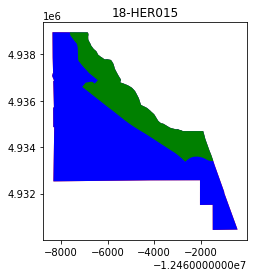

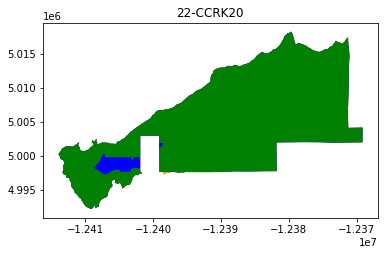

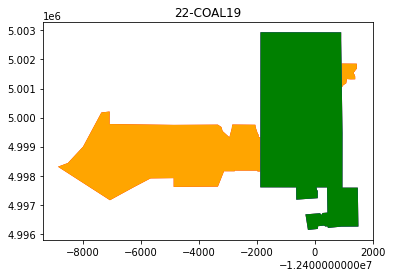

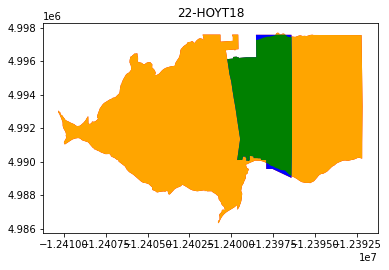

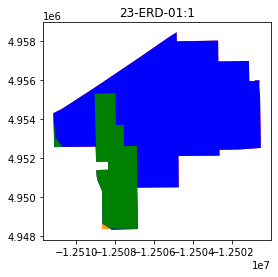

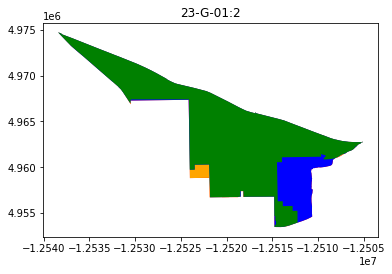

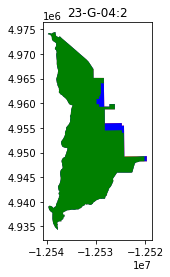

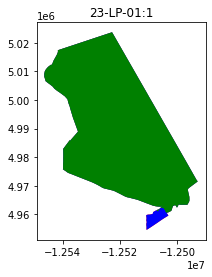

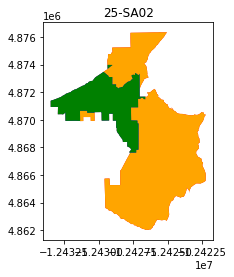

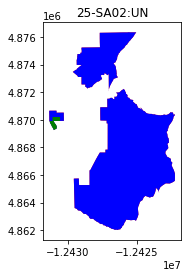

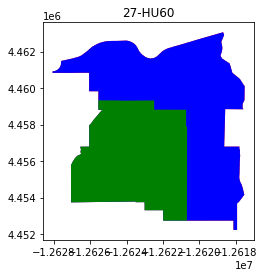

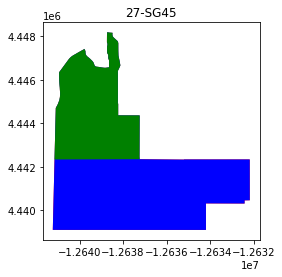

In [61]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"joinid"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [62]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2321, 1)
0 precincts w/ a difference of 0 km^2
2246 precincts w/ a difference between 0 and .1 km^2
60 precincts w/ a difference between .1 and .5 km^2
3 precincts w/ a difference between .5 and 1 km^2
3 precincts w/ a difference between 1 and 2 km^2
6 precincts w/ a difference between 2 and 5 km^2
3 precincts w/ a difference greater than 5 km^2
